In [1]:
#Run only if necessary

#!conda install git
#!pip install -U git+https://github.com/joaopfonseca/SOMPY.git

#pip install pandas-profiling

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import datetime

from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.feature_selection import VarianceThreshold

from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import sompy
from sompy.visualization.hitmap import HitMapView

from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from itertools import product
#from pandas_profiling import ProfileReport

import collections

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

CACHEDIR=C:\Users\gdalm\.matplotlib
Using fontManager instance from C:\Users\gdalm\.matplotlib\fontlist-v310.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
#reading our donors file
donors = pd.read_csv("donors.csv")

#As we have a unique number (CONTROLN) to identify each donor, we decided to use this number as index.
donors.set_index("CONTROLN", drop=True, inplace=True )

#When importing our dataset, we had a column that had no useful information, so we decided to drop it.
donors.drop("Unnamed: 0", axis=1, inplace=True)

#storing our initial number of observations, to use in the future
initial_nr_rows=donors.shape[0]

C:\Users\gdalm\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9,412) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<b> 1) Data Visualization </b>

The first step that we took, was to do a pandas profilling, to help us visualize and understand our data. We chose not to include it here, as it was not in any way preprocessed by us, was just the direct application of a librabry. 

This helps us to conclude that our data is very messy. We have a significant amount of NaNs across our data, but we also have what looks like data that was preprocessed, in the sense that some previous Nans were replaced by 0 (this is clear for instance, when in the Census data, we have the number of population in the neighborhood of a donor being 0).

<b> 2) Get to know our variables </b>

Based on this, and on other's fails detected, in the next steps, we will go trough all of our variables, carefully, to preprocess those and when needed fix some easy to detect outliers.

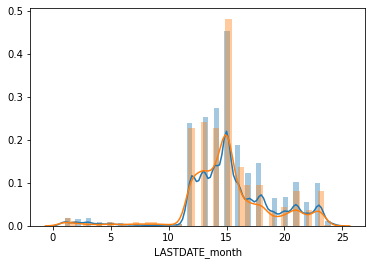

In [4]:
#Let us convert from date to years since the donors first gift. This format will be more useful for us to work with.
#Considering that we are working with data from 2014 to 2017, we will consider the time since the donor first gift up to 2017 (in the case, until the end of February of 2017, because according to CARDPM12 and NUMPRM12 that is the end of our historical data).

#Converting to datetime the "current" date
#We use 03 of 2017 to be inclusive with the month February (02)
date_as_of_end_historical_date=datetime.datetime(2017,3,1)

def get_nr_months(older_date, recent_date):
    """This function computes the number of months that have passed between two dates."""
    
    months=(recent_date.year-older_date.year)*12+recent_date.month-older_date.month
    
    return months

#Converting the date in ODATEDW to datetime
donors["ODATEDW"]=donors["ODATEDW"].apply(lambda x: datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10])))

#Converting it to the number of months that have passed, using the function get_nr_months
donors["ODATEDW"]=donors["ODATEDW"].apply(lambda x: get_nr_months(x,date_as_of_end_historical_date))

#Giving it a more accurate name for what it is now
donors.rename({"ODATEDW":"MONTHS_SINCE_FIRSTGIFT"}, axis=1, inplace=True)

#Moving on to the variable OSOURCE
#Donors OSOURCE has blank spaces, that considering that every donor was obtained from a mailing list (as it said on the PDF explaining the project), we can safely assume that the blank spaces here mean Nan values.
#Converting the spaces to NaNs
donors["OSOURCE"]=donors["OSOURCE"].apply(lambda x: np.where(x==" ", None,x))


#Moving on to the variable TCODE
#In the cases where the donor's title did not match any option in the metadata or when it was '0', which is according to the metadata, is no title, we decided to define those as Nan values, assuming everyone has to have a code, this is, when the code was incorrect or there was no code present, the data should have there a valid code (even if no special titles, we should have had at least always a "Mr.", "Miss" or "Mrs.")

#List with the TCODEs that are not present in the metadata
wrong_TCODEs=[202, 7, 21, 22, 228, 23, 25, 24002, 30, 39002, 45, 58002, 61, 6400, 72, 76, 98, 94, 93, 96, 134, 136]

#Substituting the codes where the TCODE is 0 or is in this list, by a NaN.
donors["TCODE"]=donors["TCODE"].apply(lambda x: np.where((x==0) or (x in wrong_TCODEs), np.nan,x))


#Moving on to the variable STATE
#Although formly the USA only have 50 states, when looking at the data, we found that we had 57 states. Although not politically correct, for pratical reasons, DC, VI, GU and AS are specific parts of the American territory, that are not states, but they're special geographic terriotories (DC is the federal district, and the others are islands). The remaining 3 entries refer to branches of the Army, either abroad or in America, but that according with the American zipcodes, they have a special statue, kind of like they were states.


#Moving on to the variable ZIP
#Some zip codes were incorrect, in the sense they had an hifen at the end, so we will correct this by taking off the hifens.
#Keeping only the first 5 digits of the ZIP codes, as to omitt the hifens found in some.
donors["ZIP"]=donors["ZIP"].apply(lambda x:x[:5])

#Moving on to the variable MAILCODE
#we will try to understand if this variable means that PVA already don't have the correct adress or if it has another meaning (for instace, when the donor was firsdt obtained the adress was bad, but it was rectified in the first mailing, but PVA did not update this column)

#In order to do this, we will analyse the months that have passed since last donation to figure it out if there is a significantly different distribution of the donors with bad adress from the remaining
#If this don't happen, we will assume PVA did not "lose" their correct adress
donors["LASTDATE_month"]=donors["LASTDATE"].apply(lambda x: datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).apply(lambda x: get_nr_months(x,date_as_of_end_historical_date))

sns.distplot(donors[donors["MAILCODE"]!="B"]["LASTDATE_month"])
sns.distplot(donors[donors["MAILCODE"]=="B"]["LASTDATE_month"])

plt.show()

#The distributions are fairly close, therefore we assume that is reasonable to beleive the MAILCODE variable has a different meaning from the one we originally believed, and therefore, we will just drop this variable, as we cannot extract something meaningfull of it

#Droping MAILCODE
donors.drop("MAILCODE", axis=1, inplace=True)
#Droping the auxiliar variable we created
donors.drop("LASTDATE_month", axis=1, inplace=True)

In [5]:
#Moving on to the variable PVASTATE


# In the variable PVASTATE, and considering we have empty values, even in cases where we know a state is served either by PVA or by EPVA (because other donors in the same state was marked with a P or an E), we will not consider a blank space as a state not served by either organization 
#Moreover according to the metadata, it is suggested that the default option is for states to be served by PVA and only a few by EPVA

#Replacing the blank spaces by NaNs
donors["PVASTATE"]=donors["PVASTATE"].apply(lambda x: np.nan if x==" " else x)

#We have donors where the PVASTATE is a NaN, but that live in states where other donors have the PVASTATE filled wither with P or E. So, we can manually look for each state if there is information if the state is served by PVA or EPVA, and fill the NaNs of the states we know the answer.
#Note that about some states we don't have information if either is sirved by PVA or by EPVA, but considering how the metadata is constructed, it seems that the default option is for a state to be served by the PVA, with some exceptions being served by the EPVA chapter of the organization.
#Considering this, for the states where we don't have a match, we will just consider them to be PVA states (this wil yield similar results to a fillna with mode).

#Getting list EPVA_States and PVA_States which contain the name of the satates that have PVASTATE equal to E and P, respectively
EPVA_States=list(donors[donors["PVASTATE"]=="E"]["STATE"])
PVA_States= list(donors[donors["PVASTATE"]=="P"]["STATE"])

def match(column, data):
    """This function is specific to our dataset. It receives the column STATE and uses the information there contained to find the value that should go in PVASTATE. It returns a new column PVASTATE, without NaN values."""
    
    #Creating a list so that we have where to store the information to be returned at the end
    new_column=[]
    
    #Accessing our lists, as they were created outside the function
    global EPVA_States
    global PVA_States
    
    #Going through each value in the column given - STATE
    for string in data[column]:
        
        #If the value (a states' name) is in EPVA_States list, we append to new_column an E
        if string in EPVA_States:
            new_column.append("E")
        
        #If the value (a states' name) is in PVA_States list, we append to new_column an P
        elif string in PVA_States:
            new_column.append("P")
        
        #If the value (a states' name) is in neither of these 2 lists, we append a P, as it's the one that metadata seems to consider as 'default'
        else:
            new_column.append("P")
    
    #Converting our list new_column into a Series, giving it the donors' index and returning it
    return pd.Series(new_column, index = donors.index)

#Applying our function match, to fill the NaN values in PVASTATE
donors["PVASTATE"]= match("STATE", donors)


#Moving on to the variable DOB
#As we did with ODATEDW, we will also tranform the Birthday from date to age.

#Converting the variable DOB from date to age (by assuming we "are" in 2017)
donors["DOB"] = donors["DOB"].apply(lambda x: np.nan if pd.isna(x) else 2017- int(str(x)[:4]))

#Giving the variable a more suitable name
donors.rename({"DOB":"AGE"}, axis=1, inplace=True)

#After doing this, we realized that we have some entries that have 0 age. This is, their date of birth was in the same year as the end of the historical data. 
#The variable AGE contains observations with less than 18 years old. Altough this situation may happen, it's strange to have kids, for instance, with 4 years making donations in their names, mainly when looking at some observations where, the first time they donated was before they were even born. Considering not only how this situation looks a univarite outlier, but also how there seems to exist a strange relation between variables (multivariate outliers).

print("We have", round(donors[donors["AGE"]<18].shape[0]/initial_nr_rows*100, 3), "% of our initial donors being under 18, from which", donors[(donors["MONTHS_SINCE_FIRSTGIFT"].apply(lambda x: x/12) > donors["AGE"])].shape[0], "donors have made their first donation before they were even born. Moreover, we have", donors[donors["AGE"]==0].shape[0], "donors whose age is 0.")

#Getting current number of rows of our dataset
previous_rows=donors.shape[0]

#Dropping the donors whose age is lower than 18 years old
donors = donors[(donors["AGE"]>=18) | (donors["AGE"].isna())]
donors_dropped=(previous_rows-donors.shape[0])

print("Dropping these donors, led us to lose", round((1-(donors.shape[0]/initial_nr_rows))*100, 3), "% of our inital dataset, having a total of", round(donors_dropped/initial_nr_rows*100, 3), "% of our donors been dropped until now.")

We have 1.055 % of our initial donors being under 18, from which 318 donors have made their first donation before they were even born. Moreover, we have 8 donors whose age is 0.
Dropping these donors, led us to lose 1.055 % of our inital dataset, having a total of 1.055 % of our donors been dropped until now.


In [6]:
#Moving on to the variable NOEXCH
#Checking the different values variable NOEXCH takes
donors["NOEXCH"].value_counts()

0    60549
0    33533
1      192
1       89
X       35
         7
Name: NOEXCH, dtype: int64

In [7]:
#Variable NOEXCH gets values that don't match the metadata, to the point where we have more 1's and 0's than the values this variable should take. Not knowing the meaning of this variable, as the metadata doesn't provide any useful information. Although we could reason that the 1s would indicate a X and the 0s an empty space (this is, some values have suffered previously a sort of OneHotEncoding), we don't feel confortable doing this, for 2 main reasons:
#1. The metadata is not clear in the meaning of this variable, so any inference is constrained by our lack of understandement of what this variable tries to capture;
#2. It is not clear why some entries would have already be OneHotEncoded, while the others were not, which even begs the question, was this enconding properly done?
#Due to the concerns expressed above, we feel safer droping this variable all together, instead of risking its improper use.

#Dropping variable NOEXCH
donors.drop("NOEXCH", axis=1, inplace=True)

#Moving on to the variables RECINHSE, RECP3, RECPGVG and RECSWEEP
#For the following 4 variables, we will do already a simple OneHotEncoding by hand. this is we leave it already done with "X" values being replaced by "1" and the spaces values being replaced by "0". Note that adding another column where the spaces would be 1 and the X's would be 0, would only create redundancy. 
#For variables RECINHSE, RECP3, RECPGVG and RECSWEEP, assigning a value of 1 when donors had an X, otherwise, a value of 0 is given.
donors["RECINHSE"]=donors["RECINHSE"].apply(lambda x: 1 if x=="X" else 0)
donors["RECP3"]= donors["RECP3"].apply(lambda x: 1 if x=="X" else 0)
donors["RECPGVG"]=donors["RECPGVG"].apply(lambda x: 1 if x=="X" else 0)
donors["RECSWEEP"]=donors["RECSWEEP"].apply(lambda x: 1 if x=="X" else 0)

#Moving on to MDMAUD
#We decided to drop variable MDMAUD as it contains the same information as variables MDMAUD_R, MDMAUD_F and MDMAUD_A.
#Dropping variable MDMAUD
donors.drop("MDMAUD", axis=1, inplace=True)


#Moving on to DOMAIN
#The variable DOMAIN will be split into two. The first one will be of an Object type, and will correspond to the Urbanicity level. 
#The second one will be encoded to represent an ordinal variable (note: we inversed the relation, meaning that now, 0 corresponds to what was previously 4, 1 corresponds to what was prevoiusly 3, 2 correspond to what was previously 2, and 3 corresponds to what was previously 1). In this way, the higher the value, the higher the social economic status of the neighborhood. We did this, as the remaining ordinal variables of our dataset will be organized this way, being it easier to interpretation.

#Creating variables DOMAIN_URBANICITY and DOMAIN_SOCIAL_ECONOMIC based on the first and second digits of variable DOMAIN, respectively
donors["DOMAIN_URBANICITY"]=donors["DOMAIN"].apply(lambda x: x[0]).apply(lambda x: np.where(x==" ", None,x))
donors["DOMAIN_SOCIAL_ECONOMIC"]=donors["DOMAIN"].apply(lambda x: x[1:]).apply(lambda x: np.where(x.isnumeric(), x, None))
donors.drop("DOMAIN", axis=1, inplace=True)

#Specifying the order to the encoder. Then, after applying it, making sure that we keep our NaN values as NaN, instead of those being also encoded.
encoder= OrdinalEncoder([[ "4", "3", "2", "1", None]])
donors["DOMAIN_SOCIAL_ECONOMIC"] = encoder.fit_transform(donors["DOMAIN_SOCIAL_ECONOMIC"].values.reshape(-1, 1))
donors["DOMAIN_SOCIAL_ECONOMIC"] = donors["DOMAIN_SOCIAL_ECONOMIC"].apply(lambda x: np.where(x==4, np.nan, x))

#Checking that everything is okay
donors["DOMAIN_SOCIAL_ECONOMIC"].value_counts()

2.0    45594
3.0    28179
1.0    16563
0.0     1786
Name: DOMAIN_SOCIAL_ECONOMIC, dtype: int64

In [8]:
#Moving on to HOMEOWNR
#The variable HOMEOWNR in the metadata only has 2 possible values, either it is a home owner (H) or it is unknown (U). Nevertheless, in our data, we also have a blank space. As in the other cases where the variable's decription was "X Flag", we will assume that here when we have a blank space, it's because the donor is not a home owner. This conclusion is mainly supported because any Nan value here would fit in the category Unknown, meaning this that there would be no reason for our database to have Unknown to the Nans and also have blank spaces to the ones that were Nans. Furthermore, in every variable that had a decription "X Flag", we only had 2 options, either it had the flag (in those cases, the flag would be an "X", in this case it's an "H"), being those cases where the PVA obviously knew the answer (as it was as if someone participated in one of their programs, or if he was a major donor), so there was no reason for uncertantainty there, while in this case, as there can be uncertainty if someone is home owner or not, the hipotesis "U" was introduced. Being this said, we will treat the blank spaces as if it doesn't have the home owner flag, H if it does, and the U values will be converted to Nans.
#Replacing the "H" by 1, the " " by 0 and otherwise, making it into a NaN value
donors["HOMEOWNR"] = donors["HOMEOWNR"].apply(lambda x: 1 if x=="H" else 0 if x == " " else np.nan)


#Moving on to CHILDXX (with XX being either 03, 07, 12 or 18)
#For these variables, we will assume that whenever there is a blank space, it means that the donor doesn't have kids at that age, neither male, nor female, nor both. Despite the number of blank spaces being somehow strange (as we have a significant number of blank spaces), we will still consider it to be the best approach we can take in this particular situation. 
#We decided to only take into account if a donor had a child or not within the specified age group, and not consider the gender of such child/children. We based this decision on the fact that we think the behaviour of a donor and "what type" of donor he is, may be influenced by having a child with a certain age (as the implications for the life of the donor may vary with the age of the child), but not by the gender of such child (we think it doesn't make sense to believe that once we know a donor has a child with age X, that his behaviour as a donor will vary accordingly with the gender of his child). 
#Therefore, we think it makes sense to keep the "Distribution by Age" as this may indicate other aspects of the donor's life, like the disposable income he has for donations (each age group corresponds to different needs from the children), but it's farfetched to think that the gender of the children will influence significantly the donor's behaviour according to what is the objective of this case-study 
#Lastly, we also decide to do a quick OneHotEncoding by hand here

#For these 4 variables, Turning the " " into 0, otherwise, converting everything to 1
donors["CHILD03"]=donors["CHILD03"].apply(lambda x: 0 if x== " " else 1)
donors["CHILD07"]=donors["CHILD07"].apply(lambda x: 0 if x== " " else 1)
donors["CHILD12"]=donors["CHILD12"].apply(lambda x: 0 if x== " " else 1)
donors["CHILD18"]=donors["CHILD18"].apply(lambda x: 0 if x== " " else 1)


#Moving on to NUMCHLD
#In the case of the variable NUMCHLD, we have no value 0. At first, we thought this might be because the Nans would be zeros (this might easily happen if this data was obtained from a survey asking "how many children do you have?", where 0 wouldn't be an option), but consideirng the amount of Nans, it doesn't seem likely that all values should be replaced by 0. So, we will leave it like this, for now.
#checking the different values the variable NUMCHLD takes
donors["NUMCHLD"].value_counts()

1.0    7757
2.0    3100
3.0    1097
4.0     314
5.0      59
6.0       7
7.0       1
Name: NUMCHLD, dtype: int64

In [9]:
#Moving on to INCOME and WEALHT1
#We are considering Income as an ordinal variable where the highest score represents the highest value for income. We applied this same logic for the variable Wealth1.

#Moving on to GENDER
#As the Gender variable had more labels than it should, we decided to consider those Nans, as well as the U for Unknown. 
#Note that contrary to case of the variable "HOMEOWNR", where blank spaces were considered different from the option 'Unknown' (because of what we explained previously, where that variable was constructed in a logic of having a 'stamp'/flag for the home owners and another for the unkown, leaving the blank as reasonably assumable that they don't own a house), here we are not talking about having a flag for gender, but we are talking about a classification that has necessarly to be filled. 
#(Despite how politicaly incorrect this would be:) People either are male or female, with in this case, a third option existing, where we consider a joint account, but blank is not an option.
#Turning all entries different from "M", "F" or "J" into NaNs values
donors["GENDER"]=donors["GENDER"].apply(lambda x: np.nan if ((x==" ") or (x=="U") or (x=="C") or (x=="A")) else x)

#Moving on to HIT
#The HIT variable has a significant number of zeros. Nevertheless, we will not interpret them as NaNs, because although our donors were initially retrived from other mailing ordering lists, them being on those lists doesn't mean they have actually answered to any of those mail offers, meaning zero is a perfectly acepptable answer.
#checking what values the variable HIT can take
donors["HIT"].value_counts().sort_index().tail(10)

65      5
66      4
67      1
69      1
73      1
75      2
79      1
84      1
240    67
241     4
Name: HIT, dtype: int64

In [10]:
#As we can see, HIT has some extreme values. We don't know if they were wrongly inputed or not, but considering how different they are from the remaining (240 and 241, when the next highest value is 84), we will make all values to have as a maximum limit the 84, therefore, converting these extreme values to 84.
#Replacing all values higher then 84 by 84
donors["HIT"]=donors["HIT"].apply(lambda x: 84 if x>84 else x)


#Moving on to the varaibles from MBCRAFT until PUBOPP 
#On those variables we have both a significant number of zeros and Nans. In this case, we will consider that zeros here are true zeros (meaning the donor did not respond any time to a specific mail order offer), and the NaNs being when we don't have that information.


#From variable DATASRCE to PEPSTRFL, we decided to drop the variables: 
#DATASRCE and LIFESRC: Because this data refers to which data gathering company had some information regarding a specific donor. As there is no way to differentiate these two data gathering companies (all we know about them is that they collect data from diverse sources), there is no point in exploring this further.
#MALEMILI, MALEVET, VIETVETS, WWIIVETS, LOCALGOV, STATEGOV and FEDGOV: These are repeated variables that we also have on the Census data (the information may differ a little bit, but having to choose one to keep, we decided to keep the Census data as we have a lot more information from that source, and it helps coherence)
#WEALTH2: As this variable contains repeated information compared with WEALTH1. Although the values are not perfect complements in both variables, according to how the metadate is divided, it looks like WEALTH1 was obtained somehow directly from PVA, while the WEALTH2 was retrived from a data gathering company. Given this, we decided to keep the information that the organization itself seems to have gathered.
#GEOCODE: Considering the metadata regarding this variable, there is no useful information to be extracted from it. There is no relevant association between how each of our entries match the census data, which is aggravated further as we don't have a clear explanation regarding what each label of GEOCODE means.
#Droping the previously mentioned variables
donors.drop(["DATASRCE", "LIFESRC", "MALEMILI", "MALEVET", "VIETVETS", "WWIIVETS", "LOCALGOV", "STATEGOV", "FEDGOV", "WEALTH2", "GEOCODE"], axis=1, inplace=True)


# Variables SOLP3 and SOLIH give us information of the limits of the number of times each donor allows for mail to be solicited. We will use these variables as categorical, as we have the situation where an empty entry means the donor can be mailed with no limitation in the amount of times, which is not easy to convert to a numeric entry.


#Moving on to MAJOR
#As we did above, we also will do a OneHotEncoder by hand, regarding the variable MAJOR, the variables that translate the interests of the donors, and the variable PEPSTRFL.
#Replacing all the X's by 1's, otherwise giving it a value of 0
donors["MAJOR"]=donors["MAJOR"].apply(lambda x: 1 if x=="X" else 0)

#Moving on to variables from COLLECT1 TO PLATES and PEPSTRFL, we decided to do a quick one hot encoding here as well. Note that this could be done further along the line, when using the One Hot Encoder for all variables. It was just a preference.
#Iterating over the columns regarding the donors' interests and tranforming the Y's into 1's, otherwise making it into 0's
for interest in donors.loc[:, "COLLECT1":"PLATES"].columns:
    donors[interest]=donors[interest].apply(lambda x: np.where(x=="Y", 1,0))

#Moving on to PEPSTRFL
#Replacing the X's by 1's, otherwise storing the value 0.
donors["PEPSTRFL"]=donors["PEPSTRFL"].apply(lambda x: 1 if x=="X" else 0)

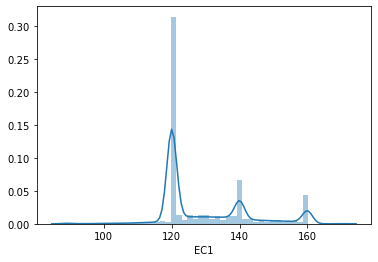

In [11]:
#In the Census data, we had some problematic variables. In some variables, it is impossible for an entry to have a 0, but we end up having them anyway. To be the most conservative possible and only consider the true impossibilities, we will not consider impossible variables like 'average income in the neighborhood' to be 0, as depending on the constructin of a neighborhood, that may be rare, but possible. Nevertheless, we will consider that the variables POP901 and POP903 can not be zero (if we have a donor, he may not have a family, but at least his neighborhood has 1 person living there and 1 houselhold).
#One thing that we noticed when looking at entries that had POP901 equal to 0 was that the vast majority of the other variables of the Census data also had 0 for those donors. We will consider that in the case of those donors, the Census data is actually missing (it's obvioulsy missing in POP901, and as for those situations almost all other variables are also 0, it also seems obvious that those entries have missing values).
#For all the other donors, the only zeros we will consider as NaNs are situations where it also is impossible for the variable to take the value of 0: HV1 and HV2 (if a donor has an adress, his neighborhood has at least one home, that has to be worth something); MSA and ADI (one is a geographic parameter, and every neighborhood belongs to one of those, and the other is an index, that again, every neighborhood must have a value for); POP903 (as it concerns the number of households).
#Note that, as mentioned, we were very cautious when replacing zeros by NaNs, and only doing so in the cases where not doing so would be unrational. 

#Getting the indexes of all the donors whose value for POP901 is 0.
indexes=donors[donors["POP901"]==0].index

#Going to these donors and converting the zeros to NaNs.
donors.loc[indexes,"POP901":"AC2"]=donors.loc[indexes,"POP901":"AC2"].applymap(lambda x: np.nan if x==0 else x)

#For the previously mentioned 5 variables, we also replace the zeros by NaNs.
donors.loc[:,["HV1", "HV2", "MSA", "ADI", "POP903"]]=donors.loc[:,["HV1", "HV2", "MSA", "ADI", "POP903"]].applymap(lambda x: np.nan if x==0 else x)


#Moving on to AGE903 and AGE906. 
#Given we have the median and average age of population and the median and average age of population above 18 (adults), keeping variables where it's stored the median and average age above 25 seems of no relevance for what we intend to study (there might be some gains from not only keeping the median and average age of population, but also from adults (>=18 years old), but the 25 years threshold seems a random threshold).
#Dropping the variables
donors.drop(["AGE903", "AGE906"], axis=1, inplace=True)


#Moving to variables from CHILC1 to CHILC5
#These variables capture closely the same information as CHIL1 to CHIL3, but in a more exaustive way, that for the purpose of segmentation of donors, that exauhstiveness is not necessary.
#Dropping the variables
donors.drop(list(donors.loc[:, "CHILC1":"CHILC5"].columns), axis=1, inplace=True)

#Moving on to variables from MC1 to MC3
#In these variables, although we see their value in the Census perspective, in our prespective it doesn't seem to bring much value to look for movements in population in the neighborhood compared with the Census of 2005.
#Dropping the variables
donors.drop(["MC1", "MC2", "MC3"], axis=1, inplace=True)

#Moving on to variables from TPE1 to TPE13
#Considering the amount of variables that we have that in a more clear way capture the demographic and economic situation of each neighborhood, these variables that capture which methods of transportation people use and how long they take to get to work don't seem to give us any new and more clear information regarding a neighborhoods.
#Dropping the variables
donors.drop(list(donors.loc[:, "TPE1":"TPE13"].columns), axis=1, inplace=True)


#Moving on to variables OCC1 to OCC13
#As these variables refer to the occupation of the population in a given neighborhood, but we have those presented in a better constructed way in variables EIC1 to EIC16, where is presented the industry in which people from a neighborhood work.
#Obviously, occupation and the industry are not exactly the same thing, but for the purpose of our clustering, it doesn't make sense to keep both, and from the 2 groups of variables, the industry seems to us to bring more descrimination power between the neighborhoods.                
#Dropping the variables
donors.drop(list(donors.loc[:, "OCC1":"OCC13"].columns), axis=1, inplace=True)

#Moving on to variables DW1 to DW9, HUR1 and HUR2 and HUPA1 to HUPA7
#All these variables describe the structure of houses in a neighborhood, which again, for the purpose of our study could be an indicator of the economic situation of the neighborhood (e.g., suggesting the value of the houses), but we have variables that capture this more directly.
#Dropping the variables
donors.drop(list(donors.loc[:, "DW1":"DW9"].columns), axis=1, inplace=True)
donors.drop(["HUR1", "HUR2"], axis=1, inplace=True)
donors.drop(list(donors.loc[:,"HUPA1":"HUPA7"].columns.values), axis=1, inplace=True)

#Moving on to ETHC1 to ETHC6
#Given we have other variables that give us the percentage of population in each age group, keeping a variable for this specifically regarding white people and black people (when we already also have the total percentage of white, black and other etnicies in the neighborhood stored in other variables), seems to be a litle bit too much looking for differences in these 2 etnicies.
#Dropping the variables
donors.drop(list(donors.loc[:,"ETHC1":"ETHC6"].columns.values), axis=1, inplace=True)

#Moving on to HC1 to HC21 and VOC1 to VOC3
#To our study, at most, these variables would give us some economic indicator of a neighborhood, but given we have direct variables to measure that, it doesn't make sense to keep variables that don't even do it in a direct way.
#Dropping the variables
donors.drop(list(donors.loc[:,"HC1":"HC21"].columns.values), axis=1, inplace=True)
donors.drop(list(donors.loc[:,"VOC1":"VOC3"].columns.values), axis=1, inplace=True)

#Moving on to variables AC1 and AC2
#We have already other variables capturing the distribution of ages, so we don't feel these two add any value by just defining two close to what we have, but different, ranges.
#Dropping the variables
donors.drop(["AC1", "AC2"], axis=1, inplace=True)


#Moving on to ANC1 to ANC15
#These variables capture the percentage of people with ancestry in some countries in Europe (considering that Russia is part of Europe). We don't really need all this exaustiveness of countries, but we may acknowledge that there may be some descriminatory power in a neighborhood having a significant number of people with European culture, so we will summarize all those variables in the variable ANCEU, that gives the percentage of people in the neighborhood with European ancestry.
#Creating the new variable as the sum of the percentages in all variables from ANC1 to ANC15, and then dropping them
donors["ANCEU"]=donors.loc[:,"ANC1":"ANC15"].sum(axis=1)
donors.drop(list(donors.loc[:,"ANC1":"ANC15"].columns.values), axis=1, inplace=True)


#Another problem that we faced was the unclear scale that some variables presented. One of those was EC1. But by looking at the distribution of data, and with common sense, it becomes kind of clear that the unique problem with this variable is that instead the years of education being presented in a normal scale, they are multiplied by 10. To be even more sure about this, we looked for more information about this variable online, regarding the US, and our findings were consistent with the only problem of this variable being it multiplied by 10.

#Doing a distplot for variable EC1
sns.distplot(donors["EC1"])
plt.show()

#Turning the variable EC1 into a float type, and dividing each value by 10, except when we are dealing with the NaN values
donors["EC1"]=donors["EC1"].astype(float).apply(lambda x: np.where(x==np.nan,x, x/10))

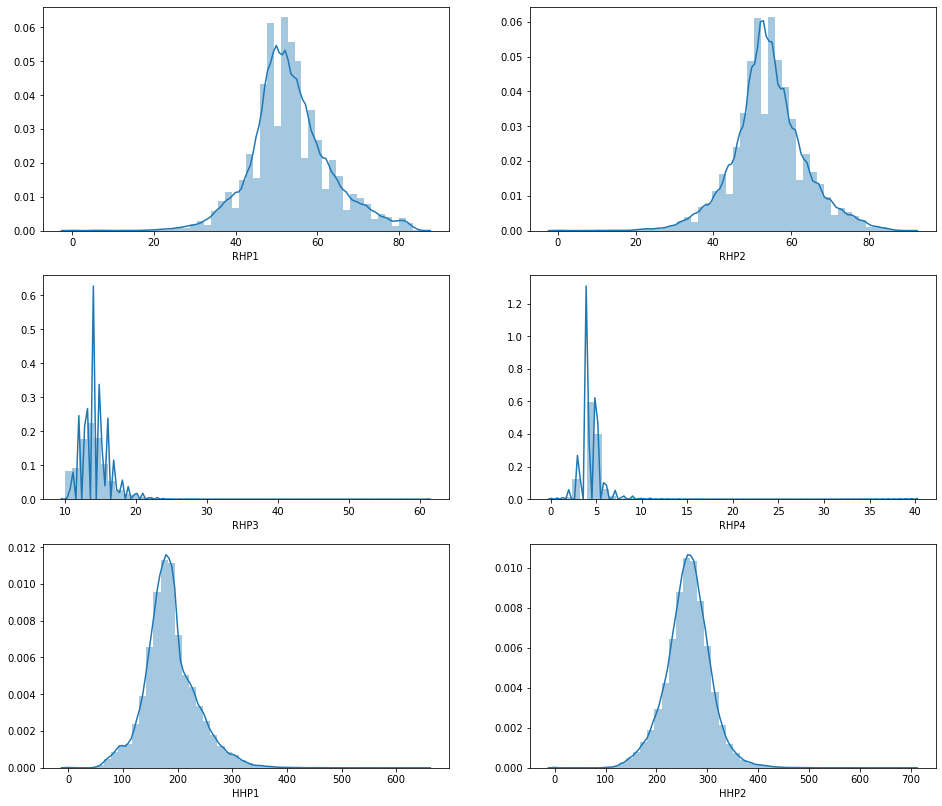

In [12]:
#Moving on to RHP1 to RHP4, HHP1 and HHP2
#Lastly, these variables, although some we believe could probably give us some demographic and economic insigh about the donors' neighborhood, we will have to exclude them from our study.
#The reason for this is that even after researching for more information about these variables, we were not able to figure out a valid scale on how they are being classified.
#For instance, in the distplots, we can clearly see that we have a high concentration of median/average number of rooms per housing unit between 40 and 60, which doesn't make any sense. Even if considering the variable is registed as 10 times what it should (20 rooms corresponds to 2), this would mean that we would have houses with 0 rooms (as we would have entries with median 0.5, and therefore in some neighborhoods, some houses would have 0 rooms), which is not possible, given that after looking at the offical explanation of this variable in the Census, it doesn't only account for bedrooms (where 0 would be possible, when having a T-0), but all rooms in the house (a house with no rooms, is not a house).  
#Regarding the median number of persons per housing unit and the average number of persons per room, the same logic applies. 
#Lastly, regarding the median and average person per household, when we observe the distplots, we can see that we have a high concentration around 200 and 300, respectively, which doesn't seem to make any sense. Again, even if we try to change the values to be 10 times less the ones we have, that would still mean that the average person per household in the neighborhoods, for instance, would have a higher concentration around 30 people, which still doesn't seem to be the right scale. We even thought of dividing all values by 100, but that would lead to values between 0 and 1, which would also make no sense, given that would mean we had houselholds with 0 people living there, which will be impossible.
#Considering all these situations, and not being able to figure out how the variable stored the information, we decided to drop those to avoid later on making interpretation errors.

#Defining the size of our figure
plt.figure(figsize=(16,14))

#Plotting variables RHP1, RHP2, RHP3, RHP4, HHP1 and HHP2
plt.subplot(3,2,1)
sns.distplot(donors["RHP1"])
plt.subplot(3,2,2)
sns.distplot(donors["RHP2"])
plt.subplot(3,2,3)
sns.distplot(donors["RHP3"])
plt.subplot(3,2,4)
sns.distplot(donors["RHP4"])
plt.subplot(3,2,5)
sns.distplot(donors["HHP1"])
plt.subplot(3,2,6)
sns.distplot(donors["HHP2"])

plt.show()

#Dropping these variables
donors.drop(["RHP1", "RHP2", "RHP3", "RHP4", "HHP1", "HHP2"], axis=1, inplace=True)

In [13]:
#When analysing the variables regarding  the donors' Giving History, we decided to drop:
#ADATE_X (with X from 2 until 24), as there doesn't seem to be any relevance in when the promotions are mailed, even because PVA tends to mail the majority of the promotions at the same time. Furthermore, we don't know if we can even relate the date the promotion was mailed, with the date each donor received the promotion (as we are talking about considerable differences in states, and even we have some territories outside of continental US, it is doubtful that the date of the promotion being mailed will impact all donors in the same way).
#RDATE_X (with X from 3 to 24). We also decided to drop the date in which the gift was received, in part for the same reasons (there is probably no concrete link between the date the gift was received and the date the gift was sent), but also we noticed that there was some tendency for PVA to report receiving the gifts in batches (it would be expected that we had many different dates with few gifts in each one, but again, we have concentrations of some significant numbers of gifts received reported at the same day/days), which may indicate that the data collected is not necessarly accurate (e.g. it looks more like it was the day when an employee from PVA went to Post office to collect the gifts, and not as much as the day the gifts were truly received, what is not linked to the behaviour of the donors at all.). 
#Furthermore, what seems the most relevant information about these variables is stored in LASTDATE, MINRDATE and MAXRDATE (as those suggest at least a reference, althouth not accurate as mentioned above, of when was the last, min and max gift by each donor)
#MAXADATE. Again, this variable doesn't provide significant information regarding the behaviour of the donors, as it concentrates the majority of values on same date (it only has 5 labels, with one date concentrating 93629 entries). Fruthermore, this variable again gives us more information about the business process of the company than any other useful information.
#RFA_2, because it is a repeated variable (we have it decomposed in RFA_2R, RFA_2F and RFA_2A).
#CONTROLN, we dropped it at the beggining, as we decided to use it as index.
#HPHONE_D, we don't find it significant if the Home owner has a published phone number or not, it doesn't seem related to behaviour.

#Dropping variables ADATE_X, RDATE_X, RFA_2, HPHONE_D and MAXADATE
donors.drop(list(donors.loc[:, "ADATE_2":"ADATE_24"].columns.values)+list(donors.loc[:,"RDATE_3":"RDATE_24"].columns.values)+["RFA_2", "HPHONE_D", "MAXADATE"], axis=1, inplace=True)

#Moving on to MINRDATE, MAXRDATE and LASTDATE
#As we did previously, we will convert these variables from a date format to how many months have passed up to the end of the period in study (that according to metadata, namely CARDPM12 and NUMPRM12, is February of 2017).
#Note that for the reason explained above, we decided to take the RDATE_Xs, we will still keep the variables MINRDATE, MAXRDATE and LASTDATE, because although those variables may suffer part of the same problem explained above, they still summarize important information that is necessary for our analysis.
#We convert the variables MINRDATE, MAXRDATE and LASTDATE into datetimes, and then calculate the months since each date, using the function get_nr_months
donors["MINRDATE"]=donors["MINRDATE"].apply(lambda x: datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).apply(lambda x: get_nr_months(x,date_as_of_end_historical_date))
donors["MAXRDATE"]=donors["MAXRDATE"].apply(lambda x: datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).apply(lambda x: get_nr_months(x,date_as_of_end_historical_date))
donors["LASTDATE"]=donors["LASTDATE"].apply(lambda x: datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]))).apply(lambda x: get_nr_months(x,date_as_of_end_historical_date))

#Renaming these 3 variables into a more accurate name after our changes
donors.rename({"MINRDATE":"MONTHS_SINCE_MINGIFT", "MAXRDATE":"MONTHS_SINCE_MAXGIFT", "LASTDATE":"MONTHS_SINCE_LASTGIFT"}, axis=1, inplace=True)

#As our dataset only contains lapsed donors (e.g., someone whose last donation was between 13 and 24 months ago), no donor in MONTHS_SINCE_LASTGIFT should have a value smaller than 13. However, this happens and therefore, we will convert those values to 13, as we know that they are clearly wrong.

#Interating over the values in MONTHS_SINCE_LASTGIFT and replacing all values smaller than 13, by 13.
donors["MONTHS_SINCE_LASTGIFT"]=donors["MONTHS_SINCE_LASTGIFT"].apply(lambda x: 13 if x<13 else x)


#Regarding the RFA_X that we have, we have some entries with blank spaces, in that case we will replace it by NaN.
#Then, we will separate RFA_X (with X from 3 to 24) into three new columns (RFA_X_Recency, RFA_X_Frequency and RFA_X_Amount) corresponding to the meaning of the three digits.
#Finally, we will drop the original RFA_X, as it is no longer needed.

#Iterating over each column from RFA_3 to RFA_24
for column in donors.loc[:, "RFA_3":"RFA_24"].columns.values:
    
    #Creating the string with the name of the new column we will create. We add to RFA_X either _Recency, _Frequency or _Amount
    str_recency=column +"_Recency"
    str_frequency=column +"_Frequency"
    str_amount=column +"_Amount"
    
    #Creating the 3 new columns, separating each column RFA_X into the 3 digits. If there are not enough digits, it's because it's an NaN value
    donors[str_recency]=donors[column].apply(lambda x: x[0] if (type(x)==str and len(x)>=1 and x!=" ") else np.nan)
    donors[str_frequency]=donors[column].apply(lambda x: x[1] if  (type(x)==str and len(x)>=2) else np.nan)
    donors[str_amount]=donors[column].apply(lambda x: x[2] if  (type(x)==str and len(x)>=3) else np.nan)
    
#Dropping the variables from RFA_3 to RFA_24   
donors.drop(list(donors.loc[:, "RFA_3":"RFA_24"].columns.values), axis=1, inplace=True)


#The variables RFA_X_Recency have some anomalies in the sense they have values that they shouldn't, so we will drop those and convert them to NaNs
#Going through each column name in our dataset
for column in donors.columns:
    #If our column name contains the words "RFA" and "Recency", meaning it's one of the columns we created in the previous cell (in the format RFA_X_Recency)
    if ("RFA" in column) and ("Recency" in column):
        #We convert all non-valid values (by the meatadata information) into NaNs.
        donors[column]=donors[column].apply(lambda x: np.nan if (x!="F") and (x!="A") and (x!="S") and (x!="N") and (x!="L") and (x!= "I") else x) 
             
        
#The variable RFA_23_Frequency also had some probelms, in the sense it had letters when it should have numbers. By looking at RFA_23_Amount, we can easily see that by some reason the amount had NaN values when it should have the values contained in variable RFa_23_Frequency.
#Based on this, we will pass the values from variable RFA_23_Frequency to variable RFA_23_Amount, and in variable RFA_23_Frequency we will replace those values by NaNs.

#We get the index of the donors who have values in RFA_23_Frequency different from 1,2,3 or 4 (and also disregarding the NaN values)
for index in donors[(donors["RFA_23_Frequency"]!="1") & (donors["RFA_23_Frequency"]!="2") & (donors["RFA_23_Frequency"]!="3") & (donors["RFA_23_Frequency"]!="4") & (pd.notnull(donors["RFA_23_Frequency"]))]["RFA_23_Amount"].index:
    #We go to the column RFA_23_Amount, to each index and substitute its value with the corresponding value in the column RFA_23_Frequency
    donors.loc[index, "RFA_23_Amount"]=donors.loc[index, "RFA_23_Frequency"]
    #After the values are switched between both columns, we convert the one in the "wrong" one by a NaN value
    donors.loc[index, "RFA_23_Frequency"]=np.nan    
    
    
#The variables RAMNT_X (with X being from 3 to 24) don't have any zeros, but have a significant number of NaNs. In this case, it makes sense to assume that the NaNs represent entries where there was no dollar amount received because the donor didn't contribute to that campaign. This is the same as saying that the donor in that particular campaign donated 0. So, in this case, we can, with a reasonable degree of certainity (which we didn't have in the variable NUMCHLD), replace the NaNs by zeros.

#For each variable RAMNT_X, we convert the NaN values into 0's
donors.loc[:,"RAMNT_3":"RAMNT_24"]=donors.loc[:,"RAMNT_3":"RAMNT_24"].apply(lambda x: np.where(pd.isnull(x), 0,x))


#The variable CARDGIFT has some zeros. This is not a problem, as we know that each donor has at least answered to one campaign, but in nowhere is said that that campaign had to be onw with cards, so it's feasible that some donors have never donated in campaigns with cards. Moreover, the variable NGIFTALL has no zeros, which is precisely what needed to happen.
#Showing the first 10 different values the variable CARDGIFT can take
donors["CARDGIFT"].value_counts().head(10)

1    17480
2    13291
3    10357
4     8357
5     6653
6     5966
7     5025
0     4955
8     4259
9     3451
Name: CARDGIFT, dtype: int64

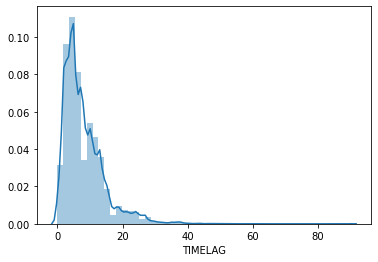

In [14]:
#As we are considering that when a donor gives zero is because he didn't answer the promotion (as common sense dictates), it doesn't make sense for us to have as the smallest gift or the last gift to have values of zero. Therefore, we will replace the zeros by NaNs.

#For variables MINRAMNT and LASTGIFT, we replace the 0's by NaN values
donors["MINRAMNT"]=donors["MINRAMNT"].apply(lambda x: np.nan if x==0 else x)
donors["LASTGIFT"]=donors["LASTGIFT"].apply(lambda x: np.nan if x==0 else x)  


#FISTDATE is a repeated variable of ODATEDW, so we will drop it. Furthermore, we have a variable NEXTDATE that tells us when the next date occurred and a variable TIMELAG that gives us the time between the first and the second gifts. Considering we already have the information regarding the first gift, it is redundant to keep both the variable NEXTDATE and TIMELAG, so we will drop the NEXTDATE.
#Moreover, both these two variables have a problem, which is: we have null values that actually are supposed to be null. Since there is actually the case where the customer could have purchased a first gift, but not a second one, indeed there's no time lag computable, neither a date of the second gift. To solve this, we decided to discretize the variable TIMELAG, for which we will create bins with intervals and register in which each entry falls into, and if a entry is zero in every category, it means that there never was a second gift.
#By doing this, we will basically convert this numeric variable into categories. But before this, it is best to look at the data and see if there is some kinda of problem.

#Dropping variables FISTDATE and NEXTDATE
donors.drop(["FISTDATE", "NEXTDATE"], axis=1, inplace=True)

#Getting the indexes of the donors whose TIMELAG has "invalid" values (values that correspond to dates before the PVA organization was created (1088 and 1044) and a value that was still too extreme when compared with the remainings)
indexes_to_change=donors[(donors["TIMELAG"]==1088) | (donors["TIMELAG"]==1044) | (donors["TIMELAG"]==442)].index

#Going to each donor whose TIMELAG value is impossible/highly improbable and replacing it by the higher value that we have for all the other observations.
donors.loc[indexes_to_change, "TIMELAG"]=90

sns.distplot(donors["TIMELAG"])
plt.show()

In [15]:
#In the case where a donor has only donated once, and therefore, there isn't a second gift that allows to compute the TIMELAG variable, we have NaN values that we should keep as such, meaning they can not be imputed.
#To face this problem, we decided to descritize the variable, making the donors who only donated once not falling in any "bin", and consequently, we can know that a donors belongs to that specific group, by not having a match for any of the intervals created.
#To decide which bins to create, we will take a look at the distribution of values for this variable.
#By looking at it, we see a high concentration between 0 and 20, followed by a lower, but still relevant, between 20 and 30, and then a progressively insignificant distribution afterwards.
#Based on this, we will create low spaced bins until 20 (with a range of 5), then a bin from 20 to 30, and then one last bin to capture all the values thereafter.

#defining the lower and upper thresholds of our initial bin
lower=0
upper=4

#Creating the first 4 bins. The variables will have the format TIMELAG_x-y, where x and y are the lower and upper bonds, respectively
for i in range(4):
    string="TIMELAG_"+str(lower)+"-"+str(upper)
    donors[string]=donors["TIMELAG"].apply(lambda x: 1 if (x>=lower)&(x<=upper) else 0)
    lower+=5
    upper+=5

#Creating the variable to store the values between 20 and 30, and then the one which stores all values higher than 30
donors["TIMELAG_20-30"]=donors["TIMELAG"].apply(lambda x: 1 if ((x>=20)&(x<=30)) else 0)
donors["TIMELAG_>30"]=donors["TIMELAG"].apply(lambda x: 1 if (x>=31) else 0)

#Dropping the variable TIMELAG, as we already extracted all the information we wanted from it.
donors.drop("TIMELAG", inplace= True, axis =1)


#The vriable GEOCODE2 that should group in four county size codes (A, B, C and D), has blank entries, that we will convert to NaNs.

#Converting the blank spaces in GEOCODE2 into NaN values
donors["GEOCODE2"]=donors["GEOCODE2"].apply(lambda x: np.nan if x==" " else x)

In [16]:
#Now, we will store the variables according to their type in different lists
#Note: The ADI variable, in the most recent Census is organized from 1 to 100, to rank the Depreviation level, in comparation with other neighborhoods. Nevertheless, the Census data don't follow this approach for some reason, so after a long research  we were able to conclude that instead of a rank, it was just a score. As it is just a score, it's not an ordinal variable, but instead a numeric one.

#creating the numeric_variables list, starting with 3 initial variables
numeric_variables=["MONTHS_SINCE_FIRSTGIFT", "AGE", "NUMCHLD"]

#Going through variables HIT to PUBOPP and appending its names to numeric_variables
for col_name in donors.loc[:,"HIT":"PUBOPP"].columns.values:
    numeric_variables.append(col_name)

#Going through variables POP901 until RP4, and appending its names to numeric_variables
for col_name in donors.loc[:,"POP901":"RP4"].columns.values:
    numeric_variables.append(col_name)

#Appending variable ADI to numeric_variables
numeric_variables.append("ADI")

#Going through variables IC1 to AVGGIFT and appending its names to numeric_variables
for col_name in donors.loc[:,"IC1":"AVGGIFT"].columns.values:
    numeric_variables.append(col_name)

#Appending the variable ANCEU that we created to our numeric_variables list
numeric_variables.append("ANCEU")

#Removing from our numeric_variables list the 4 variables from the Census that are ordinal
numeric_variables.remove("HV3")
numeric_variables.remove("HV4")
numeric_variables.remove("MHUC1")
numeric_variables.remove("MHUC2")

#Creating our ordinal_variables list
ordinal_variables=["DOMAIN_SOCIAL_ECONOMIC","INCOME", "WEALTH1", "HV3", "HV4", "MHUC1", "MHUC2"]

#Creating the nominal_variables list
nominal_variables=[]

#for each column in our dataset, we append each one that is not in either numeric_variables nor in ordinal_variables
for col_name in donors.columns.values:
    if (col_name not in numeric_variables) and (col_name not in ordinal_variables ):
        nominal_variables.append(col_name)

#Converting the numeric and ordinal variables to float type.        
donors[numeric_variables]=donors[numeric_variables].astype(float)
donors[ordinal_variables]=donors[ordinal_variables].astype(float)

<b> 3) NaN value imputation </b>

In order to deal with NaNs, we will apply different ways, depeding on the variables in question. We will try to avoid the most simple strategies fo fill everything with the mode of the column or the median, rather we will try to look at each variable and try to use "domain expertise" (in most cases this is transated in common sense) to think of the best approaches to fill the NaNs of each column, which may lead to some less orthodox approach, but that we believe will yield more trustworthy results.

But before doing this, we will make a check to see if any of our variables has more than 40% of NaNs. We will set this value as the threshold that we will use to exclude variables where we think there seems to be too much NaNs for an imputation method to produce trustworthy results. Note that this process is already a way to handle NaNs. We will also check to see if any of our observations have an amount of NaNs higher than 50%.

In [17]:
def too_many_nan(data, level):
    """This function returns the columns' names in a given dataset whose percentage of NaNs values is higher than a given threshold."""
    
    #Creating a list to store the columns' names the function will return in the end
    columns = []
    
    #Getting the number of NaN values in each variable
    for index, value in enumerate(data.isna().sum()):
        
        #If the percentage of NaN values is higher than the given level, we append to the list columns the name of such variable 
        if value > data.shape[0]*level:
            columns.append(data.iloc[:,index].name)
    
    return columns

#Applying our function too_many_nan to our dataset, with a threshold of 40% and dropping the columns' names returned
columns_to_drop=too_many_nan(donors, 0.4)
donors.drop(columns_to_drop, axis=1, inplace=True)


#Let us also drop these variables names from our lists numeric_variables, ordinal_variables and nominal_variables
for col_name in columns_to_drop:
    
    if col_name in numeric_variables:
        numeric_variables.remove(col_name)
    
    elif col_name in ordinal_variables:
        ordinal_variables.remove(col_name) 
    
    else:
        nominal_variables.remove(col_name)
        
        
#We decided to eliminate all entries whose percentage of NaNs was higher or equal than 50%, as with as many missing values becomes very difficult to assure the reliability of the values imputed in these donors (independently of the method used)
#Finding the donors whose percentage of NaNs is higher than 50% and dropping those donors
indexes_to_drop=(donors.isna().sum(axis=1)/donors.shape[1])[(donors.isna().sum(axis=1)/donors.shape[1]) >= 0.5].index
donors_dropped+=len(indexes_to_drop)
donors.drop(indexes_to_drop, axis=0, inplace=True)

print("Dropping all donors whose percentage of NaN values is higher than 50%, leads to a loss of", round(len(indexes_to_drop)/initial_nr_rows*100, 3), "% in the donors from our original dataset. Moreover, until now, we have dropped", round(donors_dropped/initial_nr_rows*100, 3), "% of our inital donors, in total.")

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Dropping all donors whose percentage of NaN values is higher than 50%, leads to a loss of 0.833 % in the donors from our original dataset. Moreover, until now, we have dropped 1.889 % of our inital donors, in total.


<b> Ordinal Variables

In [18]:
#We used the spearman correlation to find the most correlated variables with our ordinal variables, that had NaNs to be filled
#Note that this correlation was calculated with both the ordinal and the numeric variables

corr_test_ordinal=donors[ordinal_variables + numeric_variables].corr("spearman")
corr_test_ordinal

DOMAIN_SOCIAL_ECONOMIC    INCOME       HV3       HV4  \
DOMAIN_SOCIAL_ECONOMIC                1.000000  0.407431  0.501285  0.482704   
INCOME                                0.407431  1.000000  0.327423  0.307086   
HV3                                   0.501285  0.327423  1.000000  0.936273   
HV4                                   0.482704  0.307086  0.936273  1.000000   
MHUC1                                 0.502837  0.326348  0.536587  0.524342   
...                                        ...       ...       ...       ...   
MONTHS_SINCE_MAXGIFT                 -0.013516 -0.034289 -0.016954 -0.016802   
LASTGIFT                              0.086715  0.126778  0.086834  0.085344   
MONTHS_SINCE_LASTGIFT                 0.006837  0.035548  0.009773  0.007916   
AVGGIFT                               0.104720  0.146646  0.118991  0.116525   
ANCEU                                 0.200160  0.031853  0.045532  0.019680   

                           MHUC1     MHUC2  MONTHS_SINCE_FIRSTGIFT       AGE  \
DOMAIN_SOCIAL_ECONOMIC  0.502837  0.356341               -0.032202 -0.051017   
INCOME                  0.326348  0.226623               -0.085124 -0.231485   
HV3                     0.536587  0.337618               -0.065581 -0.035110   
HV4                     0.524342  0.321656               -0.062529 -0.022557   
MHUC1                   1.000000  0.421938               -0.041749 -0.065551   
...                          ...       ...                     ...       ...   
MONTHS_SINCE_MAXGIFT   -0.011702 -0.009108                0.451279  0.106834   
LASTGIFT                0.082438  0.053829               -0.186871 -0.106842   
MONTHS_SINCE_LASTGIFT   0.009683  0.003034                0.038008 -0.057794   
AVGGIFT                 0.106094  0.064320               -0.390783 -0.139988   
ANCEU                   0.043325  0.157173                0.069836  0.070737   

                             HIT    POP901  ...  NGIFTALL  CARDGIFT  MINRAMNT  \
DOMAIN_SOCIAL_ECONOMIC  0.071726  0.050690  ... -0.053442 -0.028094  0.073268   
INCOME                  0.034258  0.054993  ... -0.118022 -0.093564  0.123760   
HV3                     0.070795  0.034936  ... -0.071374 -0.056131  0.099579   
HV4                     0.078381  0.047712  ... -0.068049 -0.054532  0.097210   
MHUC1                  -0.053689  0.356270  ... -0.054690 -0.037118  0.078496   
...                          ...       ...  ...       ...       ...       ...   
MONTHS_SINCE_MAXGIFT    0.035299 -0.009150  ...  0.464088  0.438415 -0.226565   
LASTGIFT               -0.026976  0.007974  ... -0.393867 -0.369524  0.522240   
MONTHS_SINCE_LASTGIFT  -0.016861  0.001945  ... -0.087255 -0.056636  0.089844   
AVGGIFT                -0.044659  0.016396  ... -0.548623 -0.513721  0.788242   
ANCEU                   0.063585 -0.093135  ...  0.065980  0.078386 -0.055312   

                        MONTHS_SINCE_MINGIFT  MAXRAMNT  MONTHS_SINCE_MAXGIFT  \
DOMAIN_SOCIAL_ECONOMIC             -0.012587  0.090825             -0.013516   
INCOME                             -0.040616  0.117796             -0.034289   
HV3                                -0.042587  0.089535             -0.016954   
HV4                                -0.041677  0.089027             -0.016802   
MHUC1                              -0.020792  0.088121             -0.011702   
...                                      ...       ...                   ...   
MONTHS_SINCE_MAXGIFT                0.289562 -0.088586              1.000000   
LASTGIFT                            0.015933  0.848351             -0.249654   
MONTHS_SINCE_LASTGIFT               0.144057  0.138253              0.312832   
AVGGIFT                            -0.241031  0.824311             -0.131501   
ANCEU                               0.046261 -0.017579              0.028196   

                        LASTGIFT  MONTHS_SINCE_LASTGIFT   AVGGIFT     ANCEU  
DOMAIN_SOCIAL_ECONOMIC  0.086715               0.006837  0.104720  0.200160  
INCOME      

In [19]:
#Note that as the ordinal variables only can take integer values, one can not use KNNImputer to fill the NaNs, as that method would compute the mean values and could lead to results with decimal places.
#consequently, the solution is to use the KNeighborsClassifier as predictor

#The variable INCOME was more correlated, in absolute terms, with the variables IC3, IC2, IC4 and IC1.
#As such, we applied a KNeighbors Classifier with those variables, in order to fill the missing values in INCOME
#Creating our KNeighborsClassifier instance and fitting it to our variables
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(donors[donors["INCOME"].notna()][["IC3", "IC2", "IC4", "IC1"]], donors[donors["INCOME"].notna()]["INCOME"])

#Predicting the values for the INCOME variable, where we had missing values
predictions =neighbors.predict(donors[donors["INCOME"].isna()][["IC3", "IC2", "IC4", "IC1"]])
predictions= pd.Series(predictions, index=donors[donors["INCOME"].isna()].index)

#Imputing these new found values in our donors dataset
donors.loc[donors["INCOME"].isna(),"INCOME"]= predictions


#For variable DOMAIN_SOCIAL_ECONOMIC, we found that the variables which are more correlated with it, in absolute terms, are EC1, IC5, IC4 and EC7.
#We will follow the same exact logic as we did previously for INCOME.

neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(donors[donors["DOMAIN_SOCIAL_ECONOMIC"].notna()][["EC1", "IC5", "IC4","EC7"]], donors[donors["DOMAIN_SOCIAL_ECONOMIC"].notna()]["DOMAIN_SOCIAL_ECONOMIC"])

predictions =neighbors.predict(donors[donors["DOMAIN_SOCIAL_ECONOMIC"].isna()][["EC1", "IC5", "IC4","EC7"]])
predictions= pd.Series(predictions, index=donors[donors["DOMAIN_SOCIAL_ECONOMIC"].isna()].index)

donors.loc[donors["DOMAIN_SOCIAL_ECONOMIC"].isna(), "DOMAIN_SOCIAL_ECONOMIC"] = predictions

<b> Numeric Variables

In [20]:
#We used the pearson correlation to find the most correlated variables with our numeric variables, that had NaNs to be filled

corr_test_numeric=donors[numeric_variables].corr()
corr_test_numeric

MONTHS_SINCE_FIRSTGIFT       AGE       HIT    POP901  \
MONTHS_SINCE_FIRSTGIFT                1.000000  0.278243  0.086688 -0.020243   
AGE                                   0.278243  1.000000  0.150858 -0.024111   
HIT                                   0.086688  0.150858  1.000000 -0.073153   
POP901                               -0.020243 -0.024111 -0.073153  1.000000   
POP902                               -0.016360 -0.022565 -0.073900  0.988416   
...                                        ...       ...       ...       ...   
MONTHS_SINCE_MAXGIFT                  0.465341  0.125842  0.047372 -0.005168   
LASTGIFT                             -0.084974 -0.045770 -0.006925  0.010608   
MONTHS_SINCE_LASTGIFT                 0.029822 -0.054796 -0.008978 -0.001261   
AVGGIFT                              -0.216992 -0.085122 -0.017632  0.017335   
ANCEU                                 0.075483  0.063007  0.036858 -0.093252   

                          POP902    POP903   POP90C1   POP90C2   POP90C3  \
MONTHS_SINCE_FIRSTGIFT -0.016360 -0.016096 -0.057104  0.042008  0.035111   
AGE                    -0.022565 -0.010938 -0.003422  0.050675 -0.035934   
HIT                    -0.073900 -0.070524  0.070264  0.010808 -0.091375   
POP901                  0.988416  0.981158 -0.009573  0.015879  0.002062   
POP902                  1.000000  0.977888 -0.027418  0.019026  0.020917   
...                          ...       ...       ...       ...       ...   
MONTHS_SINCE_MAXGIFT   -0.003137 -0.002797 -0.020679  0.019405  0.009387   
LASTGIFT                0.009973  0.012133  0.040358 -0.025853 -0.028018   
MONTHS_SINCE_LASTGIFT  -0.001227 -0.002796  0.006490 -0.010609  0.000456   
AVGGIFT                 0.015985  0.018850  0.051104 -0.031273 -0.036448   
ANCEU                  -0.070065 -0.061023 -0.127515  0.045945  0.118088   

                         POP90C4  ...  NGIFTALL  CARDGIFT  MINRAMNT  \
MONTHS_SINCE_FIRSTGIFT -0.046500  ...  0.719234  0.746882 -0.406907   
AGE                    -0.122559  ...  0.234481  0.229777 -0.130408   
HIT                    -0.049308  ...  0.050054  0.051426 -0.035145   
POP901                  0.043715  ... -0.006900 -0.011728  0.018152   
POP902                  0.027069  ... -0.004356 -0.008594  0.015914   
...                          ...  ...       ...       ...       ...   
MONTHS_SINCE_MAXGIFT   -0.020897  ...  0.432208  0.426321 -0.147401   
LASTGIFT                0.011626  ... -0.183113 -0.192177  0.534759   
MONTHS_SINCE_LASTGIFT   0.018231  ... -0.082194 -0.059049  0.052327   
AVGGIFT                 0.017963  ... -0.256751 -0.267692  0.758352   
ANCEU                  -0.070184  ...  0.062182  0.077779 -0.035584   

                        MONTHS_SINCE_MINGIFT  MAXRAMNT  MONTHS_SINCE_MAXGIFT  \
MONTHS_SINCE_FIRSTGIFT              0.773307 -0.005544              0.465341   
AGE                                 0.199367 -0.023021              0.125842   
HIT                                 0.067276 -0.002596              0.047372   
POP901                             -0.019684  0.008945             -0.005168   
POP902                             -0.016703  0.008729             -0.003137   
...                                      ...       ...                   ...   
MONTHS_SINCE_MAXGIFT                0.256015 -0.005696              1.000000   
LASTGIFT                            0.018468  0.559667             -0.135211   
MONTHS_SINCE_LASTGIFT               0.099163  0.037810              0.092659   
AVGGIFT                            -0.141593  0.766509             -0.063849   
ANCEU                               0.050639 -0.000456              0.033972   

                        LASTGIFT  MONTHS_SINCE_LASTGIFT   AVGGIFT     ANCEU  
MONTHS_SINCE_FIRSTGIFT -0.084974               0.029822 -0.216992  0.075483  
AGE                    -0.045770              -0.054796 -0.085122  0.063007  
HIT                    -0.006925              -0.008978 -0.017632  0.036858  
POP901                  

In [21]:
#Here, although we are dealing with numeric variables, some of them can not have decimal places (as AGE), and others could have them (e.g., percentages values from Census data), but the way they were constructed originally did not include them, so we will perserve that structure and assume they have to be integer values.
#For this reason, for the following variables, we will recurr to the KNeighborsClassifier to predict their NaN values.

#For value AGE, the most correlated variables are MONTHS_SINCE_FIRSTGIFT, NUMPROM, CARDPROM and HHAGE3.
#Note that although the absolute values of the correlations were not as high as for the other variables, we still consider it to be a better solution than to just fill it with its own median (or mean)
#We will adopt the same strategy as we did before, for the ordinal variables.
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(donors[donors["AGE"].notna()][["MONTHS_SINCE_FIRSTGIFT", "NUMPROM", "CARDPROM","HHAGE3"]], donors[donors["AGE"].notna()]["AGE"])

predictions =neighbors.predict(donors[donors["AGE"].isna()][["MONTHS_SINCE_FIRSTGIFT", "NUMPROM", "CARDPROM","HHAGE3"]])
predictions= pd.Series(predictions, index=donors[donors["AGE"].isna()].index)

donors.loc[donors["AGE"].isna(), "AGE"] = predictions


#For variable HV1, the most correlated variable was by far the HV2, but as this was also a variable which presented missing values, we could not use it here (but, as after this step, HV1 is already with no missing values, we can use it to fill the NaN values of HV2) 
#The remaining variables which had the higher values of correlation with HV1, were HVP1, HVP6 and HVP2.
#The steps made are exactly the same as before
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(donors[donors["HV1"].notna()][["HVP1", "HVP6", "HVP2"]], donors[donors["HV1"].notna()]["HV1"])

predictions =neighbors.predict(donors[donors["HV1"].isna()][["HVP1", "HVP6", "HVP2"]])
predictions= pd.Series(predictions, index=donors[donors["HV1"].isna()].index)

donors.loc[donors["HV1"].isna(), "HV1"] = predictions


#For variable HV2, the variable used for its imputation was just the HV1 (we only used this one, as their correlation was almost 1)
#The steps followed are the same as before
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(np.array(donors[donors["HV2"].notna()]["HV1"]).reshape(-1, 1), donors[donors["HV2"].notna()]["HV2"])

predictions =neighbors.predict(np.array(donors[donors["HV2"].isna()]["HV1"]).reshape(-1, 1))
predictions= pd.Series(predictions, index=donors[donors["HV2"].isna()].index)

donors.loc[donors["HV2"].isna(), "HV2"] = predictions


#For variable ADI, we recurred to the variables HVP2, HV1 and HVP3.
#The steps followed were exactly the same as before.
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(donors[donors["ADI"].notna()][["HVP2", "HV1", "HVP3"]], donors[donors["ADI"].notna()]["ADI"])

predictions =neighbors.predict(donors[donors["ADI"].isna()][["HVP2", "HV1", "HVP3"]])
predictions= pd.Series(predictions, index=donors[donors["ADI"].isna()].index)

donors.loc[donors["ADI"].isna(), "ADI"] = predictions


#For variable POP903, the more correlated variables were POP901 and POP902.
#The same logic from the other variables applies here
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(donors[donors["POP903"].notna()][["POP901", "POP902"]], donors[donors["POP903"].notna()]["POP903"])

predictions =neighbors.predict(donors[donors["POP903"].isna()][["POP901", "POP902"]])
predictions= pd.Series(predictions, index=donors[donors["POP903"].isna()].index)

donors.loc[donors["POP903"].isna(), "POP903"] = predictions


#The variables MINRAMNT and LASTGIFT had decimal values, and as such, to fill their missing values we recurred to KNNImputer.
#Note that for both variables we used variable AVGGIFT, as it was the one more correlated with both of them

imputer = KNNImputer(n_neighbors=5)
donors.loc[:,["AVGGIFT","MINRAMNT"]] = pd.DataFrame(imputer.fit_transform(donors.loc[:,["AVGGIFT","MINRAMNT"]]), columns=["AVGGIFT","MINRAMNT"], index = donors.index)
donors.loc[:,["AVGGIFT","LASTGIFT"]] = pd.DataFrame(imputer.fit_transform(donors.loc[:,["AVGGIFT","LASTGIFT"]]), columns=["AVGGIFT","LASTGIFT"], index = donors.index)

<b> Categorical Variables

In [22]:
#We used this cell to find our the categorical variables that shared moderate-high values of the same information, and that therefore can be used to fill the NaNs of each other

#defining which nominal variables have NaNs, and which do not
nominal_without_nans=[name for name in nominal_variables if donors[name].isna().sum()==0]
nominal_with_nans=[name for name in nominal_variables if donors[name].isna().sum()>0]

#Computing the normalized mutual information between each categorical variable with NaN values and the remaining
for variable in nominal_with_nans:
    for var in nominal_without_nans:
        value=normalized_mutual_info_score(donors[donors[variable].notna()][variable], donors[donors[variable].notna()][var])
        print(value, variable, var)

0.040785796413423725 OSOURCE STATE
0.39073449040547814 OSOURCE ZIP
0.0006774466595931206 OSOURCE PVASTATE
0.008848388312864252 OSOURCE RECINHSE
0.002311014337279488 OSOURCE RECP3
0.0004724277750254752 OSOURCE RECPGVG
0.0023642886263364935 OSOURCE RECSWEEP
0.002009207809547542 OSOURCE CHILD03
0.0019981030220269477 OSOURCE CHILD07
0.0019203617731538747 OSOURCE CHILD12
0.0024929938768010083 OSOURCE CHILD18
0.0007957837888906708 OSOURCE SOLP3
0.009117043032690874 OSOURCE SOLIH
0.0007673619718725636 OSOURCE MAJOR
0.0026431089907590186 OSOURCE COLLECT1
0.0042434294796014895 OSOURCE VETERANS
0.006995000821872066 OSOURCE BIBLE
0.0027324208254939342 OSOURCE CATLG
0.0012449608761616654 OSOURCE HOMEE
0.004263928881530117 OSOURCE PETS
0.004151144603242455 OSOURCE CDPLAY
0.004019436232407635 OSOURCE STEREO
0.004355101751267019 OSOURCE PCOWNERS
0.0023970930809275514 OSOURCE PHOTO
0.0034968512160820546 OSOURCE CRAFTS
0.0037590113304838578 OSOURCE FISHER
0.004715093575949062 OSOURCE GARDENIN
0.0017073

0.00021848925020859003 GEOCODE2 MDMAUD_A
4.7625300524918975e-05 GEOCODE2 TIMELAG_0-4
7.873756672644137e-05 GEOCODE2 TIMELAG_5-9
3.040450390643618e-05 GEOCODE2 TIMELAG_10-14
3.755983014724123e-05 GEOCODE2 TIMELAG_15-19
7.066561032775667e-05 GEOCODE2 TIMELAG_20-30
8.5097712571062e-06 GEOCODE2 TIMELAG_>30
0.05411102697926276 DOMAIN_URBANICITY STATE
0.2095058315309646 DOMAIN_URBANICITY ZIP
0.00011755619884238517 DOMAIN_URBANICITY PVASTATE
0.0004686553613634393 DOMAIN_URBANICITY RECINHSE
3.83878274438824e-05 DOMAIN_URBANICITY RECP3
3.731995408596934e-05 DOMAIN_URBANICITY RECPGVG
7.978104793876159e-05 DOMAIN_URBANICITY RECSWEEP
0.0005997670870977024 DOMAIN_URBANICITY CHILD03
0.0007180024118362504 DOMAIN_URBANICITY CHILD07
0.0008539194246054484 DOMAIN_URBANICITY CHILD12
0.001094446306726202 DOMAIN_URBANICITY CHILD18
8.19486037391215e-05 DOMAIN_URBANICITY SOLP3
0.0004799723776004918 DOMAIN_URBANICITY SOLIH
9.110241781262079e-05 DOMAIN_URBANICITY MAJOR
0.0002750284797430378 DOMAIN_URBANICITY CO

0.0063251818428450395 RFA_3_Amount MDMAUD_A
0.014046606285401358 RFA_3_Amount TIMELAG_0-4
0.00439466889404157 RFA_3_Amount TIMELAG_5-9
0.00305631943914474 RFA_3_Amount TIMELAG_10-14
0.0010066203728863231 RFA_3_Amount TIMELAG_15-19
0.0025128050828536635 RFA_3_Amount TIMELAG_20-30
0.0005900727367690908 RFA_3_Amount TIMELAG_>30
0.0016185817080182898 RFA_4_Recency STATE
0.05028179991411551 RFA_4_Recency ZIP
3.564491462924009e-05 RFA_4_Recency PVASTATE
0.0029358375798278933 RFA_4_Recency RECINHSE
0.0007692269144296029 RFA_4_Recency RECP3
0.0001278979342959917 RFA_4_Recency RECPGVG
0.00032780340191010165 RFA_4_Recency RECSWEEP
0.00030641513838812674 RFA_4_Recency CHILD03
0.00016685789382316473 RFA_4_Recency CHILD07
0.00011202520929552877 RFA_4_Recency CHILD12
0.00016497214531365295 RFA_4_Recency CHILD18
0.00028063660651729056 RFA_4_Recency SOLP3
0.004042745340284301 RFA_4_Recency SOLIH
0.00029903132500605023 RFA_4_Recency MAJOR
1.8083960325038887e-05 RFA_4_Recency COLLECT1
0.0002461300691399

0.01749916951072099 RFA_5_Recency TIMELAG_10-14
0.010835767979787313 RFA_5_Recency TIMELAG_15-19
0.010634141026915138 RFA_5_Recency TIMELAG_20-30
0.00305516873801995 RFA_5_Recency TIMELAG_>30
0.0012040598189036224 RFA_5_Frequency STATE
0.07069184981883243 RFA_5_Frequency ZIP
8.999801389461365e-05 RFA_5_Frequency PVASTATE
3.031918045207173e-05 RFA_5_Frequency RECINHSE
0.00025995068688523164 RFA_5_Frequency RECP3
9.239589809685781e-05 RFA_5_Frequency RECPGVG
8.452467759549427e-05 RFA_5_Frequency RECSWEEP
1.792804657686967e-05 RFA_5_Frequency CHILD03
4.157323188649384e-05 RFA_5_Frequency CHILD07
5.5492964031785054e-05 RFA_5_Frequency CHILD12
4.641534069866731e-06 RFA_5_Frequency CHILD18
0.0003571990889489586 RFA_5_Frequency SOLP3
0.00046300725941154344 RFA_5_Frequency SOLIH
0.0012321647780817746 RFA_5_Frequency MAJOR
0.0002875556239229602 RFA_5_Frequency COLLECT1
0.0001502498934540082 RFA_5_Frequency VETERANS
0.00015810687777079461 RFA_5_Frequency BIBLE
9.423306855795555e-05 RFA_5_Frequen

0.0014464425536447679 RFA_6_Frequency TIMELAG_15-19
0.0025703973549457085 RFA_6_Frequency TIMELAG_20-30
0.0003203176394154755 RFA_6_Frequency TIMELAG_>30
0.002176212183600436 RFA_6_Amount STATE
0.056353706800281254 RFA_6_Amount ZIP
8.72043145193563e-05 RFA_6_Amount PVASTATE
0.0017788840231755022 RFA_6_Amount RECINHSE
0.001735965206033119 RFA_6_Amount RECP3
0.0005672031077320423 RFA_6_Amount RECPGVG
0.0004442398365650879 RFA_6_Amount RECSWEEP
8.483164442619984e-05 RFA_6_Amount CHILD03
9.588785402395226e-05 RFA_6_Amount CHILD07
5.190613390652064e-05 RFA_6_Amount CHILD12
0.00017338641835410067 RFA_6_Amount CHILD18
0.0002454914358923972 RFA_6_Amount SOLP3
0.0019197437834961575 RFA_6_Amount SOLIH
0.006303581464532285 RFA_6_Amount MAJOR
0.00035876794678817056 RFA_6_Amount COLLECT1
0.00022179212746660588 RFA_6_Amount VETERANS
0.00026176745585878067 RFA_6_Amount BIBLE
8.450835409041907e-05 RFA_6_Amount CATLG
3.422739378619612e-05 RFA_6_Amount HOMEE
0.00013063375115813584 RFA_6_Amount PETS
0.00

0.06563821604739681 RFA_8_Recency ZIP
1.8545717819542816e-05 RFA_8_Recency PVASTATE
0.007194066389070072 RFA_8_Recency RECINHSE
0.0013251002175353936 RFA_8_Recency RECP3
0.0001581976621373234 RFA_8_Recency RECPGVG
0.0022258167292021286 RFA_8_Recency RECSWEEP
0.0004253794390090289 RFA_8_Recency CHILD03
0.00017706781116877282 RFA_8_Recency CHILD07
8.601269036514536e-05 RFA_8_Recency CHILD12
0.00019678961825188288 RFA_8_Recency CHILD18
0.00023797507887078528 RFA_8_Recency SOLP3
0.007216511385464811 RFA_8_Recency SOLIH
0.00029307836709589627 RFA_8_Recency MAJOR
0.0002520693015480877 RFA_8_Recency COLLECT1
0.00015772234179357262 RFA_8_Recency VETERANS
0.0003491312842210993 RFA_8_Recency BIBLE
0.00010397477904180501 RFA_8_Recency CATLG
0.00020670824660548554 RFA_8_Recency HOMEE
0.0003622654821938527 RFA_8_Recency PETS
0.0006914424786479606 RFA_8_Recency CDPLAY
0.000361429918074483 RFA_8_Recency STEREO
0.0008694075496934843 RFA_8_Recency PCOWNERS
0.00023459608206968503 RFA_8_Recency PHOTO
8.4

0.00021096674029896562 RFA_9_Frequency RECP3
2.673161875828803e-05 RFA_9_Frequency RECPGVG
0.0005164575976802206 RFA_9_Frequency RECSWEEP
1.1321982891566645e-05 RFA_9_Frequency CHILD03
0.00011561780501081273 RFA_9_Frequency CHILD07
2.94231117483946e-05 RFA_9_Frequency CHILD12
3.708274872861196e-06 RFA_9_Frequency CHILD18
0.0001406967386240519 RFA_9_Frequency SOLP3
0.0006201819192620675 RFA_9_Frequency SOLIH
5.2561845130141915e-05 RFA_9_Frequency MAJOR
0.00015432602484038684 RFA_9_Frequency COLLECT1
4.993413681333282e-05 RFA_9_Frequency VETERANS
8.451281311753447e-05 RFA_9_Frequency BIBLE
2.216113544951734e-05 RFA_9_Frequency CATLG
2.643674884309412e-05 RFA_9_Frequency HOMEE
6.604369166871904e-05 RFA_9_Frequency PETS
4.5246360471872485e-05 RFA_9_Frequency CDPLAY
5.469931167490877e-05 RFA_9_Frequency STEREO
0.0002778382421789123 RFA_9_Frequency PCOWNERS
4.753103579294147e-05 RFA_9_Frequency PHOTO
0.000345486674395486 RFA_9_Frequency CRAFTS
0.00012157395558007791 RFA_9_Frequency FISHER
8.

0.0018518216407595006 RFA_10_Amount RECINHSE
0.0008066689751874959 RFA_10_Amount RECP3
0.0006901612609878237 RFA_10_Amount RECPGVG
0.001496998788005324 RFA_10_Amount RECSWEEP
7.445686430358567e-05 RFA_10_Amount CHILD03
0.00012764879769023627 RFA_10_Amount CHILD07
4.011920545615303e-05 RFA_10_Amount CHILD12
9.782156738847321e-05 RFA_10_Amount CHILD18
0.00028037544701462657 RFA_10_Amount SOLP3
0.003004054977888549 RFA_10_Amount SOLIH
0.006698851940448696 RFA_10_Amount MAJOR
0.0003148539305548452 RFA_10_Amount COLLECT1
0.00011168494574815428 RFA_10_Amount VETERANS
0.00040921512817563806 RFA_10_Amount BIBLE
0.00011600952479529806 RFA_10_Amount CATLG
2.9286581069793146e-05 RFA_10_Amount HOMEE
0.00010163288302114787 RFA_10_Amount PETS
0.00022569394142394068 RFA_10_Amount CDPLAY
0.00010115792245334874 RFA_10_Amount STEREO
0.0009232709462374037 RFA_10_Amount PCOWNERS
8.066817646908168e-05 RFA_10_Amount PHOTO
0.0007331765433666233 RFA_10_Amount CRAFTS
0.00046834383528727335 RFA_10_Amount FISHER

0.006397924852618217 RFA_12_Recency RECINHSE
0.0008037835728194494 RFA_12_Recency RECP3
0.00015261181243824275 RFA_12_Recency RECPGVG
0.0024233706598410093 RFA_12_Recency RECSWEEP
0.0004126744836243164 RFA_12_Recency CHILD03
0.00027371915608336847 RFA_12_Recency CHILD07
6.592064260672226e-05 RFA_12_Recency CHILD12
0.00013160256433356624 RFA_12_Recency CHILD18
0.00027245449809439086 RFA_12_Recency SOLP3
0.007064444896697439 RFA_12_Recency SOLIH
0.0003630392356327269 RFA_12_Recency MAJOR
0.0003515330977378373 RFA_12_Recency COLLECT1
7.174690696532613e-05 RFA_12_Recency VETERANS
0.00011712939599034094 RFA_12_Recency BIBLE
8.21405273846729e-05 RFA_12_Recency CATLG
0.0001569537299393468 RFA_12_Recency HOMEE
0.0006365590204773375 RFA_12_Recency PETS
0.0009329069170149058 RFA_12_Recency CDPLAY
0.0005774306764322426 RFA_12_Recency STEREO
0.0009581720992352082 RFA_12_Recency PCOWNERS
0.00021395039893929324 RFA_12_Recency PHOTO
0.00015254869755598505 RFA_12_Recency CRAFTS
0.0003656566773628281 R

0.05886536521517727 RFA_14_Frequency ZIP
2.9070145396828493e-05 RFA_14_Frequency PVASTATE
0.0013771716938846528 RFA_14_Frequency RECINHSE
0.0004554803497159814 RFA_14_Frequency RECP3
5.0730989876081315e-05 RFA_14_Frequency RECPGVG
0.00023020970639033706 RFA_14_Frequency RECSWEEP
9.10231242569188e-05 RFA_14_Frequency CHILD03
7.589870673842841e-05 RFA_14_Frequency CHILD07
2.1751525909877186e-05 RFA_14_Frequency CHILD12
7.436087636915826e-06 RFA_14_Frequency CHILD18
0.00015133359054913457 RFA_14_Frequency SOLP3
0.00184002434916001 RFA_14_Frequency SOLIH
2.470193062342699e-05 RFA_14_Frequency MAJOR
1.9269668160215007e-05 RFA_14_Frequency COLLECT1
0.00010182022753275608 RFA_14_Frequency VETERANS
9.146393362914715e-05 RFA_14_Frequency BIBLE
2.16203174872782e-05 RFA_14_Frequency CATLG
5.236292025576101e-05 RFA_14_Frequency HOMEE
1.9407248549444527e-05 RFA_14_Frequency PETS
0.00014564938302448225 RFA_14_Frequency CDPLAY
5.157002569766462e-06 RFA_14_Frequency STEREO
0.00037499827519841986 RFA_1

0.005673430400202257 RFA_16_Frequency TIMELAG_20-30
0.00040917881765821577 RFA_16_Frequency TIMELAG_>30
0.002688034022005783 RFA_16_Amount STATE
0.07099648479448338 RFA_16_Amount ZIP
5.343007526745689e-05 RFA_16_Amount PVASTATE
0.00292381612296716 RFA_16_Amount RECINHSE
0.00016018548199410308 RFA_16_Amount RECP3
0.0010219429807740421 RFA_16_Amount RECPGVG
0.00012741970071696333 RFA_16_Amount RECSWEEP
5.311113169288957e-05 RFA_16_Amount CHILD03
0.00012598400461526105 RFA_16_Amount CHILD07
8.037473736469522e-05 RFA_16_Amount CHILD12
0.00021683072025931364 RFA_16_Amount CHILD18
0.00017613048788860743 RFA_16_Amount SOLP3
0.003933035952650301 RFA_16_Amount SOLIH
0.007271936021022304 RFA_16_Amount MAJOR
0.00031538506178184917 RFA_16_Amount COLLECT1
0.0001616374557585714 RFA_16_Amount VETERANS
0.00033685525832535937 RFA_16_Amount BIBLE
6.571145439819021e-05 RFA_16_Amount CATLG
2.2678851996082326e-05 RFA_16_Amount HOMEE
0.00010096538631600202 RFA_16_Amount PETS
2.9083597368173393e-05 RFA_16_Am

0.0018397264484014855 RFA_17_Amount TIMELAG_15-19
0.004266934551685736 RFA_17_Amount TIMELAG_20-30
0.0008074120215927999 RFA_17_Amount TIMELAG_>30
0.0018760885597495977 RFA_18_Recency STATE
0.08386925139241566 RFA_18_Recency ZIP
8.863461026347264e-05 RFA_18_Recency PVASTATE
0.006001943525501805 RFA_18_Recency RECINHSE
0.0012317978498686418 RFA_18_Recency RECP3
0.00017270316347460694 RFA_18_Recency RECPGVG
0.002145745526906129 RFA_18_Recency RECSWEEP
0.0005398842563487379 RFA_18_Recency CHILD03
0.00020572095350061053 RFA_18_Recency CHILD07
0.0001346354362928769 RFA_18_Recency CHILD12
0.0001134823589588408 RFA_18_Recency CHILD18
0.000690109320515438 RFA_18_Recency SOLP3
0.006760437034423622 RFA_18_Recency SOLIH
0.00016337076813001554 RFA_18_Recency MAJOR
0.00036451814871744627 RFA_18_Recency COLLECT1
1.9112688345052435e-05 RFA_18_Recency VETERANS
0.00029348564949136305 RFA_18_Recency BIBLE
6.57428101118052e-05 RFA_18_Recency CATLG
0.00016979334424411583 RFA_18_Recency HOMEE
0.00049615152

0.0071353575833554405 RFA_19_Recency TIMELAG_10-14
0.004508549970184421 RFA_19_Recency TIMELAG_15-19
0.010027481703941018 RFA_19_Recency TIMELAG_20-30
0.005372935806525235 RFA_19_Recency TIMELAG_>30
0.000661662240804204 RFA_19_Frequency STATE
0.06237721289133811 RFA_19_Frequency ZIP
9.08756950686239e-05 RFA_19_Frequency PVASTATE
0.0018648066553247952 RFA_19_Frequency RECINHSE
0.00046108568590810426 RFA_19_Frequency RECP3
0.00010860733043091745 RFA_19_Frequency RECPGVG
1.3449038998905238e-05 RFA_19_Frequency RECSWEEP
5.117909682619408e-05 RFA_19_Frequency CHILD03
4.97962658026693e-05 RFA_19_Frequency CHILD07
0.00011861471177321585 RFA_19_Frequency CHILD12
4.8581697003338876e-05 RFA_19_Frequency CHILD18
0.0002787746242357767 RFA_19_Frequency SOLP3
0.0019572449848047125 RFA_19_Frequency SOLIH
4.447352082134072e-05 RFA_19_Frequency MAJOR
1.855734897836534e-05 RFA_19_Frequency COLLECT1
8.49921471183917e-06 RFA_19_Frequency VETERANS
2.64420024060489e-05 RFA_19_Frequency BIBLE
3.3615243729498

0.0010946415947553716 RFA_21_Amount TIMELAG_0-4
0.0004980551532992577 RFA_21_Amount TIMELAG_5-9
0.0003609876506888233 RFA_21_Amount TIMELAG_10-14
0.00043884530836581904 RFA_21_Amount TIMELAG_15-19
0.0058045892556236 RFA_21_Amount TIMELAG_20-30
0.0009493545002771271 RFA_21_Amount TIMELAG_>30
0.002336754691707477 RFA_22_Recency STATE
0.08614349780164604 RFA_22_Recency ZIP
5.889059043388904e-05 RFA_22_Recency PVASTATE
0.024045373161544252 RFA_22_Recency RECINHSE
0.0012733763022933055 RFA_22_Recency RECP3
0.00011796588039852379 RFA_22_Recency RECPGVG
0.0006579823366221799 RFA_22_Recency RECSWEEP
0.0008559365616745757 RFA_22_Recency CHILD03
0.00023795017846533407 RFA_22_Recency CHILD07
9.17964578095489e-05 RFA_22_Recency CHILD12
0.00022469915339868202 RFA_22_Recency CHILD18
0.00022183882261323605 RFA_22_Recency SOLP3
0.024882343674755277 RFA_22_Recency SOLIH
0.0007314043134368441 RFA_22_Recency MAJOR
0.0003419423861253027 RFA_22_Recency COLLECT1
5.445934196609806e-05 RFA_22_Recency VETERANS

0.0005624859659530111 RFA_24_Recency MDMAUD_A
0.020892249576847193 RFA_24_Recency TIMELAG_0-4
0.006779533315297535 RFA_24_Recency TIMELAG_5-9
0.014367849210477202 RFA_24_Recency TIMELAG_10-14
0.004370291915095542 RFA_24_Recency TIMELAG_15-19
0.004905368199866881 RFA_24_Recency TIMELAG_20-30
0.003335541890377485 RFA_24_Recency TIMELAG_>30
0.0008040219726015935 RFA_24_Frequency STATE
0.06996199221849415 RFA_24_Frequency ZIP
4.384578123746791e-05 RFA_24_Frequency PVASTATE
0.0021885525259499644 RFA_24_Frequency RECINHSE
0.00016238331168480678 RFA_24_Frequency RECP3
0.00010687666041015812 RFA_24_Frequency RECPGVG
0.00024274592048410145 RFA_24_Frequency RECSWEEP
9.443168006767952e-05 RFA_24_Frequency CHILD03
0.00014053107592031813 RFA_24_Frequency CHILD07
0.0001079593266275298 RFA_24_Frequency CHILD12
0.00010521337138016192 RFA_24_Frequency CHILD18
0.00022369227177977466 RFA_24_Frequency SOLP3
0.002172885991546658 RFA_24_Frequency SOLIH
5.301013630366758e-05 RFA_24_Frequency MAJOR
1.52347825

In [23]:
#The variable OSOURCE shared more information, in terms of entropy, with the variable ZIP, and therefore, we will fill its NaNs values with a conditional mode based on ZIP
moda = donors.groupby("ZIP", sort=False)["OSOURCE"].apply(lambda x: x.fillna(x.mode()))
for i in moda.index:
    if pd.isnull(donors.loc[i, "OSOURCE"]):
        donors.loc[i, "OSOURCE"]=moda[i]
#In the end, we still have to fill the possible remaining NaNs values, for which we compute the OSOURCE's own mode
#Note that the reason why we have to do this, is because the missing values are imputed based on the existing combinations of OSOURCE and ZIP when there are no missing values, which may not contain all the combinations when analysing the same variables, but with the NaNs
donors["OSOURCE"] = donors["OSOURCE"].fillna(donors["OSOURCE"].mode().iloc[0])


#For MSA, we used ZIP, DMA and STATE, for the same reason as before and then applied the same process
moda = donors.groupby(["ZIP", "DMA", "STATE"], sort=False)["MSA"].apply(lambda x: x.fillna(x.mode()))
for i in moda.index:
    if pd.isnull(donors.loc[i, "MSA"]):
        donors.loc[i, "MSA"]=moda[i] 
donors["MSA"] = donors["MSA"].fillna(donors["MSA"].mode().iloc[0])

#For GEOCODE2, we used ZIP and DMA, for the same reason as before and then applied the same process
moda = donors.groupby(["ZIP", "DMA"], sort=False)["GEOCODE2"].apply(lambda x: x.fillna(x.mode()))
for i in moda.index:
    if pd.isnull(donors.loc[i, "GEOCODE2"]):
        donors.loc[i, "GEOCODE2"]=moda[i]
donors["GEOCODE2"] = donors["GEOCODE2"].fillna(donors["GEOCODE2"].mode().iloc[0])

#For DOMAIN_URBANICITY, we used the ZIP variable, for the same reason as before and then followed the same process
#Note that here the value of shared entropy was not as high as in the other variables, but was still sufficiently high to be considered a better alternative than filling with the variable's own mode
moda = donors.groupby("ZIP", sort=False)["DOMAIN_URBANICITY"].apply(lambda x: x.fillna(x.mode()))
for i in moda.index:
    if pd.isnull(donors.loc[i, "DOMAIN_URBANICITY"]):
        donors.loc[i, "DOMAIN_URBANICITY"]=moda[i]
donors["DOMAIN_URBANICITY"] = donors["DOMAIN_URBANICITY"].fillna(donors["DOMAIN_URBANICITY"].mode().iloc[0])


#The variables HOMEOWNR and GENDER did not share a significant amount of information with any other variable, and therefore we had to fill their NaNs values with their own mode.
donors["HOMEOWNR"] = donors["HOMEOWNR"].fillna(donors["HOMEOWNR"].mode().iloc[0])
donors["GENDER"] = donors["GENDER"].fillna(donors["GENDER"].mode().iloc[0])

In [24]:
#To fill the NaNs in the variables RFA_X_Recency, RFA_X_Frequency and RFA_X_Amount we opted to fill these entries with the most recent value known (e.g., if a person has a NaN in RFA_5_Recency, but has a value of "A", for instance, in RFA_4_Recency, we filled the RFA_5_Recency with an "A" ).
#However, when this process is not possible, meaning that a donor has only NaNs entries in these variables or the first one, for example, RFA_3_Recency, is a NaN, we decided to fill these entries with the value the donor has in RFA_2R (in this case), basically, following the same logic (filling with the most recent entry).

#Starting by the RFA_X_Recency
#Storing all the variables whose name is RFA_X_Recency
cols_R=[]
for column in donors.columns:
    if ("RFA" in column) and ("Recency" in column):
        cols_R.append(column)
    
#Interating over each donor        
for index in donors.index:
    
    #If the donor has all variables RFA_X_Recency filled with NaN values, we go to the RFA_2R and use the value there to fill them
    if donors.loc[index, cols_R].isna().all():
        donors.loc[index, cols_R]=donors.loc[index, "RFA_2R"]
    
    #If a donor has any NaN value in any of the variables RFA_X_Recency
    if donors.loc[index, cols_R].isna().any():
        
        #We count how many NaNs the donor has and in which columns they exist
        nr_of_nans=len((donors.loc[index, cols_R])[pd.isnull((donors.loc[index, cols_R]))].index)
        columns_with_nans=(donors.loc[index, cols_R])[pd.isnull((donors.loc[index, cols_R]))].index.values
        
        #We repeat the process as many times as the nr_of_nans
        for i in range (nr_of_nans):
            
            #We select each time a different column to tackle
            col_with_nan=columns_with_nans[i]
            
            #If the column is RFA_3_Recency (different from the others, because it's the most recent we have in the format RFA_X_Recency, and therefore we can not go get the value from the previous one)
            if col_with_nan=="RFA_3_Recency":
                
                #We fill the NaN with the value in RFA_2R (most recent information we have)
                donors.loc[index,col_with_nan]=donors.loc[index, "RFA_2R"]
            
            #For any other column in RFA_X_Recency, we go get the value in the column RFA_X-1_Recency (the next most recent)
            else:
                col_to_copy=cols_R[cols_R.index(col_with_nan)-1]
                donors.loc[index,col_with_nan]=donors.loc[index, col_to_copy]


                
#Moving on to the RFA_X_Frequency
#Storing all the variables whose name is RFA_X_Frequency
cols_F=[]
for column in donors.columns:
    if ("RFA" in column) and ("Frequency" in column):
        cols_F.append(column)
    
#Interating over each donor          
for index in donors.index:
    
    #If the donor has all variables RFA_X_Frequency filled with NaN values, we go to the RFA_2F and use the value there to fill them
    if donors.loc[index, cols_F].isna().all():
        donors.loc[index, cols_F]=donors.loc[index, "RFA_2F"]
    
    #If a donor has any NaN value in any of the variables RFA_X_Frequency
    if donors.loc[index, cols_F].isna().any():
        
        #We count how many NaNs the donor has and in which columns they exist
        nr_of_nans=len((donors.loc[index, cols_F])[pd.isnull((donors.loc[index, cols_F]))].index)
        columns_with_nans=(donors.loc[index, cols_F])[pd.isnull((donors.loc[index, cols_F]))].index.values
        
        #We repeat the process as many times as the nr_of_nans
        for i in range (nr_of_nans):
            
            #We select each time a different column to tackle
            col_with_nan=columns_with_nans[i]
            
            #If the column is RFA_3_Frequency (different from the others, because it's the most recent we have in the format RFA_X_Frequency, and therefore we can not go get the value from the previous one)
            if col_with_nan=="RFA_3_Frequency":
                
                #We fill the NaN with the value in RFA_2F (most recent information we have)
                donors.loc[index,col_with_nan]=donors.loc[index,"RFA_2F"]
            
            #For any other column in RFA_X_Frequency, we go get the value in the column RFA_X-1_Frequency (the next most recent)
            else:
                col_to_copy=cols_F[cols_F.index(col_with_nan)-1]
                donors.loc[index,col_with_nan]=donors.loc[index, col_to_copy]
                

#Lastly, going to the RFA_X_Amount
#Storing all the variables whose name is RFA_X_Amount
cols_A=[]
for column in donors.columns:
    if ("RFA" in column) and ("Amount" in column):
        cols_A.append(column)
    
#Interating over each donor        
for index in donors.index:
    
    #If the donor has all variables RFA_X_Amount filled with NaN values, we go to the RFA_2A and use the value there to fill them
    if donors.loc[index, cols_A].isna().all():
        donors.loc[index, cols_A]=donors.loc[index, "RFA_2A"]
    
    #If a donor has any NaN value in any of the variables RFA_X_Amount
    if donors.loc[index, cols_A].isna().any():
        
        #We count how many NaNs the donor has and in which columns they exist
        nr_of_nans=len((donors.loc[index, cols_A])[pd.isnull((donors.loc[index, cols_A]))].index)
        columns_with_nans=(donors.loc[index, cols_A])[pd.isnull((donors.loc[index, cols_A]))].index.values
        
        #We repeat the process as many times as the nr_of_nans
        for i in range (nr_of_nans):
            
            #We select each time a different column to tackle
            col_with_nan=columns_with_nans[i]
            
            
            #If the column is RFA_3_Amount (different from the others, because it's the most recent we have in the format RFA_X_Amount, and therefore we can not go get the value from the previous one)
            if col_with_nan=="RFA_3_Amount":
                
                 #We fill the NaN with the value in RFA_2A (most recent information we have)
                donors.loc[index,col_with_nan]=donors.loc[index,"RFA_2A"]
            
            #For any other column in RFA_X_Amount, we go get the value in the column RFA_X-1_Amount (the next most recent)
            else:
                col_to_copy=cols_A[cols_A.index(col_with_nan)-1]
                donors.loc[index,col_with_nan]=donors.loc[index, col_to_copy]

In [25]:
#deleting these variables, as they are no longer needed, in order to save up memory space
del corr_test_numeric, nominal_without_nans, nominal_with_nans, corr_test_ordinal

<b> Outliers</b>

Before proceeding, we will remove outliers, in order for those not to mess our feature selection as it is based on correlations and variances.

In [26]:
#Calculating the inverse of the covariance matrix, as we need it to obtain the mahalanobis distance
Inverse_Covariance = sp.linalg.inv(donors[numeric_variables].cov().values)
#Computing the mean of each column
mean_columns = donors[numeric_variables].mean().values

def mahalanobis_distances(df,mean_columns,Inverse_Covariance):
    """This function receives a dataframe, an array with the means for each column in the dataframe, and a inverted covariance matrix for the dataframe.
    Then, it retruns the mahalanobis distances for each row in the dataframe."""
    
    #Creating a list to store the distances to return in the end
    distances = []
    
    #Repeting this process for each row in the dataframe
    for i in range(df.shape[0]):
        #computing the mahalanobis distance for each row and storing it in the list we created
        distances.append(mahalanobis(df.iloc[i,:],mean_columns,Inverse_Covariance) ** 2)
    
    #returning the distances
    return(distances)

#Getting the distances for the numeric variables of our dataframe
m_distances = mahalanobis_distances(donors[numeric_variables],mean_columns,Inverse_Covariance)

#Finding the outliers in our dataset according to the Mahalanobis distance method.
#We used a very soft percentage in the Chi-squared distribution, in order to capture the maximum number of outliers we could, within a reasonable % (as if we decrease it, we will consider too many entries as outliers)
#stroing the outliers in a list
outliers_mahalanobis =[]
for index, distance in enumerate(m_distances):
    if distance > chi2.ppf((1-0.0005), df=len(numeric_variables)-1):
        outliers_mahalanobis.append(donors.index.values[index])
        
#using the LocalOutlierFactor to find the entries considered as outliers by this density method     
clf = LocalOutlierFactor(n_neighbors=15,n_jobs=-1)
predictions=clf.fit_predict(donors[numeric_variables])
#storing the outliers in this list
outliers_localfactor=[]
for index, value in enumerate(predictions):
    if value==-1:
        outliers_localfactor.append(donors.index.values[index])
        

def iqr_method(column):
    """This function returns a tuple with the lower and the upper bonds for a observation in a given column to be considered a potential outlier, according to the IQR method, with a multiplier of 12."""
    
    #Computing both the 1st and the 3rd quartiles
    q1,q3 = np.percentile(sorted(column), [25,75])
    
    #computing the lower and the upper bonds
    lower = q1 - (12* (q3 - q1))
    upper = q3 + (12* (q3 - q1))  
    
    return lower,upper

#Note that the high multiplier used is due to the need to find outliers within a reasonable amount (meaning that if we use a lower multiplier, we will end up considering too many entries as outliers)
#storing the outliers given by this method
outliers_IQR=[]

#Computing the outliers considered as such by the IQR method
for var in numeric_variables:
    #using the function to compute to the lower and upper bonds for each variable
    lower, upper= iqr_method(donors[var])
    #to cover the case where we have the lower and upper limits equal (e.g., in the cases they are 0 and 0)
    if lower == upper:
        lower=upper
    #otherwise, we can proceed normaly
    else:
        indexes_outliers=donors[(donors[var]<lower)|(donors[var]>upper)].index.values
        for index in indexes_outliers:
            outliers_IQR.append(index)      
            
     
    
#We will consider as outliers from the statistical methods the ones which are considered as such by both the IQR method and the Mahalanobis distance    
index_outliers=[index for index in outliers_mahalanobis if (index in outliers_IQR)]
#Joining those outliers with the ones considered by the density method
outliers= list(np.unique(index_outliers+outliers_localfactor))
#Storing the outliers in a different dataframe
df_outliers=donors.loc[outliers].copy()
#Taking those outliers out from our donors dataset
indexes_to_keep=[index for index in donors.index if index not in outliers]
donors=donors.loc[indexes_to_keep]

print(round((1-(len(indexes_to_keep)/initial_nr_rows))*100,3), "% of our inital donors are considered outliers.")                        

9.163 % of our inital donors are considered outliers.


<b> 4) Feature Selection </b>

Now that we have handled the inputation of NaNs values, we can proceed to feature selection. Firstly, we will use a statistical approach to find high correlations among variables. Then we will use the method VarianceThreshold to find the variables with low variance.

<b> Correlation numeric data </b>

In [27]:
#We will start by finding among the numeric variables the ones highly correlated, using the pearson correlation

def too_strong_corr_numeric(data, level):
    """This function returns the columns in our Dataset that have on absolute terms a higher correlation between themselves than a given level. This is, the columns with numeric variables that are redundant. For each pair of variables, we will only return one, so we don't delete both."""
    
    #Creating a list to append the variables' names to return in the end
    columns = []
    
    #Getting the correlations between the features given in the dataset 'data' (we use abs as we want all high values in absolute terms, and the np.where to get only a part of the matrix, as it is symetric and we also don't want the main diagonal (to this we create a mask with np.triu with k=1 to only get the first half of the matrix withouth the diagonal, and the np.ones and the np.bool to "formalize the mask used")
    correlations = data.corr().abs().where(np.triu(np.ones(data.corr().abs().shape), k=1).astype(np.bool)).unstack()
    
    #Going over each pair of variables and the respective correlation
    for row in correlations.iteritems():
        
        #If the correlation is higher than the given level, and neither one of the variables' names is in the list columns yet, we append the name of the first feature to it (we have to check this, to not be removing variables because they are correlated with variables already excluded).
        if row[1]>level:
            if ((row[0][0]  not in columns) & (row[0][1]  not in columns)) :
                columns.append(row[0][0])
    
    return columns


#Using the function too_strong_corr_numeric, with a threshold of 85% to find the redundant numeric variables and then dropping them
numeric_vars_to_remove = too_strong_corr_numeric(donors[numeric_variables], 0.85)
donors.drop(numeric_vars_to_remove, axis=1, inplace=True)

#Removing also the variables' names from our list numeric_variables
for var in numeric_vars_to_remove:
    numeric_variables.remove(var)

In [28]:
#Now we will find the variables whose maximum value of correlation, in absolute terms, is lower than 15%, as we considered that as a good threshold to consider a variable not related with the remaining, and therefore, not useful to our analysis.

def too_weak_corr_numeric(data, level):
    """This function returns the numeric variables in our Dataset whose maximum correlation, in absolute terms, with all the other numeric variables is lower than a given level"""
    
    #Creating a list to append the variables' names to return in the end
    columns = []
    
    #Getting the correlations between the features given in the dataset 'data' (we use abs as we want all values in absolute terms)
    correlations = data.corr().abs()
    #Going over each pair of variables and the respective correlation
    for index, row in enumerate(correlations.values):
        #Turning all 1's in our dataset into NaNs, as we want to find the maximum value of correlation, excluding the 1's (which are of each variable with itself)
        row=np.where(row==1, np.nan, row)
        
        #If the maximum correlation of each row is below a given level, we append the variable name to our list columns
        if np.nanmax(row) < level:
            columns.append(correlations.columns[index])
    
    return columns

#Using our function to find out which variables to drop
numeric_vars_to_drop=too_weak_corr_numeric(donors[numeric_variables], 0.15)
donors.drop(numeric_vars_to_drop, axis=1, inplace=True)

#Taking these variables also out from our numeric_variables list
for var in numeric_vars_to_drop:
    numeric_variables.remove(var)

<b> Correlation ordinal variables </b>

In [29]:
#we will use the spearman correlation to see which are the ordinal variables highly correlated among each other and with the numeric variables

def too_strong_corr_ordinal(data, level):
    """This function returns the ordinal variables in our Dataset that have on absolute terms a higher correlation between themselves or with the numeric variables than a given level. This is, the ordinal variables that are redundant. For each pair of variables, we will only return one, so we don't delete both."""
    
    #Creating a list to append the variables' names to return in the end
    columns = []
    
    #Acessing our ordinal_variables list
    global ordinal_variables
    
    #Getting the correlations between the features given in the dataset 'data' (we use abs as we want all high values in absolute terms, and the np.where to get only a part of the matrix, as it is symetric and we also don't want the main diagonal (to this we create a mask with np.triu with k=1 to only get the first half of the matrix withouth the diagonal, and the np.ones and the np.bool to "formalize the mask used")
    #Note that the Spearman correlation is used, as we are dealing with ordinal variables
    correlations = data.corr("spearman").abs().where(np.triu(np.ones(data.corr("spearman").abs().shape), k=1).astype(np.bool)).unstack()
    
    #Going over each pair of variables and the respective correlation
    for row in correlations.iteritems():
        
        #If the correlation is higher than the given level, and neither one of the variables' names is in the list columns yet, we append the name of the first feature to it (we have to check this, to not be removing variables because they are correlated with variables already excluded), if it is ordinal, as those are variables we are tackling here.
        if row[1]>level:
            if ((row[0][0]  not in columns) & (row[0][1]  not in columns)):
                if row[0][0] in ordinal_variables:
                    columns.append(row[0][0])
                    
    return columns


#Creating a list with numeric and ordinal variables. We start by making it into a copy of our numeric_variables list
ordinal_plus_numeric= numeric_variables.copy()

#Going over each variable in ordinal_variables and appeding it to our newly created list
for var in ordinal_variables:
    ordinal_plus_numeric.append(var)

#using our function too_strong_corr_ordinal, to get the redundant ordinal values, using a threshold of 85%; we then drop them.
ordinal_vars_to_remove=too_strong_corr_ordinal(donors[ordinal_plus_numeric], 0.85)
donors.drop(ordinal_vars_to_remove, axis=1, inplace=True)

#Removing them also from our ordinal_variables list
for var in ordinal_vars_to_remove:
    ordinal_variables.remove(var)

<b> Mutual information - Categorical variables </b>

In [30]:
#To take out from our analysis redundant categorical variables, we will recurr to the normalized mutual information

def mutual_information (dataset, categorical_features, level):
    '''This function returns the columns in our Dataset that have a higher normalized mutal information between themselves than a givel level. This is, the columns with categorical variables that are redundant.For each pair of variables, we will only return one, so we don't delete both.'''
    
    #To store the columns' names to return at the end
    columns=[]
    
    #To store auxiliary information
    already_used=[]
    
    #Going over each categorical feature (starting from the end, but just arbitrarily)
    for variable in dataset[categorical_features].columns.values[::-1]:
        
        #Creating a list with all the other categorical features besides the one we are interating now and the ones we already did so (stored meanwhile in our auxiliary list) 
        remaining_variables=[column_name for column_name in dataset[categorical_features].columns.values if ((column_name!=variable) and (column_name not in already_used)) ]
        
        #Iterating over the variables in remaining_variables
        for other_var in remaining_variables: 
            
            #Calculating the normalized mutual information between our variable and our other_var
            x = normalized_mutual_info_score(dataset[variable], dataset[other_var])
            
            #Seeing if the NMI if higher than the given level. If so, we append our 'variable' to our list columns.
            #Note: We use break, because once a variable is appended, there's no point in continuing to access it with the variables that remain
            if x > level:
                columns.append(variable)
                break
        
        #Registing which variables we already interated over
        already_used.append(variable)
    
    return columns


#Converting all our categorical variables into strings
donors[nominal_variables] = donors[nominal_variables].astype(str)

#Using function mutual_information to get which categorical variables are redundant, using a threshold of 85%. Then, dropping them.
nominal_vars_to_remove=mutual_information(donors, nominal_variables, 0.85)
donors.drop(nominal_vars_to_remove, axis=1, inplace=True)

#Removing also these variables'names from our list nominal_variables
for var in nominal_vars_to_remove:
    nominal_variables.remove(var)

<b> One Hot Encoding </b>

In [31]:
#In order to proceed, we need to encode our categorical features. To do so, we will use the OndeHotEncoder

#Creating our encoder instance. We drop the 'first', as it wouldn't make much sense to have, for instance, 2 columns for each binary variable encoded (e.g., For a feature that only takes two values, 1 or 0, is enough a column for the 1 or the 0, as that way is sufficient to get the value in the column that is missing)
encoder= OneHotEncoder(sparse=False, drop="first")
#Transforming our categorical variables and creating a dataframe with them, with the right index
encoded=encoder.fit_transform(donors[nominal_variables])
encoded=pd.DataFrame(encoded, index=donors.index, columns=encoder.get_feature_names(nominal_variables))
#Joining the dataframe we just created with our donors dataset, while dropping our pre-encoded categorical variables
donors=pd.concat([donors.drop(columns=nominal_variables), encoded], axis=1)

#eliminating variable encoded, as it is no longer needed, in order to save up memory space
del encoded


#Getting the new names of our categorical variables
nominal_variables_encoded = encoder.get_feature_names(nominal_variables)

<b> Variance Thresholds </b>

In [32]:
#Using VarianceThreshold in order to drop the categorical variables whose variance is lower than 0.975*0.025.
#Storing the ones that we should keep in nominal_variables_encoded_var
#Note that as we are doing this process in the already encoded variables, any original categorical variable that keeps at least a dummy representation of a label, will indirectly assume all other labels in a separated group, like if we did it by hand and called the low variance/low count labels "others" or something alike
var=VarianceThreshold(0.975*0.025)
nominal_variables_encoded_var =var.fit_transform(donors[nominal_variables_encoded])

#Using VarianceThreshold in order to keep only the numeric variables whose variance is higher than 0.025.
#Then, storing in numeric_variables_var their names
var_numeric = VarianceThreshold(0.025)
numeric_variables_var = var_numeric.fit_transform(donors[numeric_variables])

#Defining the variables we should keep from all our dataset
variables_to_keep = list(donors[nominal_variables_encoded].iloc[:, var.get_support()].columns) + list(donors[numeric_variables].iloc[:, var_numeric.get_support()].columns) + ordinal_variables

#Using variables_to_keep to reduce our donors dataset to the right variables
donors = donors[variables_to_keep]

#Re-defining our lists nominal_variables_encoded and numeric_variables
nominal_variables_encoded = [variable for variable in list(nominal_variables_encoded) if variable in donors.columns.values]
numeric_variables = [variable for variable in numeric_variables if variable in donors.columns.values]

We also have the outliers dataset that we will want to add back later (in the next step), so we have to assure they also only keep the selected variables and that are also encoded.

In [33]:
#Creating our encoder instance. We drop the 'first', as it wouldn't make much sense to have, for instance, 2 columns for each binary variable encoded (e.g., For a feature that only takes two values, 1 or 0, is enough a column for the 1 or the 0, as that way is sufficient to get the value in the column that is missing)
encoder= OneHotEncoder(sparse=False, drop="first")
#Transforming our nominal_variables and creating a dataframe with them, with the right index
encoded=encoder.fit_transform(df_outliers[nominal_variables].astype(str))
encoded=pd.DataFrame(encoded, index=df_outliers.index, columns=encoder.get_feature_names(nominal_variables))
#Joining the dataframe we just created with our donors dataset, while dropping our pre-encoded categorical variables
df_outliers=pd.concat([df_outliers.drop(columns=nominal_variables), encoded], axis=1)

#eliminating variable encoded, as it is no longer needed, in order to save up memory space
del encoded

#Re-defining our df_outliers dataframe, to have the same variables as our donors one.
df_outliers=df_outliers.loc[:, numeric_variables+ordinal_variables+ nominal_variables_encoded]

<b> Re-Outlier detection </b>

Now that we have a new input space, we will add back our previously considered outliers, and re-do the same exact test as before, to see if they are still outliers and which new ones appeared in a lower dimension space. 

In [34]:
#Joining our donors and df_outliers dataframes, in order to re-do our outlier detection
donors=pd.concat([donors,df_outliers])

In [35]:
#We will repeate the exact same process as before.

#Mahalanobis distance method
Inverse_Covariance = sp.linalg.inv(donors[numeric_variables].cov().values)
mean_columns = donors[numeric_variables].mean().values
m_distances = mahalanobis_distances(donors[numeric_variables],mean_columns,Inverse_Covariance)

outliers_mahalanobis =[]
for index, distance in enumerate(m_distances):
    if distance > chi2.ppf((1-0.0005), df=len(numeric_variables)-1):
        outliers_mahalanobis.append(donors.index.values[index])
        
#LocalOutlierFactor (density) method       
clf = LocalOutlierFactor(n_neighbors=15,n_jobs=-1)
predictions=clf.fit_predict(donors[numeric_variables])

outliers_localfactor=[]
for index, value in enumerate(predictions):
    if value==-1:
        outliers_localfactor.append(donors.index.values[index])
        
#finding the outliers according with the IQR method
outliers_IQR=[]

for var in numeric_variables:
    lower, upper= iqr_method(donors[var])
    if lower == upper:
        lower=upper
    else:
        indexes_outliers=donors[(donors[var]<lower)|(donors[var]>upper)].index.values
        for index in indexes_outliers:
            outliers_IQR.append(index)
            
#Repeating the process we did before to find all the outliers            
outliers_index= [index for index in outliers_mahalanobis if index in outliers_IQR]
outliers = list(np.unique(outliers_index + outliers_localfactor))

#defining our final df_outliers and taking those donors from our donors dataframe
df_outliers=donors.loc[outliers].copy()
donors.drop(outliers, axis=0, inplace=True)

#an auxiliar variable to store the percentage of data lost
outliers_stored=df_outliers.shape[0]

print("With this method we considered" , round((outliers_stored/initial_nr_rows)*100, 3), "% of our initial donors as statistical/density outliers, which we will add to our analysis later. Furthermore, we had previously dropped", round(donors_dropped/initial_nr_rows*100, 3), "% of our original donors, as we considered those wrong/incomplete entries, instead of just statistical/density outliers, and that we will not add back latter.")

With this method we considered 4.529 % of our initial donors as statistical/density outliers, which we will add to our analysis later. Furthermore, we had previously dropped 1.889 % of our original donors, as we considered those wrong/incomplete entries, instead of just statistical/density outliers, and that we will not add back latter.


Scaling our data, both the donors and the outliers to be added later

In [36]:
#Using the Standard Scaler to scale our numeric data, both for donors and df_outliers.
scaler = StandardScaler()
scaler.fit(donors[numeric_variables])
donors[numeric_variables] = scaler.transform(donors[numeric_variables])
df_outliers[numeric_variables] = scaler.transform(df_outliers[numeric_variables])

In [37]:
#Checking that everything was done correctly (by confirming that the mean value is 0 (or very close to it) and the standard deviation is 1 (or very close to it))
donors[numeric_variables].describe()

MONTHS_SINCE_FIRSTGIFT           AGE           HIT        POP901  \
count            8.928900e+04  8.928900e+04  8.928900e+04  8.928900e+04   
mean            -5.626403e-18  2.035600e-15 -3.164999e-15 -5.864018e-17   
std              1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min             -1.627340e+00 -2.242214e+00 -4.844828e-01 -6.054995e-01   
25%             -1.044161e+00 -8.097215e-01 -4.844828e-01 -4.146362e-01   
50%             -1.693928e-01 -9.347512e-02 -4.844828e-01 -3.064676e-01   
75%              9.969649e-01  8.615201e-01 -1.886848e-02 -1.846164e-02   
max              2.333416e+00  1.876202e+00  1.255272e+01  1.306119e+01   

            POP90C1       POP90C2       POP90C3       POP90C4          ETH1  \
count  8.928900e+04  8.928900e+04  8.928900e+04  8.928900e+04  8.928900e+04   
mean   1.519011e-14  2.165746e-14 -1.545282e-14  1.126942e-15 -2.332318e-15   
std    1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.231393e+00 -4.409581e-01 -6.676088e-01 -1.113430e+01 -4.613511e+00   
25%   -1.231393e+00 -4.409581e-01 -6.676088e-01 -5.093630e-01 -1.257036e-01   
50%    8.559866e-01 -4.409581e-01 -6.676088e-01  1.345724e-01  4.085591e-01   
75%    8.559866e-01 -4.409581e-01  7.426756e-01  4.565401e-01  6.222642e-01   
max    8.559866e-01  2.711699e+00  1.781832e+00  1.204738e+01  6.756905e-01   

               ETH3  ...      RAMNTALL      NGIFTALL      MINRAMNT  \
count  8.928900e+04  ...  8.928900e+04  8.928900e+04  8.928900e+04   
mean   6.872487e-16  ... -4.372416e-16 -9.112673e-16  7.380414e-15   
std    1.000006e+00  ...  1.000006e+00  1.000006e+00  1.000006e+00   
min   -3.518304e-01  ... -1.012210e+00 -1.025870e+00 -1.157498e+00   
25%   -3.518304e-01  ... -6.946235e-01 -7.840264e-01 -7.125764e-01   
50%   -3.518304e-01  ... -2.594126e-01 -3.003389e-01 -4.149699e-01   
75%    1.834964e-01  ...  3.522350e-01  4.251923e-01  3.290465e-01   
max    2.052592e+01  ...  1.260871e+01  1.034079e+01  1.372134e+01   

       MONTHS_SINCE_MINGIFT      MAXRAMNT  MONTHS_SINCE_MAXGIFT      LASTGIFT  \
count          8.928900e+04  8.928900e+04          8.928900e+04  8.928900e+04   
mean           9.072696e-16 -6.984493e-15         -3.223028e-16 -6.371598e-15   
std            1.000006e+00  1.000006e+00          1.000006e+00  1.000006e+00   
min           -1.571237e+00 -1.354122e+00         -1.319398e+00 -1.757921e+00   
25%           -8.794649e-01 -4.898304e-01         -6.292887e-01 -7.127958e-01   
50%           -2.820251e-01 -2.017333e-01         -3.828211e-01 -1.897102e-01   
75%            7.241893e-01  2.784285e-01          1.101142e-01  3.333754e-01   
max            5.660929e+00  1.257057e+01          8.933656e+00  1.184126e+01   

       MONTHS_SINCE_LASTGIFT       AVGGIFT         ANCEU  
count           8.928900e+04  8.928900e+04  8.928900e+04  
mean           -4.056233e-17 -2.231581e-16  4.024720e-15  
std             1.000006e+00  1.000006e+00  1.000006e+00  
min            -9.669002e-01 -1.675411e+00 -2.561364e+00  
25%            -9.669002e-01 -6.601862e-01 -5.342385e-01  
50%            -2.960461e-01 -2.011398e-01 -5.423050e-03  
75%             7.102350e-01  3.289724e-01  6.115283e-01  
max             2.722797e+00  1.254460e+01  5.811547e+00  

[8 rows x 143 columns]

Separating the numeric features in the two perspectives in study

In [38]:
#Defining the variables contained in each clustering perspective
neighborhood=numeric_variables[3:-24]+[numeric_variables[-1]]
personal=[variable for variable in numeric_variables if variable not in neighborhood]

<b> 5) Clustering: Neighborhood Perspective

In [39]:
#Creating the PCA instance and then "fit_transforming" it to the variables in our neighborhood perspective
pca = PCA()
pca.fit_transform(donors[neighborhood])

#Creating a dataframe with the Proportion (variance) explained by each PCA, as well with its cumulative value, alongside with the eighnvalues of each PCA
pd.DataFrame(data=[pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_], columns=np.arange(1,pca.n_components_+1), index=["Proportion", "Cumulative Propotion", "Eigenvalues"]).T.iloc[0: 20, :]

Proportion  Cumulative Propotion  Eigenvalues
1     0.146802              0.146802    17.176082
2     0.102063              0.248865    11.941499
3     0.091268              0.340134    10.678523
4     0.044996              0.385130     5.264632
5     0.037327              0.422457     4.367320
6     0.033391              0.455848     3.906756
7     0.025975              0.481823     3.039155
8     0.023248              0.505071     2.720005
9     0.018858              0.523929     2.206446
10    0.018162              0.542092     2.125027
11    0.016119              0.558210     1.885893
12    0.013845              0.572055     1.619825
13    0.013697              0.585751     1.602512
14    0.011963              0.597715     1.399735
15    0.011669              0.609383     1.365251
16    0.011083              0.620466     1.296688
17    0.010830              0.631296     1.267124
18    0.010164              0.641460     1.189146
19    0.009904              0.651364     1.158785
20    0.009566              0.660930     1.119292

In [40]:
#Creating a new PCA instance, with the number of components that allow us to retain around 60% of the variability
pca = PCA(n_components=15)
pca.fit(donors[neighborhood])

#Creating a list, pcas, with the names to give to each column, in the format "PCA X Neighborhood"
pcas=[]
for num in range(1,pca.n_components_+1):
    pcas.append("PCA "+str(num)+ " Neighborhood")

#tranforming the donors dataset and the ones from out df_outliers, for the variables neighborhood    
neigh_no_outliers=pd.DataFrame(pca.transform(donors[neighborhood]), index= donors.index, columns=pcas)
neigh_outliers=pd.DataFrame(pca.transform(df_outliers[neighborhood]), index= df_outliers.index, columns=pcas)

#joining both dataframes
pcas_neigh = pd.concat([neigh_no_outliers, neigh_outliers])

#deleting the 2 dataframes, as we already had them joined in pcas_neigh, in order to save up memory space
del neigh_no_outliers, neigh_outliers

#Computing the correlation matrix between our numeric variables from neighbrohood and our PCAs
correlation=pd.concat([donors[neighborhood], pcas_neigh.loc[donors.index]], axis=1, sort=False).corr().loc[pcas, neighborhood]

def conditional_coloring(value):  
    """This function colors a dataframe according with the absolute value of each cell: green if it's higher than 0.45, yellow, if it's between 0.2 and 0.45, and red if below 0.2."""
    
    #If the absolute value of value is higher than 0.45, it colors it in green
    if abs(value)>0.45:
        return 'background-color: green'
    
    #If the absolute value of value is lower than 0.2, it colors it in red
    elif abs(value)<0.20:
        return 'background-color: red'
    
    #For the absolute values in between, it colors it in yellow
    else:
        return 'background-color: yellow'

#Applying the function conditional_coloring to our correlation dataframe, using pandas' Styler.applymap to apply this function to each element of the dataframe.
correlation.style.applymap(conditional_coloring)

<b> Finding the number of clusters </b>

In [41]:
#Creating a list to store the inertias values along the different number of clusters
inertias=[]
#Creating a list to store the BIC values and the AIC values for the different number of clusters
bics=[]
aics=[]

#Creating dictionaries to store the results of the Silhouette score for each model tested
silhouette_kmeans_neigh_with_out={}
silhouette_gaussian_neigh_with_out_full={}
silhouette_gaussian_neigh_with_out_diag={}
silhouette_gaussian_neigh_with_out_spherical={}

#Checking which value is the best, between 1 and 8
for nr_clusters in range(1,8):
    
    #Starting to analyse the K-Means' results, storing the inertia value
    kmeans= KMeans(n_clusters=(nr_clusters), init="k-means++", n_init=10, random_state=42)
    labels= kmeans.fit_predict(pcas_neigh.loc[donors.index, pcas])
    pcas_neigh["Labels_KMeans"]= pd.Series(labels, index= donors.index)
    inertias.append(kmeans.inertia_)
    
    #if we are only talking about a 1 cluster, we can not compute the S.S., so we have to take that into account
    if nr_clusters!=1:
        #Computing the S.S. and storing the result
        ss=silhouette_score(pcas_neigh.loc[donors.index, pcas],pcas_neigh.loc[donors.index,"Labels_KMeans"])
        silhouette_kmeans_neigh_with_out[nr_clusters]=ss
    
    #iterating over 3 variants of the model Gaussian Mixture
    for type_cov in ["full", "diag", "spherical"]:
        
        gaussian=GaussianMixture(nr_clusters, covariance_type=type_cov, n_init=10, random_state=42).fit(pcas_neigh.loc[donors.index, pcas])
        labels = gaussian.fit_predict(pcas_neigh.loc[donors.index, pcas])
        pcas_neigh["Labels_Gaussian"]= pd.Series(labels, index=donors.index)
    
        #Calculating the S.S. according to the covariance type passed in each interation
        if nr_clusters!=1:
            ss=silhouette_score(pcas_neigh.loc[donors.index, pcas],pcas_neigh.loc[donors.index,"Labels_Gaussian"])
            
            if type_cov=="full":
                silhouette_gaussian_neigh_with_out_full[nr_clusters]=ss
            
        
            elif type_cov=="diag":
                silhouette_gaussian_neigh_with_out_diag[nr_clusters]=ss
            
            
            elif type_cov=="spherical":
                silhouette_gaussian_neigh_with_out_spherical[nr_clusters]=ss
            
        #if the type is "full", we will use it to compute the BICs and AICs, to help us find the optimal number of clusters    
        if type_cov=="full":
            bics.append(gaussian.bic(pcas_neigh.loc[donors.index, pcas]))
            aics.append(gaussian.aic(pcas_neigh.loc[donors.index, pcas]))

#dropping the columns we created in order to have the labels predicted stored in our dataframe, as they are no longer needed
pcas_neigh.drop(["Labels_Gaussian", "Labels_KMeans"], axis=1, inplace=True)

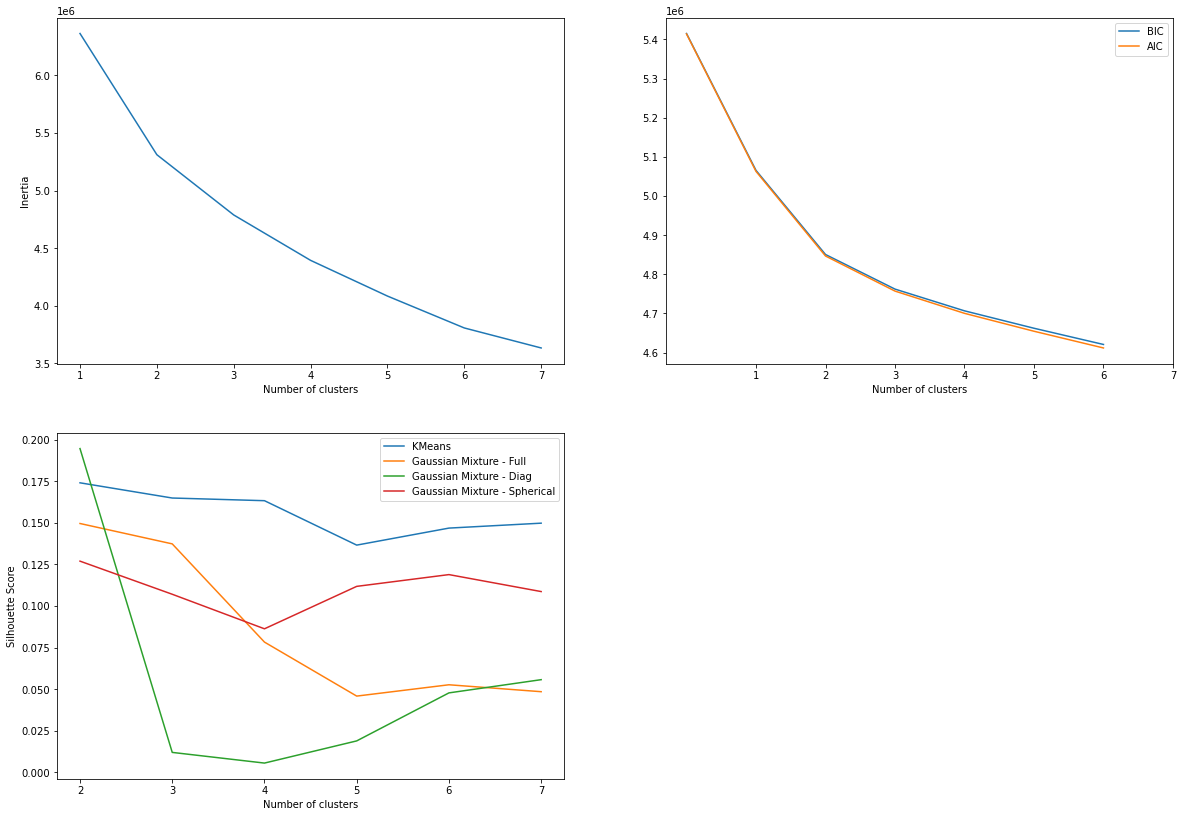

In [42]:
#Plotting the results we got:

plt.figure(figsize=(20,14))

#The inertias form the K-Means
plt.subplot(2,2, 1)
plt.plot(pd.Series(inertias, index=np.arange(1,8)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")

#The BICs and AICs of our Gaussian Mixture with type ="full"
plt.subplot(2, 2, 2)
plt.plot(bics, label="BIC")
plt.plot(aics, label="AIC")
plt.legend(loc="upper right")
plt.xlabel("Number of clusters")
plt.xticks(np.arange(1,8))

#The different S.S. for each cluster algorithm, so we can compare them
plt.subplot(2, 2, 3)
plt.plot(pd.Series(silhouette_kmeans_neigh_with_out, index=np.arange(1,8)), label="KMeans")
plt.plot(pd.Series(silhouette_gaussian_neigh_with_out_full, index=np.arange(1,8)), label="Gaussian Mixture - Full")
plt.plot(pd.Series(silhouette_gaussian_neigh_with_out_diag, index=np.arange(1,8)), label="Gaussian Mixture - Diag")
plt.plot(pd.Series(silhouette_gaussian_neigh_with_out_spherical, index=np.arange(1,8)), label="Gaussian Mixture - Spherical")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.legend(loc="upper right")

plt.show()

In [43]:
#From the analysis of the previous 3 graphs, we can clearly conclude that the ideal number of clusters is 2:
    #With the "inertia graph", we can see that 2 is the "elbow", meaning that after that value, each decrease in the number of clusters doesn't lead to as big of a difference in the inertia value, as from 1 to 2 clusters
    #From the graph representing the BIC and AIC, we can also observe that, with the same logic, 2 is the number of clusters where we can identify the "elbow" of the graph
    #Finally, by comparing the different Silhouette scores obtained for the different number of clusters for the different cluster algorithms, we can also observe that the higher values, independently of the algorithm chosen, is when the solution has 2 clusters

<b> Finding the best clustering solution </b>

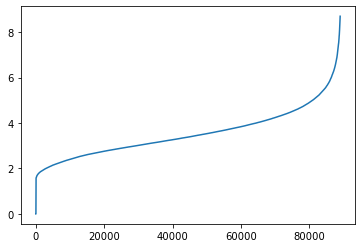

In [44]:
#Auxiliar graph to discover what value of eps to pass to DBSCAN
#We use n_neighbors =30, following the rule of thum of 2*dimension, which in this case is 15
neighbors = NearestNeighbors(n_neighbors=30)
p = neighbors.fit(pcas_neigh.loc[donors.index, pcas])
distances, disposable_variable = p.kneighbors(pcas_neigh.loc[donors.index, pcas])
distances = np.sort(distances[:, -1])
#Going until only the 89000th observation, so we can make a "zoom" and see clearly the graph
plt.plot(distances[:89000])
plt.show()

In [54]:
#Applying the DBSCAN and checking how many observations we have in each cluster
dbscan=DBSCAN(eps=4.43, min_samples=30, n_jobs=-1)
labels=dbscan.fit_predict(pcas_neigh.loc[donors.index, pcas])
#As we can see, we don't have a even distribution throughout the clusters, which although in this case produces a high silhouette score, is not translated into a "good" cluster solution
collections.Counter(labels)

Counter({0: 83588, -1: 5680, 1: 21})

In [46]:
#As expected the DBSCAN don't capture the essence of the donors (as this costumer segmentation problem is more interested in other type of clustering, namelly K-means, or SOM or even a spheric Gaussian)

In [55]:
def get_ss(df):
    """This fucntion receives a dataframe and returns its total sum of squares."""
    ss = np.sum(df.var() * (df.count() - 1))
    return ss

#Creating dictionaries to store the R2 and the SS results of our different clusters solutions
r2_neigh_with_outliers={}
ss_neigh_with_outliers={}

#Applying the K-Means, with the number we found to be the best (2)
kmeans= KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42)
labels= kmeans.fit_predict(pcas_neigh.loc[donors.index, pcas])

pcas_neigh["Labels_KMeans_Neigh"]= pd.Series(labels, index= donors.index)

#Computing the R2 for this solution: using the knowledge that Sum of Squares Total = Sum of Squares Within + Sum of Squares Between
sst = get_ss(pcas_neigh.loc[donors.index,pcas])
ssw_labels = pcas_neigh.loc[donors.index, pcas + ["Labels_KMeans_Neigh"]].groupby("Labels_KMeans_Neigh").apply(get_ss) 
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
#storing the value in our dictionary, associated to the cluster algorithm
r2_neigh_with_outliers["KMeans"]=r2

#Calculating the silhouette score and storing it
ss=silhouette_score(pcas_neigh.loc[donors.index,pcas],pcas_neigh.loc[donors.index,"Labels_KMeans_Neigh"])
ss_neigh_with_outliers["KMeans"]=ss


#Computing our DBSCAN solution, using the parameters we found previously
dbscan=DBSCAN(eps=4.43, min_samples=30, n_jobs=-1)
labels=dbscan.fit_predict(pcas_neigh.loc[donors.index, pcas])
pcas_neigh["Labels_DBSCAN_Neigh"] = pd.Series(labels, index=donors.index)

#Here we have to take into consideration taht we shouldn't use the obseravtions considered by the DBSCAN as outliers in the computation of our results
new_index= list(pcas_neigh[pcas_neigh["Labels_DBSCAN_Neigh"]!=-1].index)

#computing the R2 and stroing the result
sst = get_ss(pcas_neigh[pcas_neigh["Labels_DBSCAN_Neigh"]!=-1].loc[[i for i in donors.index if i in new_index],pcas]) 
ssw_labels = pcas_neigh[pcas_neigh["Labels_DBSCAN_Neigh"]!=-1].loc[[i for i in donors.index if i in new_index],pcas+ ["Labels_DBSCAN_Neigh"]].groupby("Labels_DBSCAN_Neigh").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_neigh_with_outliers["DBSCAN"]=r2

#computing the S.S. and storing the result
ss=silhouette_score(pcas_neigh.loc[[i for i in donors.index if i in new_index], pcas], pcas_neigh.loc[[i for i in donors.index if i in new_index],"Labels_DBSCAN_Neigh"])
ss_neigh_with_outliers["DBSCAN"]=ss


#storing the different values for covariance_type in our Gaussian Mixture model
types=["full", "diag", "spherical"]

#Obtaining a Gaussian cluster solution for each "type"
for cov_type in types:
    gaussian = GaussianMixture(n_components=2, covariance_type=cov_type, n_init=20, init_params='kmeans', random_state=42)
    labels = gaussian.fit_predict(pcas_neigh.loc[donors.index,pcas])
    pcas_neigh["Labels_Gaussian_Neigh_"+str(cov_type)]= pd.Series(labels, index=donors.index)
    
    #computing the R2 and storing it
    sst = get_ss(pcas_neigh.loc[donors.index,pcas])  # get total sum of squares
    ssw_labels = pcas_neigh.loc[donors.index,pcas + ["Labels_Gaussian_Neigh_"+str(cov_type)]].groupby("Labels_Gaussian_Neigh_"+str(cov_type)).apply(get_ss)  # compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst
    r2_neigh_with_outliers[str("Gaussian - "+str(cov_type))]=r2
    
    #computing the S.S. and storing it
    ss=silhouette_score(pcas_neigh.loc[donors.index,pcas],pcas_neigh.loc[donors.index,"Labels_Gaussian_Neigh_"+str(cov_type)])
    ss_neigh_with_outliers[str("Gaussian - "+str(cov_type))]=ss


 Training...
 random_initialization took: 0.003000 seconds
 Rough training...
 radius_ini: 25.000000 , radius_final: 4.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  5.465000, quantization error: 8.504751

 epoch: 2 ---> elapsed time:  5.587000, quantization error: 3.586328

 epoch: 3 ---> elapsed time:  5.523000, quantization error: 3.581717

 epoch: 4 ---> elapsed time:  5.526000, quantization error: 3.578409

 epoch: 5 ---> elapsed time:  5.595000, quantization error: 3.576835

 epoch: 6 ---> elapsed time:  5.577000, quantization error: 3.576075

 epoch: 7 ---> elapsed time:  5.535000, quantization error: 3.575590

 epoch: 8 ---> elapsed time:  5.657000, quantization error: 3.575207

 epoch: 9 ---> elapsed time:  5.629000, quantization error: 3.574861

 epoch: 10 ---> elapsed time:  5.580000, quantization error: 3.574520

 epoch: 11 ---> elapsed time:  5.667000, quantization error: 3.574175

 epoch: 12 ---> elapsed time:  5.914000, quantization error: 3.573817

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  6.274000, quantization error: 3.324371

 epoch: 15 ---> elapsed time:  6.489000, quantization error: 3.319919

 epoch: 16 ---> elapsed time:  6.355000, quantization error: 3.315371

 epoch: 17 ---> elapsed time:  6.500000, quantization error: 3.310737

 epoch: 18 ---> elapsed time:  5.859000, quantization error: 3.305986

 epoch: 19 ---> elapsed time:  6.390000, quantization error: 3.301126

 epoch: 20 ---> elapsed time:  6.435000, quantization error: 3.296161

 epoch: 21 ---> elapsed time:  6.327000, quantization error: 3.291113

 epoch: 22 ---> elapsed time:  6.306000, quantization error: 3.285944

 epoch: 23 ---> elapsed time:  6.444000, quantization error: 3.280671

 epoch: 24 ---> elapsed time:  6.280000, quantization error: 3.275290

 epoch: 25 ---> elapsed time:  6.450000, quantization error: 3.269744

 epoch: 26 ---> elapsed time:  6.327000, quantization error: 3.264076

 epoch: 27 ---> elapsed time:  6.433000, quantization error: 3.258299

 epoch

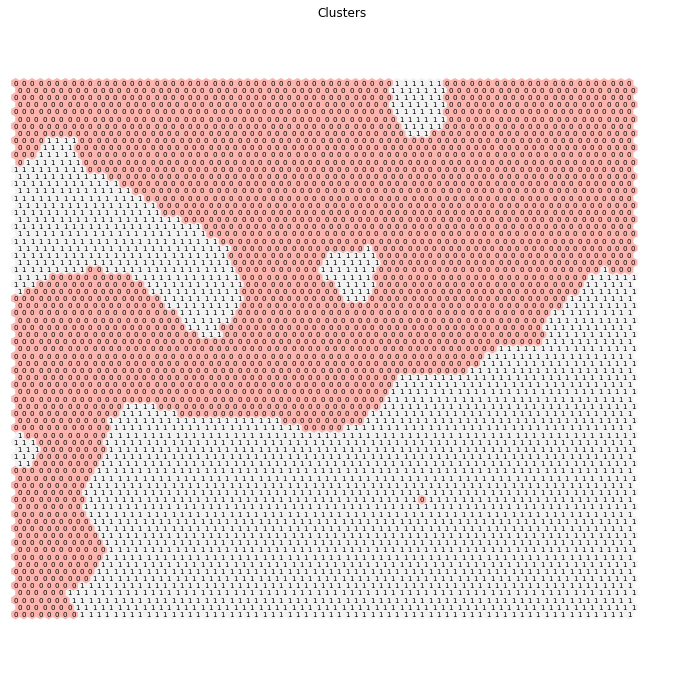

In [56]:
#Defining a random seed, as SOM does not have a random_state
np.random.seed(42)

#Creating our SOM instance and fiting it to our variables
som = sompy.SOMFactory().build(
    pcas_neigh.loc[donors.index,pcas].values, 
    mapsize=(75, 75),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=pcas
)
som.train(n_job=-1, train_rough_len=100, train_finetune_len=100)

#Obtaining a K-Means solution on top of SOM
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42)
#storing the cluster labels for each SOM unit 
labels_units = som.cluster(kmeans)

#Plotting our solution, so we can get an idea of the distribution of the clusters, which allowed us to find out that we have a lot of problems with units away from the ones from the same cluster
#This was also a reason why we decided not to use this clustering solution as our final, although it would have better visualization techniques available for it than any other clustering alternative
hits  = HitMapView(12, 12,"Clusters", text_size=20)
hits.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [57]:
#Again, even aknoledging the better vizualization tools from SOM, we will not use it as final. It gives worst scores than K-Means, while by looking at the graphical representation above we can clearly see some incosistences with the units of clustering formed by this method

In [58]:
#Creating a dataframe with the SOM units, associating each one with the label from the K-Means solution
donors_units=pd.DataFrame(som.get_node_vectors(), columns=pcas)
donors_units["Labels_units"]= labels_units

#finding to which unit each donor is associated to, adding that information to the pcas_neigh dataframe
units = som.find_bmu(pcas_neigh.loc[donors.index,pcas])
pcas_neigh["SOM_units"] = pd.Series(units[0], index=donors.index)

#Associating each donor, through the respective SOM unit, to the K-Means label
labels_cluster=[]
for value in pcas_neigh.loc[donors.index,"SOM_units"].values:
    labels_cluster.append(donors_units.loc[value,"Labels_units"])

#storing our findings in pcas_neigh dataframe
pcas_neigh["Labels_SOM_KMeans_Neigh"]=pd.Series(labels_cluster, index=donors.index)

#Dropping the column SOM_units, as its purpose was to help us connect each observation to its unit and therefore to its cluster. Now that that it's done, we can drop it.
pcas_neigh.drop("SOM_units", axis=1, inplace=True)

#computing the R2 of this solution and storing it
sst = get_ss(pcas_neigh.loc[donors.index,pcas]) 
ssw_labels = pcas_neigh.loc[donors.index,pcas + ["Labels_SOM_KMeans_Neigh"]].groupby("Labels_SOM_KMeans_Neigh").apply(get_ss) 
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_neigh_with_outliers["SOM+KMeans"]=r2

#computing the S.S. and storing it
ss=silhouette_score(pcas_neigh.loc[donors.index,pcas],pcas_neigh.loc[donors.index,"Labels_SOM_KMeans_Neigh"])
ss_neigh_with_outliers["SOM+KMeans"]=ss

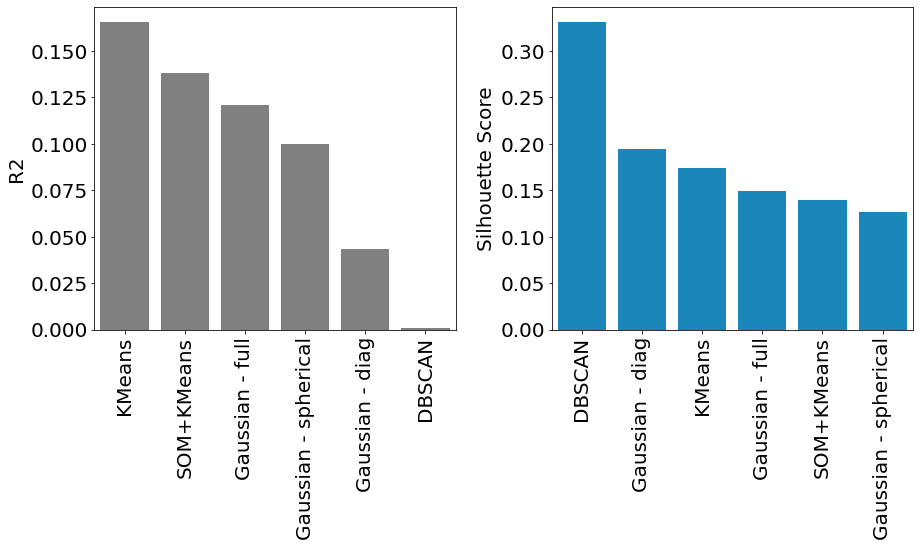

In [59]:
#Plotting our results

plt.figure(figsize=(13,8))

#Plotting the R2 for the different solutions 
plt.subplot(1, 2, 1)
df=pd.DataFrame({"R2":list(r2_neigh_with_outliers.values())}, index=list(r2_neigh_with_outliers.keys())).sort_values(by="R2",ascending=False)
sns.barplot(x=list(df.index), y="R2", data=df, color="grey", label="R2")
plt.xticks(rotation=90)

#Plotting the Silhouette scores for the different cluster solutions
plt.subplot(1, 2, 2)
df2=pd.DataFrame({"Silhouette Score":list(ss_neigh_with_outliers.values())}, index=list(ss_neigh_with_outliers.keys())).sort_values(by="Silhouette Score", ascending=False)
sns.barplot(x=list(df2.index), y="Silhouette Score", data=df2, color="#008fd5", label="Silhouette Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#deleting df and df2, as they are no longer needed, having served its purpose
del df, df2

For n_clusters = 2, the average silhouette_score is : 0.17409597103576596, with model kmeans
For n_clusters = 2, the average silhouette_score is : 0.19466852188300512, with model diag
For n_clusters = 2, the average silhouette_score is : 0.30719899180532306, with model dbscan


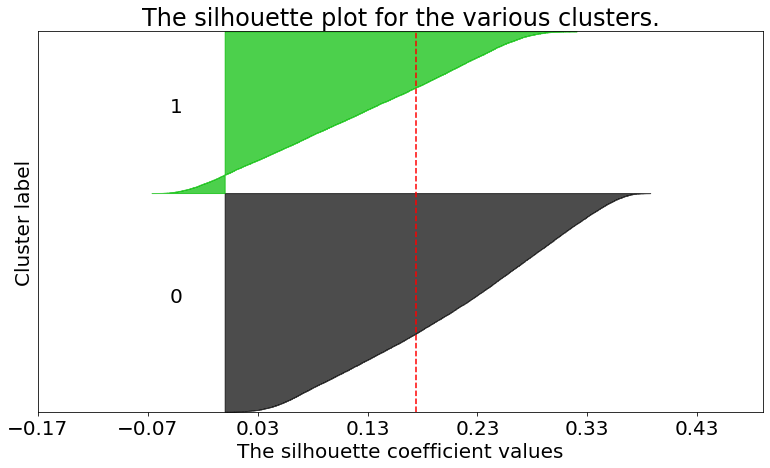

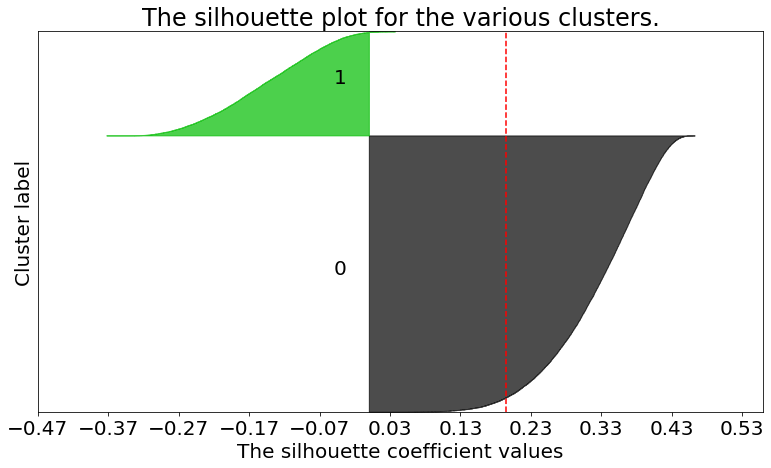

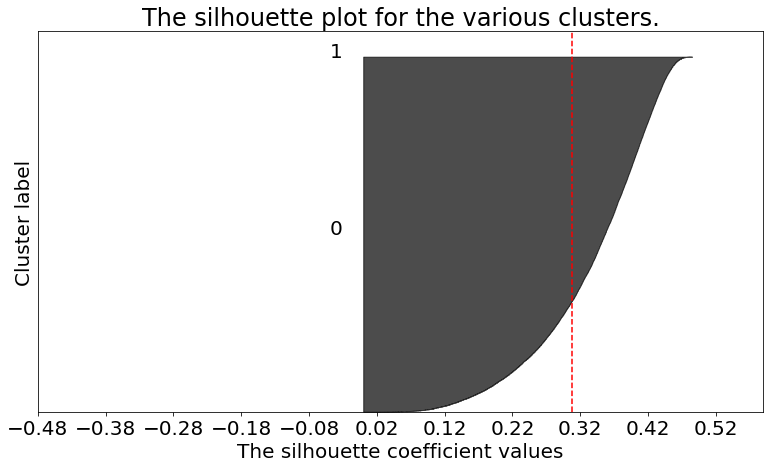

In [60]:
#We will now analyse better the Silhouette scores of our best performing clusters
# Adapted from Lab K-Means

range_clusters=[2]
avg_silhouette = []

for nclus in range_clusters:

    if nclus == 1:
        continue
    
    #We will plot for each of the models that got the best results in silhouette terms, so we can see their distribution of observations
    for model in ["kmeans", "diag", "dbscan"]:
        if model=="kmeans": 
            kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=10, random_state=42)
            cluster_labels = kmclust.fit_predict(pcas_neigh.loc[donors.index,pcas])
            
        elif model=="diag":
            gaussian=GaussianMixture(nclus, covariance_type=model, n_init=10, random_state=42)
            cluster_labels=gaussian.fit_predict(pcas_neigh.loc[donors.index,pcas])
        
        elif model=="dbscan":
            dbscan=DBSCAN(eps=4.4, min_samples=30, n_jobs=-1)
            cluster_labels=dbscan.fit_predict(pcas_neigh.loc[donors.index, pcas])
            
        fig = plt.figure(figsize=(13, 7))
    
        silhouette_avg = silhouette_score(pcas_neigh.loc[donors.index,pcas], cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}, with model {model}")

        sample_silhouette_values = silhouette_samples(pcas_neigh.loc[donors.index,pcas], cluster_labels)

        y_lower = 10
        for i in range(nclus):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10 

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
        plt.ylim([0, len(pcas_neigh.loc[donors.index,pcas]) + (nclus + 1) * 10])

        plt.yticks([])
        plt.xticks(np.arange(xmin, xmax, 0.1))
    
plt.show()

In [61]:
#We can clearly see that although the Gaussian with diagonal shape and the DBSCAN have given a best average Silhouette score, the behaviour across clusters is completly erratic, and therefore the best solution passes by the K-Means.

<b> Re-do witough the outliers given by DBSCAN </b>

In [62]:
#We will find the outliers according to the DBSCAN method
#to store the positions of the observations which are considered as outliers
positions=[]
#Going to each prediction made previously by DBSCAN and if the label corresponded to -1, we store the position of such index regarding the list of donors.index
for index, value in enumerate(pcas_neigh.loc[donors.index, "Labels_DBSCAN_Neigh"].values):
    if value == -1:
        positions.append(index)

print("This method considered", round((len(positions))/initial_nr_rows*100, 3), "% of our initial donors as outliers, in this perspective. Note that we already had", round((outliers_stored/initial_nr_rows)*100, 3), "% of our initial donors classified as general outliers by statistical/density methods, which we will add later to our analysis, as we will also add the ones from this perspective, now identified by DBSCAN.")

#Defining the indexes of the DSCAN outliers
dbscan_outliers_neigh=list(pcas_neigh.loc[donors.index].iloc[positions].index.values)
#Creating a list with the indexes form donors, which are not considered as outliers in this perspective
index_neighborhood=[index for index in donors.index if index not in dbscan_outliers_neigh]


#From here, we will repeat the same processes as before

r2_neigh_without_outliers={}
ss_neigh_without_outliers={}

#K-Means cluster solution
kmeans= KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42)
labels= kmeans.fit_predict(pcas_neigh.loc[index_neighborhood, pcas])

pcas_neigh["Labels_KMeans_Neigh"]= pd.Series(labels, index= index_neighborhood)

sst = get_ss(pcas_neigh.loc[index_neighborhood,pcas]) 
ssw_labels = pcas_neigh.loc[index_neighborhood, pcas + ["Labels_KMeans_Neigh"]].groupby("Labels_KMeans_Neigh").apply(get_ss)
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2_neigh_without_outliers["KMeans"]=r2

ss=silhouette_score(pcas_neigh.loc[index_neighborhood,pcas],pcas_neigh.loc[index_neighborhood,"Labels_KMeans_Neigh"])
ss_neigh_without_outliers["KMeans"]=ss


#DBSCAN cluster solution
dbscan=DBSCAN(eps=4.43, min_samples=30, n_jobs=-1)
labels=dbscan.fit_predict(pcas_neigh.loc[index_neighborhood, pcas])

pcas_neigh["Labels_DBSCAN_Neigh"] = pd.Series(labels, index=index_neighborhood)

#Note that here we don't need to consider the case of the outliers in the computations, as those are not included on our index_neighborhood
sst = get_ss(pcas_neigh.loc[index_neighborhood,pcas]) 
ssw_labels = pcas_neigh.loc[index_neighborhood, pcas + ["Labels_DBSCAN_Neigh"]].groupby("Labels_DBSCAN_Neigh").apply(get_ss) 
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_neigh_without_outliers["DBSCAN"]=r2

ss=silhouette_score(pcas_neigh.loc[index_neighborhood, pcas], pcas_neigh.loc[index_neighborhood,"Labels_DBSCAN_Neigh"])
ss_neigh_without_outliers["DBSCAN"]=ss



#Gaussian solutions
types=["full", "diag", "spherical"]

for cov_type in types:

    gaussian = GaussianMixture(n_components=2, covariance_type=cov_type, n_init=20, init_params='kmeans', random_state=42)
    labels = gaussian.fit_predict(pcas_neigh.loc[index_neighborhood,pcas])
    pcas_neigh["Labels_Gaussian_Neigh_"+str(cov_type)]= pd.Series(labels, index=index_neighborhood)

    sst = get_ss(pcas_neigh.loc[index_neighborhood,pcas])  
    ssw_labels = pcas_neigh.loc[index_neighborhood,pcas + ["Labels_Gaussian_Neigh_"+str(cov_type)]].groupby("Labels_Gaussian_Neigh_"+str(cov_type)).apply(get_ss)
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst
    r2_neigh_without_outliers[str("Gaussian - "+str(cov_type))]=r2

    ss=silhouette_score(pcas_neigh.loc[index_neighborhood,pcas],pcas_neigh.loc[index_neighborhood,"Labels_Gaussian_Neigh_"+str(cov_type)])
    ss_neigh_without_outliers[str("Gaussian - "+str(cov_type))]=ss

This method considered 5.953 % of our initial donors as outliers, in this perspective. Note that we already had 4.529 % of our initial donors classified as general outliers by statistical/density methods, which we will add later to our analysis, as we will also add the ones from this perspective, now identified by DBSCAN.


 Training...
 random_initialization took: 0.002000 seconds
 Rough training...
 radius_ini: 25.000000 , radius_final: 4.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  5.113000, quantization error: 5.670145

 epoch: 2 ---> elapsed time:  5.215000, quantization error: 3.693056

 epoch: 3 ---> elapsed time:  5.227000, quantization error: 3.685515

 epoch: 4 ---> elapsed time:  5.175000, quantization error: 3.683581

 epoch: 5 ---> elapsed time:  5.220000, quantization error: 3.682377

 epoch: 6 ---> elapsed time:  5.291000, quantization error: 3.681483

 epoch: 7 ---> elapsed time:  5.253000, quantization error: 3.680815

 epoch: 8 ---> elapsed time:  5.280000, quantization error: 3.680242

 epoch: 9 ---> elapsed time:  5.313000, quantization error: 3.679717

 epoch: 10 ---> elapsed time:  5.336000, quantization error: 3.679170

 epoch: 11 ---> elapsed time:  5.281000, quantization error: 3.678515

 epoch: 12 ---> elapsed time:  5.244000, quantization error: 3.677882

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  5.261000, quantization error: 3.413048

 epoch: 15 ---> elapsed time:  5.211000, quantization error: 3.408091

 epoch: 16 ---> elapsed time:  5.234000, quantization error: 3.403031

 epoch: 17 ---> elapsed time:  5.237000, quantization error: 3.397871

 epoch: 18 ---> elapsed time:  5.236000, quantization error: 3.392598

 epoch: 19 ---> elapsed time:  5.241000, quantization error: 3.387204

 epoch: 20 ---> elapsed time:  5.298000, quantization error: 3.381697

 epoch: 21 ---> elapsed time:  5.237000, quantization error: 3.376067

 epoch: 22 ---> elapsed time:  5.300000, quantization error: 3.370312

 epoch: 23 ---> elapsed time:  5.296000, quantization error: 3.364408

 epoch: 24 ---> elapsed time:  5.245000, quantization error: 3.358367

 epoch: 25 ---> elapsed time:  5.227000, quantization error: 3.352182

 epoch: 26 ---> elapsed time:  5.262000, quantization error: 3.345827

 epoch: 27 ---> elapsed time:  5.293000, quantization error: 3.339283

 epoch

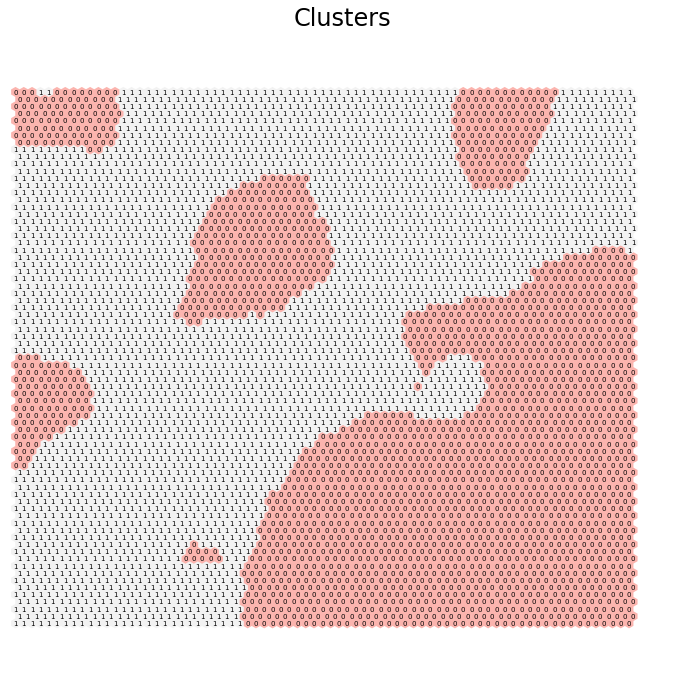

In [63]:
#SOM solution. Again, the same process as before
np.random.seed(42)

som = sompy.SOMFactory().build(
    pcas_neigh.loc[index_neighborhood,pcas].values, 
    mapsize=(75, 75),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=pcas
)
som.train(n_job=-1, train_rough_len=100, train_finetune_len=100)

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42)
labels_units = som.cluster(kmeans)

#As before, the same pattern is reapeated:
#Plotting our solution, so we can get an idea of the distribution of the clusters, which allowed us to find out that we have a lot of problems with units away from the ones from the same cluster
#This was also a reason why we decided not to use this clustering solution as our final, although it would have better visualization techniques available for it than any other clustering alternative

hits  = HitMapView(12, 12,"Clusters", text_size=20)
hits.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [64]:
#Same reasoning as before to not use SOM

In [65]:
#We apply the same steps as before, in order to find out to each cluster each observation belongs to
donors_units=pd.DataFrame(som.get_node_vectors(), columns=pcas)
donors_units["Labels_units"]= labels_units

units = som.find_bmu(pcas_neigh.loc[index_neighborhood,pcas])
pcas_neigh["SOM_units"] = pd.Series(units[0], index=index_neighborhood)

labels_cluster=[]
for value in pcas_neigh.loc[index_neighborhood,"SOM_units"].values:
    labels_cluster.append(donors_units.loc[value,"Labels_units"])

pcas_neigh["Labels_SOM_KMeans_Neigh"]=pd.Series(labels_cluster, index=index_neighborhood)

pcas_neigh.drop("SOM_units", axis=1, inplace=True)

sst = get_ss(pcas_neigh.loc[index_neighborhood,pcas])  
ssw_labels = pcas_neigh.loc[index_neighborhood,pcas + ["Labels_SOM_KMeans_Neigh"]].groupby("Labels_SOM_KMeans_Neigh").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_neigh_without_outliers["SOM+KMeans"]=r2

ss=silhouette_score(pcas_neigh.loc[index_neighborhood,pcas],pcas_neigh.loc[index_neighborhood,"Labels_SOM_KMeans_Neigh"])
ss_neigh_without_outliers["SOM+KMeans"]=ss

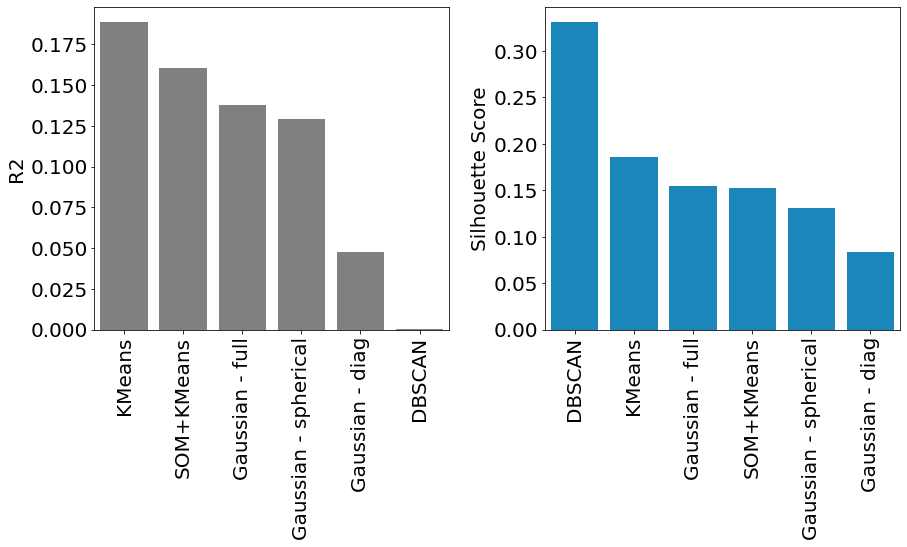

In [66]:
#Plotting our results

plt.figure(figsize=(13,8))

#plotting our R2 results for each solution
plt.subplot(1, 2, 1)
df=pd.DataFrame({"R2":list(r2_neigh_without_outliers.values())}, index=list(r2_neigh_without_outliers.keys())).sort_values(by="R2",ascending=False)
sns.barplot(x=list(df.index), y="R2", data=df, color="grey", label="R2")
plt.xticks(rotation=90)

#Ploting our S.S. results for each solution
plt.subplot(1, 2, 2)
df2=pd.DataFrame({"Silhouette Score":list(ss_neigh_without_outliers.values())}, index=list(ss_neigh_without_outliers.keys())).sort_values(by="Silhouette Score", ascending=False)
sns.barplot(x=list(df2.index), y="Silhouette Score", data=df2, color="#008fd5", label="Silhouette Score")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#deleting df and df2, as they are no longer needed, in order to save up memory space
del df, df2

<b> Feature selection for the clustering perspective </b>

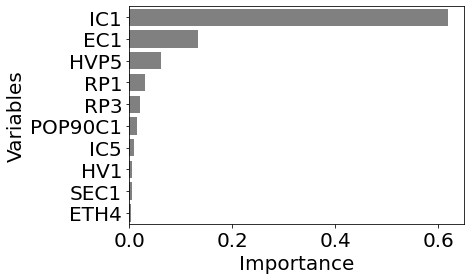

In [67]:
#We will use a decision tree in order to get the features who are considered to be more important in the descrimination between labels, in our cluster solution.
#In addition, we will also calculate the R2 for each variable, in order to see which ones have a higgher value than 5%

#Creating the Decision Tree Classifier, fiting it to our neighborhood variables (here it wouldn't make sense to fit to our PCA variables)
dt=DecisionTreeClassifier(random_state=42)
dt.fit(X=donors.loc[index_neighborhood,neighborhood], y=pcas_neigh.loc[index_neighborhood,"Labels_KMeans_Neigh"])


def get_ss_variables(df):
    """This fucntion receives a dataframe and computes the R2 for each variable there contained."""
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

#Storing our labels in our donors dataframe, so then we can acess the neighbrohood variables
donors["Labels_KMeans_Neigh"]=pd.Series(pcas_neigh.loc[index_neighborhood,"Labels_KMeans_Neigh"].values, index=index_neighborhood)

#Calculating the R2 for each variable from the neighbrohood perspective, in our donors dataframe 
sst_vars=get_ss_variables(donors.loc[index_neighborhood,neighborhood])
ssw_vars=np.sum(donors.loc[index_neighborhood,neighborhood+["Labels_KMeans_Neigh"]].groupby("Labels_KMeans_Neigh").apply(get_ss_variables))
r2_vars=(1-(ssw_vars/sst_vars)).drop("Labels_KMeans_Neigh")

#Finding which variables present an R2 higher than 5%
r2_higher=list(r2_vars[r2_vars>0.05].index)

#Using the Selector From Model to retrieve the variables that according to our decision tree have an importance higher than the mean one
selector=SelectFromModel(dt,  threshold= "mean").fit(X=donors.loc[index_neighborhood,neighborhood], y=pcas_neigh.loc[index_neighborhood,"Labels_KMeans_Neigh"])
selector_vars=(list(np.array(neighborhood)[selector.get_support()]))

#Storing the variables which are selected by our selector or that have a R2 higher than 5%
new_neighborhood=list(set(selector_vars + r2_higher))

#Plotting the 10 most important features according to our decision tree
impo=pd.DataFrame(dt.feature_importances_, columns=["Importance"])
impo["Variables"]=neighborhood
impo.sort_values(by="Importance",ascending = False, inplace = True)
sns.barplot(y='Variables', x='Importance', data=impo[:10], color = "grey")
plt.show()

In [68]:
#Dropping the columns where we stores the labels from our cluster solutions, as they will no longer be needed
pcas_neigh.drop([col for col in pcas_neigh.columns if "Label" in col], inplace=True, axis=1)

<b> Re-do the PCA with a lower dimension input space, with 2 clusters, without the new DBSCAN outliers and using K-Means </b>

In [69]:
#We repeat the process from before, but fit to the new_neighborhood variables
pca = PCA()
pca.fit_transform(donors.loc[index_neighborhood, new_neighborhood])
pd.DataFrame(data=[pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_], columns=np.arange(1,pca.n_components_+1), index=["Proportion", "Cumulative Propotion", "Eigenvalues"]).T.iloc[0: 20, :]

Proportion  Cumulative Propotion  Eigenvalues
1     0.315615              0.315615    15.880536
2     0.079444              0.395059     3.997333
3     0.074027              0.469086     3.724756
4     0.058990              0.528076     2.968150
5     0.039966              0.568042     2.010922
6     0.031080              0.599122     1.563830
7     0.026056              0.625178     1.311020
8     0.024570              0.649748     1.236269
9     0.019637              0.669385     0.988040
10    0.019222              0.688606     0.967176
11    0.017674              0.706280     0.889281
12    0.016511              0.722791     0.830776
13    0.015971              0.738763     0.803617
14    0.014477              0.753240     0.728423
15    0.013892              0.767132     0.698983
16    0.012683              0.779815     0.638170
17    0.012315              0.792130     0.619667
18    0.011720              0.803850     0.589696
19    0.011406              0.815256     0.573923
20    0.011219              0.826475     0.564499

In [70]:
#we will keep 6 components, in order to keep around 60%, as we are only interested in getting a geral idea of the environment each donor is inserted in
pca = PCA(n_components=6)
pca.fit(donors.loc[index_neighborhood, new_neighborhood])

pcas=[]
for num in range(1,pca.n_components_+1):
    pcas.append("PCA "+str(num)+ " Neighborhood")

#Same as before, but now we also have to deal with the outliers from this perspective    
neigh_no_outliers_new=pd.DataFrame(pca.transform(donors.loc[index_neighborhood, new_neighborhood]), index= index_neighborhood, columns=pcas)
neigh_outliers_new=pd.DataFrame(pca.transform(donors.loc[dbscan_outliers_neigh, new_neighborhood]), index= dbscan_outliers_neigh, columns=pcas)
neigh_outliers_geral_new=pd.DataFrame(pca.transform(df_outliers[new_neighborhood]), index= df_outliers.index, columns=pcas)

#Joining all the dataframes
pcas_neigh_new=pd.concat([neigh_no_outliers_new,neigh_outliers_new,neigh_outliers_geral_new])

#dropping the dataframes joined, as we will no longer use them
del neigh_no_outliers_new, neigh_outliers_new, neigh_outliers_geral_new

correlation=pd.concat([donors.loc[index_neighborhood, new_neighborhood], pcas_neigh_new.loc[index_neighborhood]], axis=1, sort=False).corr().loc[pcas, new_neighborhood]
correlation.style.applymap(conditional_coloring)

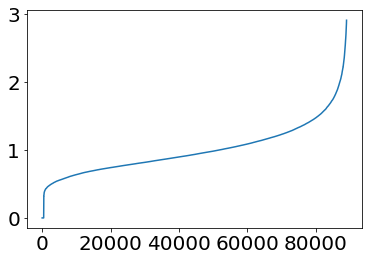

In [71]:
#Doing the same as before, but here we have 6 components, and tehrefore, we use n_neighbors=12
neighbors = NearestNeighbors(n_neighbors=12)
p = neighbors.fit(pcas_neigh_new.loc[donors.index,pcas])
distances, disposable_variable = p.kneighbors(pcas_neigh_new.loc[donors.index,pcas])
distances = np.sort(distances[:, -1])
plt.plot(distances[:89000])
plt.show()

In [75]:
#checking our solution
dbscan=DBSCAN(eps=1.95, min_samples=12, n_jobs=-1)
labels=dbscan.fit_predict(pcas_neigh_new.loc[donors.index,pcas])
np.unique(labels)

array([-1,  0,  1], dtype=int64)

In [ ]:
#Same reason as before for DBSCAN not being good

In [76]:
#Using DSCAN to obtain the outliers, as now they can be different, given that our input space changed. We repeat the process from before, with the only change that here we first need to compute the labels from this cluster solution.
dbscan=DBSCAN(eps=1.95, min_samples=12, n_jobs=-1)
labels=dbscan.fit_predict(pcas_neigh_new.loc[donors.index,pcas])

pcas_neigh_new["Labels_DBSCAN_Neigh"]=pd.Series(labels, index=donors.index)

positions=[]
for index, value in enumerate(pcas_neigh_new.loc[donors.index, "Labels_DBSCAN_Neigh"].values):
    if value == -1:
        positions.append(index)

print("This method considered", round((len(positions))/initial_nr_rows*100, 3), "% of our initial donors as outliers, in this perspective. Note that we already have", round((outliers_stored/initial_nr_rows)*100, 3), "% of our original donors classified as general outliers by statistical/density methods, which we will add later to our analysis, as will also add the ones from this perspective, now identified by DBSCAN.")
        
#Reaching the new outliers and non-outliers from this perspective    
dbscan_outliers_neigh=list(pcas_neigh_new.loc[donors.index].iloc[positions].index.values)
index_neighborhood=[index for index in donors.index if index not in dbscan_outliers_neigh]

This method considered 1.05 % of our initial donors as outliers, in this perspective. Note that we already have 4.529 % of our original donors classified as general outliers by statistical/density methods, which we will add later to our analysis, as will also add the ones from this perspective, now identified by DBSCAN.


In [77]:
#Computing the K-Means solution, as this was the best model previously
kmeans= KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42)

labels= kmeans.fit_predict(pcas_neigh_new.loc[index_neighborhood, pcas])
pcas_neigh_new["Labels_KMeans_Neigh"]= pd.Series(labels, index= index_neighborhood)

#Computing the R2 and the Silhouette score
sst = get_ss(pcas_neigh_new.loc[index_neighborhood,pcas])  # get total sum of squares
ssw_labels = pcas_neigh_new.loc[index_neighborhood, pcas + ["Labels_KMeans_Neigh"]].groupby("Labels_KMeans_Neigh").apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
ss=silhouette_score(pcas_neigh_new.loc[index_neighborhood,pcas],pcas_neigh_new.loc[index_neighborhood,"Labels_KMeans_Neigh"])

print("Using KMeans, the R2 is", round(r2,3), ", while the Silhouette Score is now", round(ss,3))

#Dropping the column used to store the labels of DBSCAN previously, as it is no longer needed
pcas_neigh_new.drop("Labels_DBSCAN_Neigh", axis=1, inplace=True)

Using KMeans, the R2 is 0.35 , while the Silhouette Score is now 0.316


In [78]:
#checking the differences in mean for the clusters obtained
pcas_neigh_new.loc[index_neighborhood].groupby("Labels_KMeans_Neigh").mean()

PCA 1 Neighborhood  PCA 2 Neighborhood  \
Labels_KMeans_Neigh                                           
0.0                            3.973543            0.239802   
1.0                           -2.771150            0.030112   

                     PCA 3 Neighborhood  PCA 4 Neighborhood  \
Labels_KMeans_Neigh                                           
0.0                           -0.045847            0.055526   
1.0                            0.190570            0.043942   

                     PCA 5 Neighborhood  PCA 6 Neighborhood  
Labels_KMeans_Neigh                                          
0.0                           -0.026435            0.083120  
1.0                           -0.010022           -0.013264

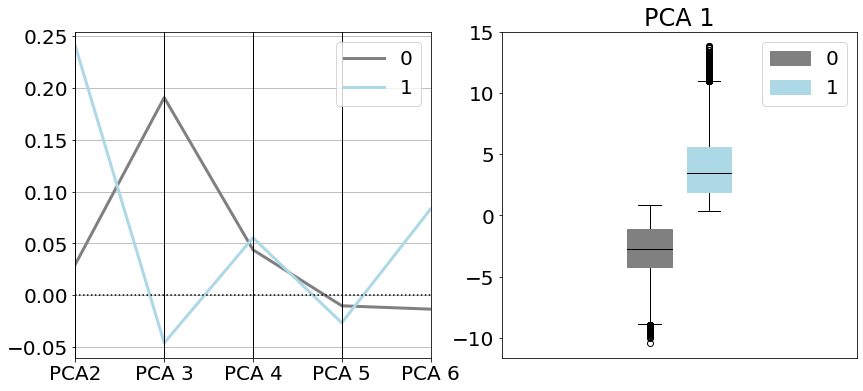

<Figure size 432x288 with 0 Axes>

In [82]:
#Plotting the differences in mean between the clusters, for the different variables -PCAs-, except for PCA1, for which we plot its distribution
plt.figure(figsize=(14,6))

#Plotting each PCA, except the first one, as for scaling reasons, it has to be plotted separately, in order for the remaining differences to be notable
plt.subplot(1, 2, 1)
centroids=pcas_neigh_new.loc[index_neighborhood, [col for col in pcas if "PCA 1" not in col] + ["Labels_KMeans_Neigh"]].groupby(by="Labels_KMeans_Neigh", as_index=False).mean()
centroids["Labels_KMeans_Neigh"]=[0,1]
centroids.columns=["Labels_KMeans_Neigh", "PCA2", "PCA 3", "PCA 4", "PCA 5", "PCA 6"]
pd.plotting.parallel_coordinates(centroids, "Labels_KMeans_Neigh", color=["grey","lightblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')

#Plotting a boxplot to access the distribution of PCA1's values
plt.subplot(1, 2, 2)
plt.title("PCA 1")
plt.boxplot(pcas_neigh_new[pcas_neigh_new["Labels_KMeans_Neigh"]==0]["PCA 1 Neighborhood"], positions=np.arange(1), patch_artist=True,boxprops=dict(facecolor="grey", color="grey"), medianprops=dict(color="black"))
plt.boxplot(pcas_neigh_new[pcas_neigh_new["Labels_KMeans_Neigh"]==1]["PCA 1 Neighborhood"], positions=np.arange(1)+0.2, patch_artist=True,boxprops=dict(facecolor="lightblue", color="lightblue"), medianprops=dict(color="black"))
grey_patch = mpatches.Patch(color='grey', label='0')
blue_patch = mpatches.Patch(color='lightblue', label='1')
plt.legend(handles=[grey_patch, blue_patch], loc="upper right")
plt.xticks([])
plt.show()

plt.tight_layout()
plt.show()

#deleting the centoids variable, as it was used to help us plot the results
del centroids

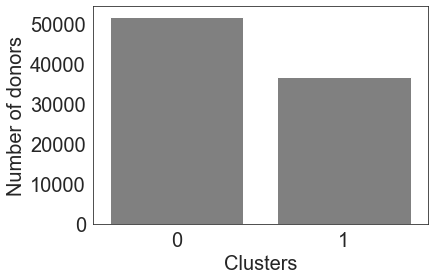

In [83]:
#Plotting the distribution of the number of observations per cluster
sns.set_style("white")

countplot=sns.countplot(x="Labels_KMeans_Neigh", data=pd.DataFrame(pcas_neigh_new[(pcas_neigh_new["Labels_KMeans_Neigh"]==1.0) | (pcas_neigh_new["Labels_KMeans_Neigh"]==0.0)]["Labels_KMeans_Neigh"].astype(int)), palette=["grey", "grey"])
countplot.set(xlabel="Clusters", ylabel = "Number of donors")
plt.yticks(np.arange(0, 60000, 10000))
plt.show()

#deleting this variable, as it was to help us plot, so it is no longer needed
del countplot

In [84]:
#Note: Altought we set random_state, T-SNE vizualization for some reason change when we run it (the conclusions are the same, but the plot themselves suffer some modifications)

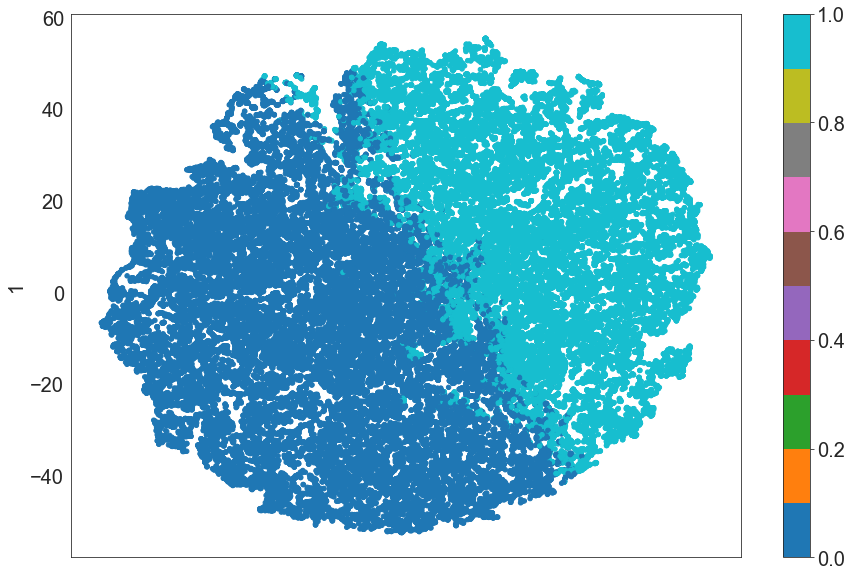

In [85]:
# Performing a t-SNE visualization, to see the distribution of our cluster solution
two_dim = TSNE(random_state=42).fit_transform(pcas_neigh_new.loc[index_neighborhood, pcas])
sns.set_style("white")
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=pcas_neigh_new.loc[index_neighborhood, "Labels_KMeans_Neigh"], colormap='tab10', figsize=(15,10))
plt.show()

<b> Adding the perspective outliers back, with the proper prediction </b>

In [86]:
#We will use a decision tree to classify the obervations considered as outliers in this perspective.

#First, we split our data into train and test, using our pcas, and our labels from K-Means, as x and y, respectively
X_train, X_test, y_train, y_test = train_test_split(pcas_neigh_new.loc[index_neighborhood, pcas], pcas_neigh_new.loc[index_neighborhood, "Labels_KMeans_Neigh"], test_size=0.3, random_state=42)

#Creating the decision tree and fitting it to our X_train and y_train
decision_tree= DecisionTreeClassifier(random_state=42, max_depth=3)
decision_tree.fit(X_train, y_train)
print("On average, we will allocate our donors to the correct clusters", round(decision_tree.score(X_test, y_test)*100, 3), "% of the times.")

#Predicting the entries contained in the dbscan_outliers_neigh list
pred=pd.Series(decision_tree.predict(pcas_neigh_new.loc[dbscan_outliers_neigh, pcas]), index=dbscan_outliers_neigh)
pcas_neigh_new.loc[dbscan_outliers_neigh,"Labels_KMeans_Neigh"]=pred

#Computing the S.S. of our solution, including now the outliers from this perspective
ss=silhouette_score(pcas_neigh_new.loc[index_neighborhood+dbscan_outliers_neigh,pcas],pcas_neigh_new.loc[index_neighborhood+dbscan_outliers_neigh,"Labels_KMeans_Neigh"])

#Computing the R2 of our solution, including now the outliers form this perspective
sst = get_ss(pcas_neigh_new.loc[index_neighborhood+dbscan_outliers_neigh,pcas])  # get total sum of squares
ssw_labels = pcas_neigh_new.loc[index_neighborhood+dbscan_outliers_neigh, pcas + ["Labels_KMeans_Neigh"]].groupby("Labels_KMeans_Neigh").apply(get_ss)
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst

print("Now, after joining the outliers from this perspective, the Silhouette score is", round(ss,3), ", while the R2 is", round(r2,3))

#Checking the difference in means for each variable, now joining the outliers from this perspective
pcas_neigh_new.loc[index_neighborhood+dbscan_outliers_neigh , pcas + ["Labels_KMeans_Neigh"]].groupby("Labels_KMeans_Neigh").mean()

On average, we will allocate our donors to the correct clusters 99.539 % of the times.
Now, after joining the outliers from this perspective, the Silhouette score is 0.313 , while the R2 is 0.345


PCA 1 Neighborhood  PCA 2 Neighborhood  \
Labels_KMeans_Neigh                                           
0.0                           -2.772658            0.055796   
1.0                            3.997009            0.292012   

                     PCA 3 Neighborhood  PCA 4 Neighborhood  \
Labels_KMeans_Neigh                                           
0.0                            0.214238            0.041639   
1.0                            0.010188            0.046470   

                     PCA 5 Neighborhood  PCA 6 Neighborhood  
Labels_KMeans_Neigh                                          
0.0                           -0.006908           -0.008809  
1.0                            0.007886            0.096235

<b> 6) Clustering: Personal/Individual Perspective

In [87]:
#We repeat the process we did before, but now we use the variables personal to fit to our PCA instance
pca = PCA()
pca.fit_transform(donors[personal])
pd.DataFrame(data=[pca.explained_variance_ratio_, np.cumsum(pca.explained_variance_ratio_), pca.explained_variance_], columns=np.arange(1,pca.n_components_+1), index=["Proportion", "Cumulative Propotion", "Eigenvalues"]).T.iloc[0: 20, :]

Proportion  Cumulative Propotion  Eigenvalues
1     0.166382              0.166382     4.325983
2     0.124463              0.290846     3.236086
3     0.073627              0.364472     1.914319
4     0.053767              0.418239     1.397954
5     0.045702              0.463941     1.188268
6     0.044015              0.507956     1.144399
7     0.042466              0.550422     1.104133
8     0.040552              0.590975     1.054370
9     0.039345              0.630319     1.022970
10    0.038354              0.668673     0.997208
11    0.037624              0.706297     0.978243
12    0.035165              0.741462     0.914302
13    0.034472              0.775934     0.896282
14    0.032806              0.808740     0.852956
15    0.032492              0.841232     0.844804
16    0.029608              0.870840     0.769821
17    0.028198              0.899038     0.733159
18    0.027028              0.926067     0.702748
19    0.018306              0.944373     0.475959
20    0.014611              0.958983     0.379877

In [88]:
#We will keep 14 components, as to retain around 80% of the variability, as here we don't want just to get an general idea as before
#Besides this, we keep the same steps as we did for the nerighbrohood perspective
pca = PCA (n_components=14)
pca.fit(donors[personal])

pcas=[]
for num in range(1, pca.n_components_+1):
    pcas.append("PCA "+str(num)+ " Personal")

personal_no_outliers=pd.DataFrame(pca.transform(donors[personal]), index= donors.index, columns=pcas)
personal_outliers=pd.DataFrame(pca.transform(df_outliers[personal]), index= df_outliers.index, columns=pcas)

pcas_personal=pd.concat([personal_no_outliers, personal_outliers])

del personal_no_outliers, personal_outliers

correlation=pd.concat([donors[personal], pcas_personal.loc[donors.index]], axis=1, sort=False).corr().loc[pcas, personal]

correlation.style.applymap(conditional_coloring)

<b> Finding the number of clusters </b>

In [89]:
#We utilize the exact same methods to find the optimal number of clusters in this perspective, as did for the neighborhood one.

inertias=[]
bics=[]
aics=[]
silhouette_kmeans_personal_with_out={}
silhouette_gaussian_personal_with_out_full={}
silhouette_gaussian_personal_with_out_diag={}
silhouette_gaussian_personal_with_out_spherical={}

for nr_clusters in range(1,8):
    kmeans= KMeans(n_clusters=(nr_clusters), init="k-means++", n_init=10, random_state=42)
    labels= kmeans.fit_predict(pcas_personal.loc[donors.index, pcas])
    pcas_personal["Labels_KMeans"]= pd.Series(labels, index= donors.index)
    inertias.append(kmeans.inertia_)
    
    if nr_clusters!=1:
        ss=silhouette_score(pcas_personal.loc[donors.index,pcas],pcas_personal.loc[donors.index,"Labels_KMeans"])
        silhouette_kmeans_personal_with_out[nr_clusters]=ss
    
    for type_cov in ["full", "diag", "spherical"]:
        gaussian=GaussianMixture(nr_clusters, covariance_type=type_cov, n_init=10, random_state=42).fit(pcas_personal.loc[donors.index,pcas])
        
        labels = gaussian.fit_predict(pcas_personal.loc[donors.index,pcas])
    
        pcas_personal["Labels_Gaussian"]= pd.Series(labels, index=donors.index)
    
        if nr_clusters!=1:
            ss=silhouette_score(pcas_personal.loc[donors.index,pcas],pcas_personal.loc[donors.index,"Labels_Gaussian"])
        
            if type_cov=="full":
                silhouette_gaussian_personal_with_out_full[nr_clusters]=ss
        
            elif type_cov=="diag":
                silhouette_gaussian_personal_with_out_diag[nr_clusters]=ss
        
            elif type_cov=="spherical":
                silhouette_gaussian_personal_with_out_spherical[nr_clusters]=ss
        

        if type_cov=="full":
            bics.append(gaussian.bic(pcas_personal.loc[donors.index,pcas]))
            aics.append(gaussian.aic(pcas_personal.loc[donors.index,pcas]))   

pcas_personal.drop(["Labels_Gaussian","Labels_KMeans"], axis=1, inplace=True)

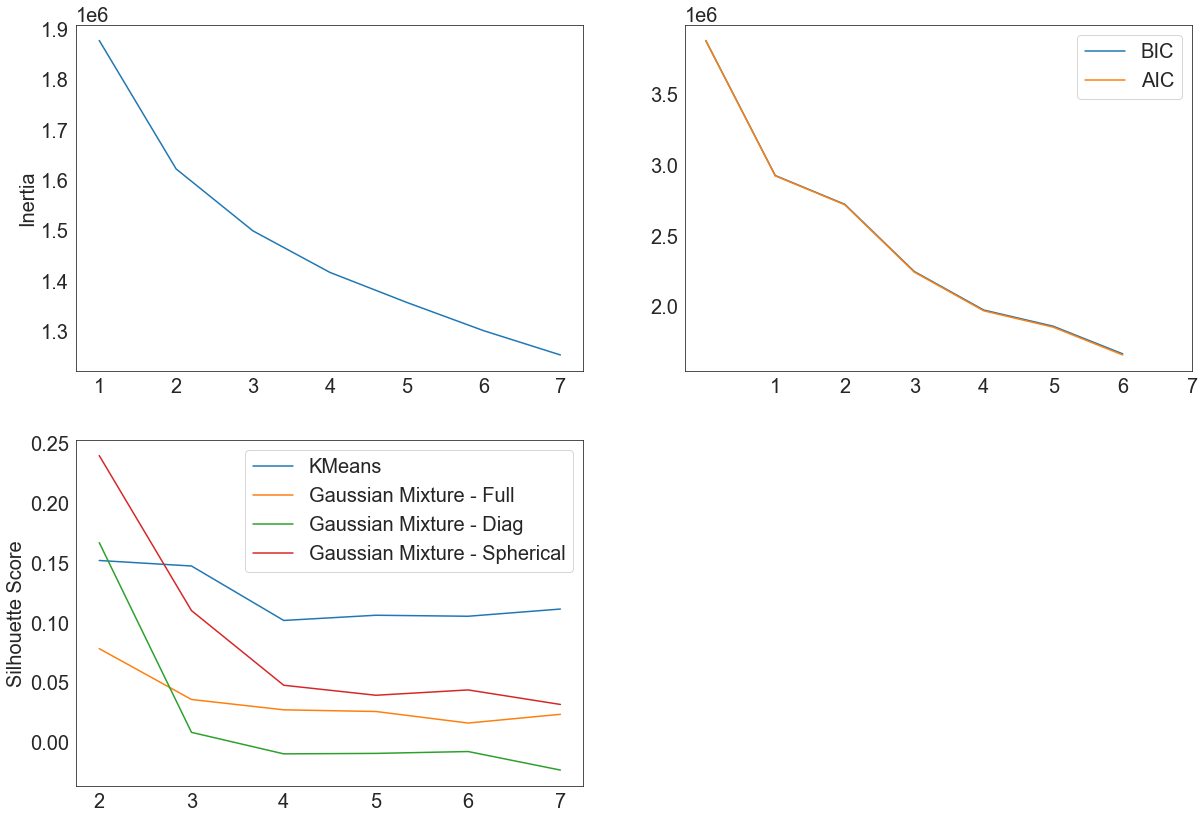

In [90]:
#Plotting our results, exactly the same way as before

plt.figure(figsize=(20,14))

plt.subplot(2,2, 1)
plt.plot(pd.Series(inertias, index=np.arange(1,8)))
plt.ylabel("Inertia")

plt.subplot(2, 2, 2)
plt.plot(bics, label="BIC")
plt.plot(aics, label="AIC")
plt.legend(loc="upper right")
plt.xticks(np.arange(1,8))

plt.subplot(2, 2, 3)
plt.plot(pd.Series(silhouette_kmeans_personal_with_out, index=np.arange(1,8)), label="KMeans")
plt.plot(pd.Series(silhouette_gaussian_personal_with_out_full, index=np.arange(1,8)), label="Gaussian Mixture - Full")
plt.plot(pd.Series(silhouette_gaussian_personal_with_out_diag, index=np.arange(1,8)), label="Gaussian Mixture - Diag")
plt.plot(pd.Series(silhouette_gaussian_personal_with_out_spherical, index=np.arange(1,8)), label="Gaussian Mixture - Spherical")
plt.ylabel("Silhouette Score")
plt.legend(loc="upper right")

plt.show()

<b> Finding the best clustering solution </b>

In [91]:
#The interpretation is pretty much the same as before: the silhuete score all "mainly agree" in 2 clusters. The elbow method also suggests 2 as being the best number (the 3 also seems a "candidate", but the silhueete graphical representations, not included here, shows that the clusters formed with 3 are uneven and with a silhuute score of one cluster being below the average), and the AIC and BIC altough not as clear, but we will follow with the 2, due to their decrese in silhuete score when going from 2 to 3

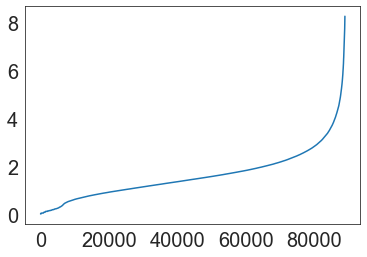

In [92]:
#Finding the best parameters for the DBSCAN solution, as we did before
#Here, we use n_neighbors=28, as we have 14 components
neighbors = NearestNeighbors(n_neighbors=28)
p = neighbors.fit(pcas_personal.loc[donors.index, pcas])
distances, disposable_variable = p.kneighbors(pcas_personal.loc[donors.index, pcas])
distances = np.sort(distances[:, -1])
plt.plot(distances[:89000])
plt.show()

In [95]:
dbscan=DBSCAN(eps=2.5, min_samples=28, n_jobs=-1)
labels=dbscan.fit_predict(pcas_personal.loc[donors.index, pcas])
collections.Counter(labels)
#Once more, we can see that the distribution of the observations by the different clusters is not even, and therefore this cluster solution will achieve a higher value for the Silhouette Score, although the interpretability of this solution, and consequently, its "goodness", are very bad

Counter({0: 82733, -1: 6527, 1: 29})

In [96]:
#Same reasoning as before to the DBSCAN

In [97]:
#We use the same cluster algorithms to get our cluster solutions and store the results, as we did previosuly
#We will use the number of clusters as 2, as that was the best one according to our previous analysis

r2_personal_with_outliers={}
ss_personal_with_outliers={}

#KMeans cluster solution
kmeans= KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42)
labels= kmeans.fit_predict(pcas_personal.loc[donors.index, pcas])

pcas_personal["Labels_KMeans_Personal"]= pd.Series(labels, index= donors.index)

sst = get_ss(pcas_personal.loc[donors.index,pcas]) 
ssw_labels = pcas_personal.loc[donors.index, pcas + ["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_personal_with_outliers["KMeans"]=r2

ss=silhouette_score(pcas_personal.loc[donors.index,pcas],pcas_personal.loc[donors.index,"Labels_KMeans_Personal"])
ss_personal_with_outliers["KMeans"]=ss


#DBSCAN cluster solution.
#Note that here we use min_samples=28, due to having 14 components
dbscan=DBSCAN(eps=2.5, min_samples=28, n_jobs=-1)
labels=dbscan.fit_predict(pcas_personal.loc[donors.index, pcas])

pcas_personal["Labels_DBSCAN_Personal"] = pd.Series(labels, index=donors.index)

#Once more, we have to take into consideration the outliers defined by DBSCAN
new_index= list(pcas_personal[pcas_personal["Labels_DBSCAN_Personal"]!=-1].index)

sst = get_ss(pcas_personal[pcas_personal["Labels_DBSCAN_Personal"]!=-1].loc[[i for i in donors.index if i in new_index],pcas]) 
ssw_labels = pcas_personal[pcas_personal["Labels_DBSCAN_Personal"]!=-1].loc[[i for i in donors.index if i in new_index],pcas + ["Labels_DBSCAN_Personal"]].groupby("Labels_DBSCAN_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst
r2_personal_with_outliers["DBSCAN"]=r2

ss=silhouette_score(pcas_personal.loc[[i for i in donors.index if i in new_index], pcas], pcas_personal.loc[[i for i in donors.index if i in new_index],"Labels_DBSCAN_Personal"])
ss_personal_with_outliers["DBSCAN"]=ss


#Gaussian solution for the 3 types of covariance_type's
types=["full", "diag", "spherical"]

for cov_type in types:
    gaussian = GaussianMixture(n_components=2, covariance_type=cov_type, n_init=20, init_params='kmeans', random_state=42)
    labels = gaussian.fit_predict(pcas_personal.loc[donors.index,pcas])
    pcas_personal["Labels_Gaussian_Personal_"+str(cov_type)]= pd.Series(labels, index=donors.index)

    sst = get_ss(pcas_personal.loc[donors.index,pcas])
    ssw_labels = pcas_personal.loc[donors.index,pcas + ["Labels_Gaussian_Personal_"+str(cov_type)]].groupby("Labels_Gaussian_Personal_"+str(cov_type)).apply(get_ss)
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst
    r2_personal_with_outliers[str("Gaussian - "+str(cov_type))]=r2

    ss=silhouette_score(pcas_personal.loc[donors.index,pcas],pcas_personal.loc[donors.index,"Labels_Gaussian_Personal_"+str(cov_type)])
    ss_personal_with_outliers[str("Gaussian - "+str(cov_type))]=ss

 Training...
 random_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 25.000000 , radius_final: 4.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  5.644000, quantization error: 12.718464

 epoch: 2 ---> elapsed time:  5.629000, quantization error: 3.343398

 epoch: 3 ---> elapsed time:  5.741000, quantization error: 3.339882

 epoch: 4 ---> elapsed time:  5.757000, quantization error: 3.338351

 epoch: 5 ---> elapsed time:  5.894000, quantization error: 3.337423

 epoch: 6 ---> elapsed time:  5.824000, quantization error: 3.336721

 epoch: 7 ---> elapsed time:  5.961000, quantization error: 3.336120

 epoch: 8 ---> elapsed time:  5.886000, quantization error: 3.335559

 epoch: 9 ---> elapsed time:  5.914000, quantization error: 3.334962

 epoch: 10 ---> elapsed time:  5.800000, quantization error: 3.334355

 epoch: 11 ---> elapsed time:  5.712000, quantization error: 3.333774

 epoch: 12 ---> elapsed time:  5.711000, quantization error: 3.333219

 epoch: 13 ---

 epoch: 14 ---> elapsed time:  5.652000, quantization error: 3.065233

 epoch: 15 ---> elapsed time:  5.597000, quantization error: 3.060206

 epoch: 16 ---> elapsed time:  5.668000, quantization error: 3.055057

 epoch: 17 ---> elapsed time:  5.614000, quantization error: 3.049767

 epoch: 18 ---> elapsed time:  5.594000, quantization error: 3.044336

 epoch: 19 ---> elapsed time:  5.652000, quantization error: 3.038763

 epoch: 20 ---> elapsed time:  5.593000, quantization error: 3.033030

 epoch: 21 ---> elapsed time:  5.722000, quantization error: 3.027189

 epoch: 22 ---> elapsed time:  5.694000, quantization error: 3.021221

 epoch: 23 ---> elapsed time:  5.634000, quantization error: 3.015135

 epoch: 24 ---> elapsed time:  5.635000, quantization error: 3.008869

 epoch: 25 ---> elapsed time:  5.610000, quantization error: 3.002410

 epoch: 26 ---> elapsed time:  5.620000, quantization error: 2.995743

 epoch: 27 ---> elapsed time:  5.595000, quantization error: 2.988902

 epoch

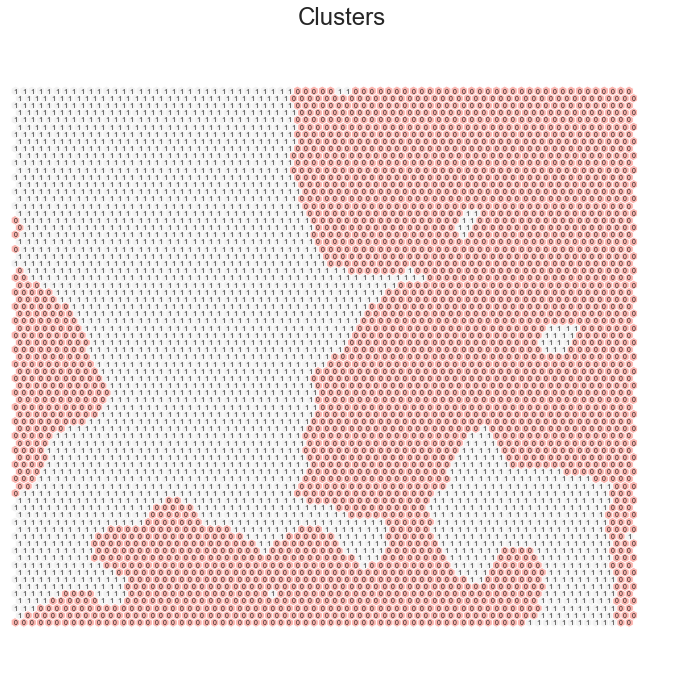

In [98]:
#computing the KMeans on top of SOM solution, in the same way as before
np.random.seed(42)

som = sompy.SOMFactory().build(
    pcas_personal.loc[donors.index,pcas].values, 
    mapsize=(75, 75),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=pcas
)
som.train(n_job=-1, train_rough_len=100, train_finetune_len=100)

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42)
labels_units = som.cluster(kmeans)

#As before, the same pattern is reapeated:
#Plotting our solution, so we can get an idea of the distribution of the clusters, which allowed us to find out that we have a lot of problems with units away from the ones from the same cluster
#This was also a reason why we decided not to use this clustering solution as our final, although it would have better visualization techniques available for it than any other clustering alternative
hits  = HitMapView (12, 12,"Clusters", text_size=20)
hits.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [99]:
#Same reasoning as before to the SOM not being used further

In [100]:
#Once more, here we repeat the same exact steps as we did for the neighborhood perspective, to match each obervation to a label

donors_units=pd.DataFrame(som.get_node_vectors(), columns=pcas)
donors_units["Labels_units"]= labels_units

units = som.find_bmu(pcas_personal.loc[donors.index,pcas])
pcas_personal["SOM_units"] = pd.Series(units[0], index=donors.index)

labels_cluster=[]
for value in pcas_personal.loc[donors.index,"SOM_units"].values:
    labels_cluster.append(donors_units.loc[value,"Labels_units"])

pcas_personal["Labels_SOM_KMeans_Personal"]=pd.Series(labels_cluster, index=donors.index)

sst = get_ss(pcas_personal.loc[donors.index,pcas]) 
ssw_labels = pcas_personal.loc[donors.index,pcas + ["Labels_SOM_KMeans_Personal"]].groupby("Labels_SOM_KMeans_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_personal_with_outliers["SOM+KMeans"]=r2

ss=silhouette_score(pcas_personal.loc[donors.index,pcas],pcas_personal.loc[donors.index,"Labels_SOM_KMeans_Personal"])
ss_personal_with_outliers["SOM+KMeans"]=ss

pcas_personal.drop("SOM_units", axis=1, inplace=True)

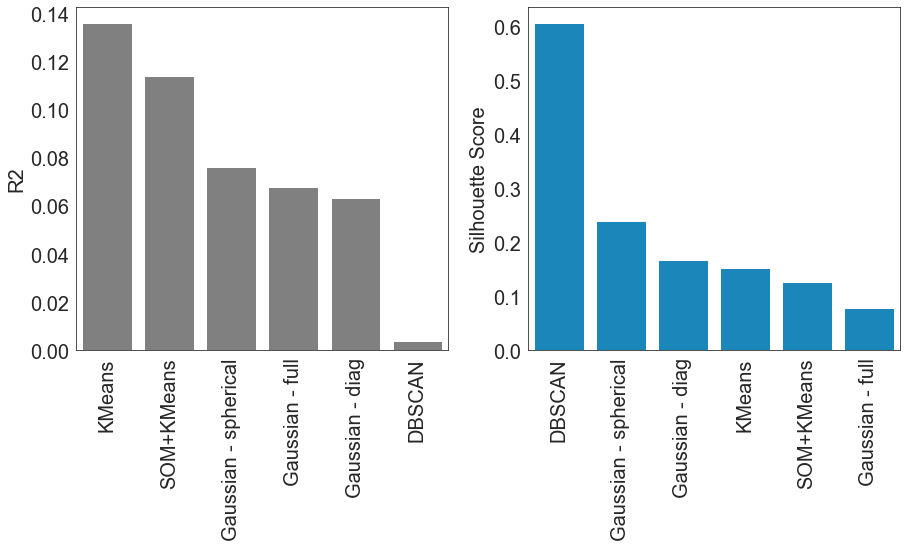

In [101]:
#Plotting the results for the R2 and the Silhouette Scores, just as before

plt.figure(figsize=(13,8))

plt.subplot(1, 2, 1)
df=pd.DataFrame({"R2":list(r2_personal_with_outliers.values())}, index=list(r2_personal_with_outliers.keys())).sort_values(by="R2",ascending=False)
sns.barplot(x=list(df.index), y="R2", data=df, color="grey", label="R2")
plt.xticks(rotation=90)


plt.subplot(1, 2, 2)
df2=pd.DataFrame({"Silhouette Score":list(ss_personal_with_outliers.values())}, index=list(ss_personal_with_outliers.keys())).sort_values(by="Silhouette Score", ascending=False)
sns.barplot(x=list(df2.index), y="Silhouette Score", data=df2, color="#008fd5", label="Silhouette Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

del df, df2

For n_clusters = 2, the average silhouette_score is : 0.15207057982346417, with kmeans.
For n_clusters = 2, the average silhouette_score is : 0.16701025046188103, with diag.
For n_clusters = 2, the average silhouette_score is : 0.23991576348889873, with spherical.
For n_clusters = 2, the average silhouette_score is : 0.39739755544528427, with dbscan.


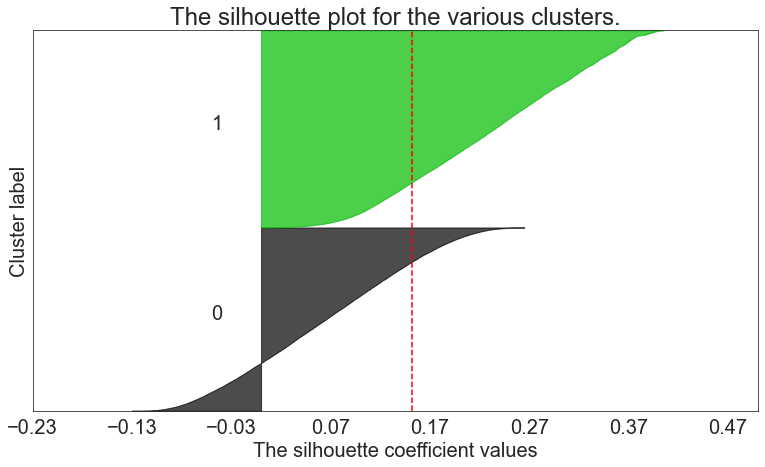

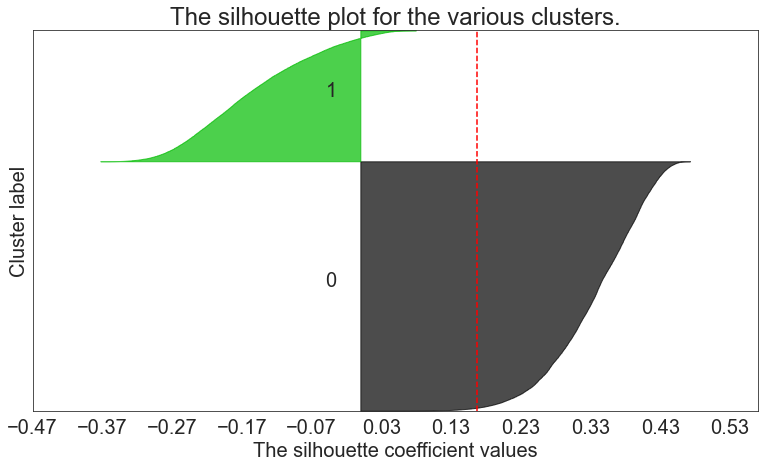

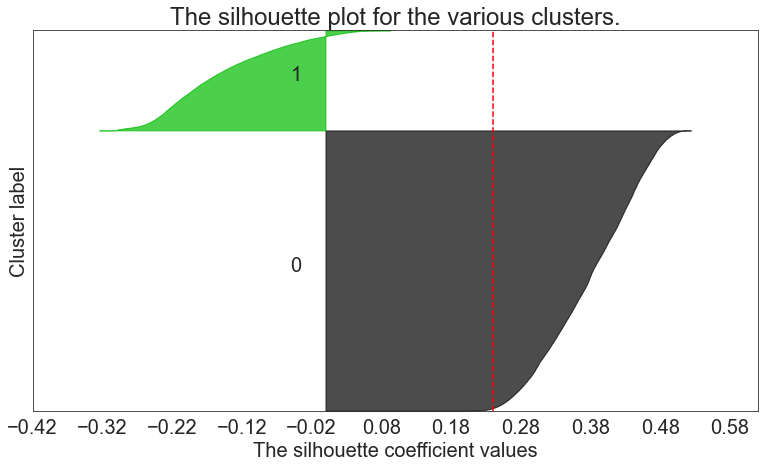

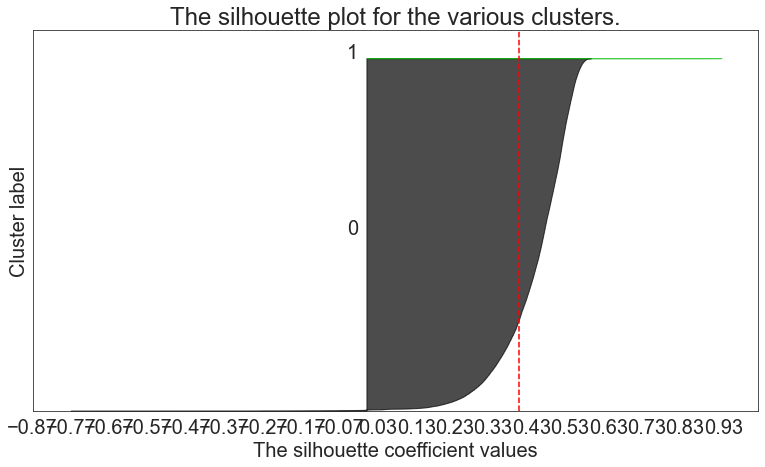

In [102]:
#We will now analyse better the Silhouette scores of our best performing clusters

#Adapted the K-Means Lab

range_clusters=[2]
avg_silhouette = []
for nclus in range_clusters:

    if nclus == 1:
        continue

    for model in ["kmeans", "diag", "spherical", "dbscan"]:
        if model=="kmeans":
            kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=10, random_state=42)
            cluster_labels = kmclust.fit_predict(pcas_personal.loc[donors.index,pcas])
            
        elif model=="diag":
            gaussian=GaussianMixture(nclus, covariance_type=model, n_init=10, random_state=42)
            cluster_labels=gaussian.fit_predict(pcas_personal.loc[donors.index,pcas])
            
        elif model=="spherical":
            gaussian=GaussianMixture(nclus, covariance_type=model, n_init=10, random_state=42)
            cluster_labels=gaussian.fit_predict(pcas_personal.loc[donors.index,pcas])
        
        elif model=="dbscan":
            dbscan=DBSCAN(eps=2.5, min_samples=28, n_jobs=-1)
            cluster_labels=dbscan.fit_predict(pcas_personal.loc[donors.index, pcas])
            
        fig = plt.figure(figsize=(13, 7))    
    
        silhouette_avg = silhouette_score(pcas_personal.loc[donors.index,pcas], cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}, with {model}.")

    
        sample_silhouette_values = silhouette_samples(pcas_personal.loc[donors.index,pcas], cluster_labels)

        y_lower = 10
        for i in range(nclus):
       
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
        
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
        
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])
    
        plt.ylim([0, len(pcas_personal.loc[donors.index,pcas]) + (nclus + 1) * 10])

        plt.yticks([])
        plt.xticks(np.arange(xmin, xmax, 0.1))
    
plt.show()

In [103]:
#By analysing the graphs, we can see that the DBSCAN and both Gaussian models, although having high Silhouette scores, have a distribution of values very erratic, which leads to the K-Means model to be considered the best one.

<b> Re-do witough the outliers given by DBSCAN </b>

In [104]:
#We will repeat the process, now without the outliers considered as such by the DBSCAN.
#For this, we will repeat the steps we did before, for the neighborhood perspective
positions=[]
for index, value in enumerate(pcas_personal.loc[donors.index, "Labels_DBSCAN_Personal"].values):
    if value == -1:
        positions.append(index)
        
print("This method considered", round((len(positions))/initial_nr_rows*100, 3), "% of our initial donors as outliers, in this perspective. Note that we already had", round((outliers_stored/initial_nr_rows)*100, 3), "% of our initial donors classified as general outliers, by statistical/density methods, which we will add later to our analysis, as we will also add the ones from this perspective, now identified by DBSCAN.")
       
dbscan_outliers_personal=list(pcas_personal.loc[donors.index].iloc[positions].index.values)
index_personal=[index for index in donors.index if index not in dbscan_outliers_personal]

r2_personal_without_outliers={}
ss_personal_without_outliers={}

#KMeans cluster solution
kmeans= KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42)
labels= kmeans.fit_predict(pcas_personal.loc[index_personal, pcas])

pcas_personal["Labels_KMeans_Personal"]= pd.Series(labels, index= index_personal)

sst = get_ss(pcas_personal.loc[index_personal,pcas])
ssw_labels = pcas_personal.loc[index_personal, pcas + ["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_personal_without_outliers["KMeans"]=r2

ss=silhouette_score(pcas_personal.loc[index_personal,pcas],pcas_personal.loc[index_personal,"Labels_KMeans_Personal"])
ss_personal_without_outliers["KMeans"]=ss


#DBSCAN cluster solution
dbscan=DBSCAN(eps=2.5, min_samples=28, n_jobs=-1)
labels=dbscan.fit_predict(pcas_personal.loc[index_personal, pcas])

pcas_personal["Labels_DBSCAN_Personal"] = pd.Series(labels, index=index_personal)

sst = get_ss(pcas_personal.loc[index_personal,pcas]) 
ssw_labels = pcas_personal.loc[index_personal,pcas + ["Labels_DBSCAN_Personal"]].groupby("Labels_DBSCAN_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_personal_without_outliers["DBSCAN"]=r2

ss=silhouette_score(pcas_personal.loc[index_personal, pcas], pcas_personal.loc[index_personal,"Labels_DBSCAN_Personal"])
ss_personal_without_outliers["DBSCAN"]=ss


#Gaussian cluster solution, for each covariance_type contained in list types
types=["full", "diag", "spherical"]

for cov_type in types:
    gaussian = GaussianMixture(n_components=2, covariance_type=cov_type, n_init=20, init_params='kmeans', random_state=42)
    labels = gaussian.fit_predict(pcas_personal.loc[index_personal,pcas])
    pcas_personal["Labels_Gaussian_Personal_"+str(cov_type)]= pd.Series(labels, index=index_personal)

    sst = get_ss(pcas_personal.loc[index_personal,pcas]) 
    ssw_labels = pcas_personal.loc[index_personal,pcas + ["Labels_Gaussian_Personal_"+str(cov_type)]].groupby("Labels_Gaussian_Personal_"+str(cov_type)).apply(get_ss)
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst
    r2_personal_without_outliers[str("Gaussian - "+str(cov_type))]=r2

    ss=silhouette_score(pcas_personal.loc[index_personal,pcas],pcas_personal.loc[index_personal,"Labels_Gaussian_Personal_"+str(cov_type)])
    ss_personal_without_outliers[str("Gaussian - "+str(cov_type))]=ss


This method considered 6.841 % of our initial donors as outliers, in this perspective. Note that we already had 4.529 % of our initial donors classified as general outliers, by statistical/density methods, which we will add later to our analysis, as we will also add the ones from this perspective, now identified by DBSCAN.


 Training...
 random_initialization took: 0.003000 seconds
 Rough training...
 radius_ini: 25.000000 , radius_final: 4.166667, trainlen: 100

 epoch: 1 ---> elapsed time:  5.172000, quantization error: 5.797500

 epoch: 2 ---> elapsed time:  5.151000, quantization error: 3.501891

 epoch: 3 ---> elapsed time:  5.205000, quantization error: 3.495695

 epoch: 4 ---> elapsed time:  5.318000, quantization error: 3.493557

 epoch: 5 ---> elapsed time:  5.663000, quantization error: 3.492364

 epoch: 6 ---> elapsed time:  5.258000, quantization error: 3.491308

 epoch: 7 ---> elapsed time:  5.265000, quantization error: 3.490343

 epoch: 8 ---> elapsed time:  5.276000, quantization error: 3.489629

 epoch: 9 ---> elapsed time:  5.290000, quantization error: 3.489044

 epoch: 10 ---> elapsed time:  5.309000, quantization error: 3.488556

 epoch: 11 ---> elapsed time:  5.430000, quantization error: 3.488131

 epoch: 12 ---> elapsed time:  5.597000, quantization error: 3.487726

 epoch: 13 --->

 epoch: 14 ---> elapsed time:  5.353000, quantization error: 3.212163

 epoch: 15 ---> elapsed time:  5.530000, quantization error: 3.206869

 epoch: 16 ---> elapsed time:  5.483000, quantization error: 3.201488

 epoch: 17 ---> elapsed time:  5.323000, quantization error: 3.196001

 epoch: 18 ---> elapsed time:  5.308000, quantization error: 3.190412

 epoch: 19 ---> elapsed time:  5.285000, quantization error: 3.184676

 epoch: 20 ---> elapsed time:  5.327000, quantization error: 3.178784

 epoch: 21 ---> elapsed time:  5.498000, quantization error: 3.172751

 epoch: 22 ---> elapsed time:  5.621000, quantization error: 3.166543

 epoch: 23 ---> elapsed time:  5.516000, quantization error: 3.160169

 epoch: 24 ---> elapsed time:  5.355000, quantization error: 3.153629

 epoch: 25 ---> elapsed time:  5.408000, quantization error: 3.146993

 epoch: 26 ---> elapsed time:  5.332000, quantization error: 3.140187

 epoch: 27 ---> elapsed time:  5.396000, quantization error: 3.133164

 epoch

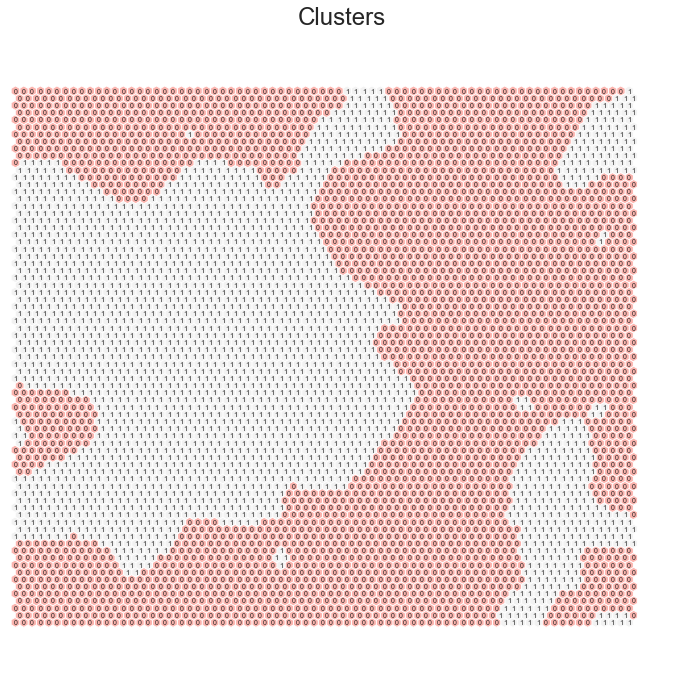

In [105]:
#Moving on to the K-Means on Top of SOM cluster solution

np.random.seed(42)

som = sompy.SOMFactory().build(
    pcas_personal.loc[index_personal,pcas].values, 
    mapsize=(75, 75),
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=pcas
)
som.train(n_job=-1, train_rough_len=100, train_finetune_len=100)

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=42)
labels_units = som.cluster(kmeans)

#As before, the same pattern is reapeated:
#Plotting our solution, so we can get an idea of the distribution of the clusters, which allowed us to find out that we have a lot of problems with units away from the ones from the same cluster
#This was also a reason why we decided not to use this clustering solution as our final, although it would have better visualization techniques available for it than any other clustering alternative
hits  = HitMapView (12, 12,"Clusters", text_size=20)
hits.show(som, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [106]:
#Same reasoning as before to the SOM not being used further

In [107]:
#Finding to which cluster each observation belongs to, doing the same steps as previously

donors_units=pd.DataFrame(som.get_node_vectors(), columns=pcas)
donors_units["Labels_units"]= labels_units

units = som.find_bmu(pcas_personal.loc[index_personal,pcas])
pcas_personal["SOM_units"] = pd.Series(units[0], index=index_personal)

labels_cluster=[]
for value in pcas_personal.loc[index_personal,"SOM_units"].values:
    labels_cluster.append(donors_units.loc[value,"Labels_units"])

pcas_personal["Labels_SOM_KMeans_Personal"]=pd.Series(labels_cluster, index=index_personal)

sst = get_ss(pcas_personal.loc[index_personal,pcas])
ssw_labels = pcas_personal.loc[index_personal,pcas + ["Labels_SOM_KMeans_Personal"]].groupby("Labels_SOM_KMeans_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2_personal_without_outliers["SOM+KMeans"]=r2

ss=silhouette_score(pcas_personal.loc[index_personal,pcas],pcas_personal.loc[index_personal,"Labels_SOM_KMeans_Personal"])
ss_personal_without_outliers["SOM+KMeans"]=ss

pcas_personal.drop("SOM_units", axis=1, inplace=True)

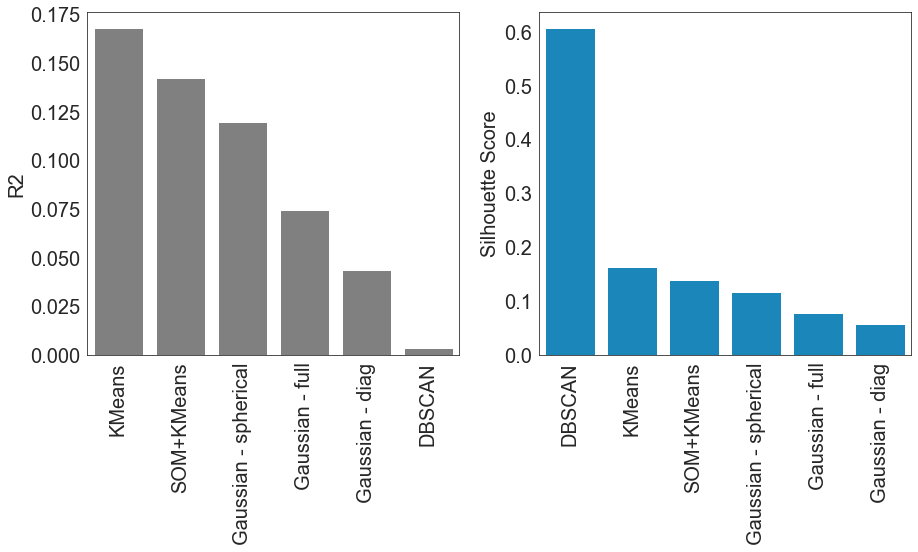

In [108]:
#Plotting the results we got from our cluster solutions
plt.figure(figsize=(13,8))

#Plotting the R2 results for each custer solution
plt.subplot(1, 2, 1)
df=pd.DataFrame({"R2":list(r2_personal_without_outliers.values())}, index=list(r2_personal_without_outliers.keys())).sort_values(by="R2",ascending=False)
sns.barplot(x=list(df.index), y="R2", data=df, color="grey", label="R2")
plt.xticks(rotation=90)

#Plotting the Silhouette score for each cluster solution
plt.subplot(1, 2, 2)
df2=pd.DataFrame({"Silhouette Score":list(ss_personal_without_outliers.values())}, index=list(ss_personal_without_outliers.keys())).sort_values(by="Silhouette Score", ascending=False)
sns.barplot(x=list(df2.index), y="Silhouette Score", data=df2, color="#008fd5", label="Silhouette Score")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#Deleting the variables we will no longer use
del df, df2

<b> Feature selection for the clustering perspective </b>

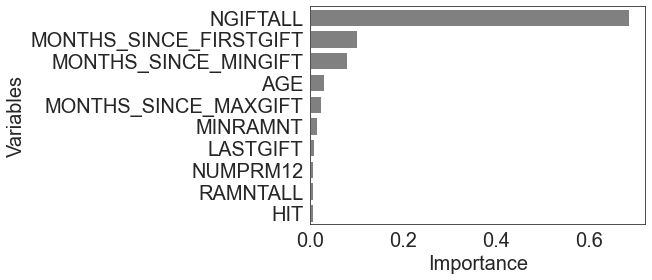

In [109]:
#Once more, we will use a decision tree to select the variables which have a more discriminatory power in our cluster solution, in addition to computing the R2 for each variable.
#Note that the steps followed were the same as we did for the neighborhood perspective

dt=DecisionTreeClassifier(random_state=42)
dt.fit(X=donors.loc[index_personal,personal], y=pcas_personal.loc[index_personal,"Labels_KMeans_Personal"])

donors["Labels_KMeans_Personal"]=pd.Series(pcas_personal.loc[index_personal,"Labels_KMeans_Personal"].values, index=index_personal)

sst_vars=get_ss_variables(donors.loc[index_personal,personal])
ssw_vars=np.sum(donors.loc[index_personal,personal+["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").apply(get_ss_variables))
r2_vars=(1-(ssw_vars/sst_vars)).drop("Labels_KMeans_Personal")

#Finding the variables whose R2 is higher than 5%
r2_higher=list(r2_vars[r2_vars>0.05].index)

#Using the Select From Model, with our decision tree, to get the variables whose importance is higher than half the mean importance.
selector=SelectFromModel(dt,  threshold= "0.5*mean").fit(X=donors.loc[index_personal,personal], y=pcas_personal.loc[index_personal,"Labels_KMeans_Personal"])
selector_vars=(list(np.array(personal)[selector.get_support()]))

#Getting our new variables, by seeing which ones were selected by our selector or have a R2 higher than 5%
new_personal=list(set(selector_vars+ r2_higher))

#plotting the 10 most important variables, to achieve our cluster solution, according to our decision tree
impo=pd.DataFrame(dt.feature_importances_, columns=["Importance"])
impo["Variables"]=personal
impo.sort_values(by="Importance",ascending = False, inplace = True)
sns.barplot(y='Variables', x='Importance', data=impo[:10], color = "grey")
plt.show()

#deleting our dataframe, as we will no use it
del pcas_personal

<b> Re-do the clustering solution with the 9 features left, with 2 clusters, without the new DBSCAN outliers and using K-Means </b>


In [110]:
#please note that here, contrary to what we did in our neighborhood perspective, the new variables obtained will not be used to re-do a PCA, but will instead be used directly for the remaining of our analysis
#The reasoning behind this is because in this perspective we don't want only a general view of the environment in which each donor is inserted in, so we used PCA in order to achieve a cluster solution, so we can find the most important variables to achieve it
#Checking our new variables.
new_personal

['MONTHS_SINCE_MAXGIFT',
 'RAMNTALL',
 'MONTHS_SINCE_FIRSTGIFT',
 'MONTHS_SINCE_MINGIFT',
 'AGE',
 'NGIFTALL',
 'AVGGIFT',
 'LASTGIFT',
 'MINRAMNT']

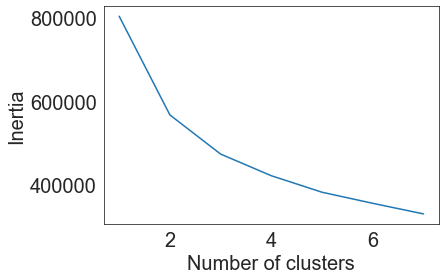

In [111]:
#Using the K-Means' inertias to find our which is the optimal number of clusters to use now.
inertias=[]
for nr_clusters in range(1,8):
    kmeans= KMeans(n_clusters=(nr_clusters), init="k-means++", n_init=10, random_state=42)
    labels= kmeans.fit_predict(donors[new_personal])
    inertias.append(kmeans.inertia_)
    
plt.plot(pd.Series(inertias, index=np.arange(1,8)))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

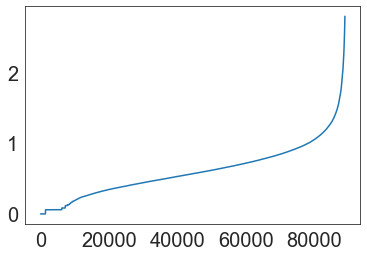

In [112]:
#Finding which are the optimal parameters to pass to DBSCAN.
#note that now that we only have 9 variables, we use n_neighbors=18
neighbors = NearestNeighbors(n_neighbors=18)
p = neighbors.fit(donors[new_personal])
distances, disposable_variable = p.kneighbors(donors[new_personal])
distances = np.sort(distances[:, -1])
plt.plot(distances[:89000])
plt.show()

In [113]:
#Checking the values found
dbscan=DBSCAN(eps=1.1, min_samples=18, n_jobs=-1)
labels=dbscan.fit_predict(donors[new_personal])
np.unique(labels)

array([-1,  0,  1], dtype=int64)

In [114]:
#Using the DBSCAN in our new variables, in order to find which are now considered the outliers in this perspective, according to this method
#The process to achieve this is the same as before.
dbscan=DBSCAN(eps=1.1, min_samples=18, n_jobs=-1)
labels=dbscan.fit_predict(donors[new_personal])

donors["Labels_DBSCAN_Personal"] = pd.Series(labels, index=donors.index)

positions=[]
for index, value in enumerate(donors[ "Labels_DBSCAN_Personal"].values):
    if value == -1:
        positions.append(index)
       
    
print("This method considered", round((len(positions))/initial_nr_rows*100, 3), "% of our initial donors as outliers, in this perspective. Note that we already had", round((outliers_stored/initial_nr_rows)*100, 3), "% of our initial donors classified as general outliers by statistical/density methods, which we will add later to our analysis, as we will also add the ones from this perspective, now identified by DBSCAN.")
             
dbscan_outliers_personal=list(donors.iloc[positions].index.values)
index_personal=[index for index in donors.index if index not in dbscan_outliers_personal]

This method considered 4.038 % of our initial donors as outliers, in this perspective. Note that we already had 4.529 % of our initial donors classified as general outliers by statistical/density methods, which we will add later to our analysis, as we will also add the ones from this perspective, now identified by DBSCAN.


In [115]:
#With the new outliers from this perspective found, we proceed to make our K-Means cluster solution, fitting it to the remaining entries
kmeans= KMeans(n_clusters=2, init="k-means++", n_init=20, random_state=42)

labels= kmeans.fit_predict(donors.loc[index_personal, new_personal])

donors["Labels_KMeans_Personal"]= pd.Series(labels, index= index_personal)

sst = get_ss(donors.loc[index_personal, new_personal])  
ssw_labels = donors.loc[index_personal, new_personal + ["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").apply(get_ss) 
ssb = sst - np.sum(ssw_labels)  
r2 = ssb / sst

ss=silhouette_score(donors.loc[index_personal,new_personal],donors.loc[index_personal,"Labels_KMeans_Personal"])

print("Using KMeans, the R2 is now", round(r2, 3), ", while the Silhouette Score is", round(ss,3))

Using KMeans, the R2 is now 0.329 , while the Silhouette Score is 0.296


In [116]:
#Checking the differences in means for the different variables, according to the cluster solution we just achieved
donors.loc[index_personal, new_personal+["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").mean()

MONTHS_SINCE_MAXGIFT  RAMNTALL  \
Labels_KMeans_Personal                                   
0.0                                -0.414515 -0.566469   
1.0                                 0.389290  0.401419   

                        MONTHS_SINCE_FIRSTGIFT  MONTHS_SINCE_MINGIFT  \
Labels_KMeans_Personal                                                 
0.0                                  -0.807681             -0.658072   
1.0                                   0.869023              0.740635   

                             AGE  NGIFTALL   AVGGIFT  LASTGIFT  MINRAMNT  
Labels_KMeans_Personal                                                    
0.0                    -0.318239 -0.659727  0.258337  0.108449   0.42977  
1.0                     0.353306  0.637017 -0.440260 -0.279911  -0.53127

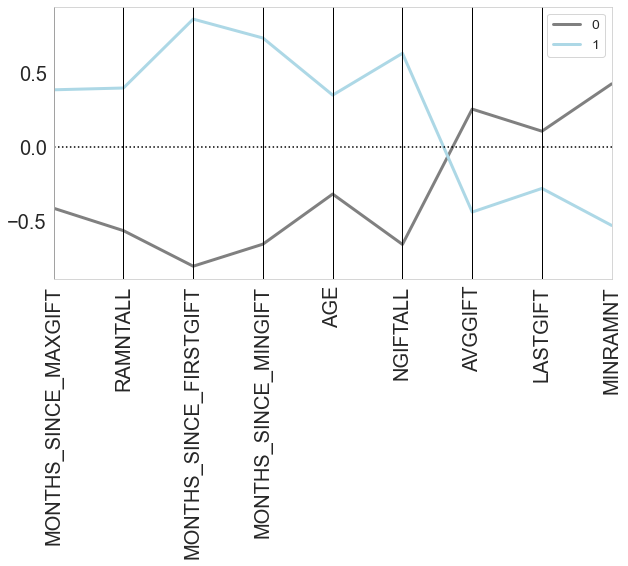

In [117]:
#Plotting the differences in mean for the different variables between each cluster
#Please note that the results shown could have the labels inversed compared with the ones in the report, although we have run with a random_state in place. We looked online and this is a recurrent problem.
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
centroids=donors.loc[index_personal, new_personal + ["Labels_KMeans_Personal"]].groupby(by="Labels_KMeans_Personal", as_index=False).mean()
centroids["Labels_KMeans_Personal"]=[0,1]
pd.plotting.parallel_coordinates(centroids, "Labels_KMeans_Personal", color=["grey","lightblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.xticks(rotation=90)
plt.legend(loc="upper right", fontsize="x-small")
plt.show()

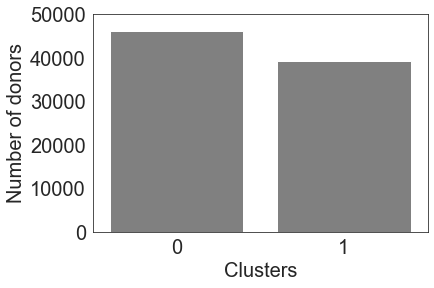

In [118]:
#ploting the distribution of observations per each cluster
sns.set_style("white")
countplot=sns.countplot(x="Labels_KMeans_Personal", data=pd.DataFrame(donors[(donors["Labels_KMeans_Personal"]==1.0) | (donors["Labels_KMeans_Personal"]==0.0)]["Labels_KMeans_Personal"].astype(int)), palette=["grey", "grey"])
countplot.set(xlabel="Clusters", ylabel = "Number of donors")
plt.yticks(np.arange(0, 60000, 10000))
plt.show()

#deleting the variables we will no longer need
del centroids, countplot

In [119]:
#Note: Altought we set random_state, T-SNE vizualization for some reason change when we run it (the conclusions are the same, but the plot themselves suffer some modifications)

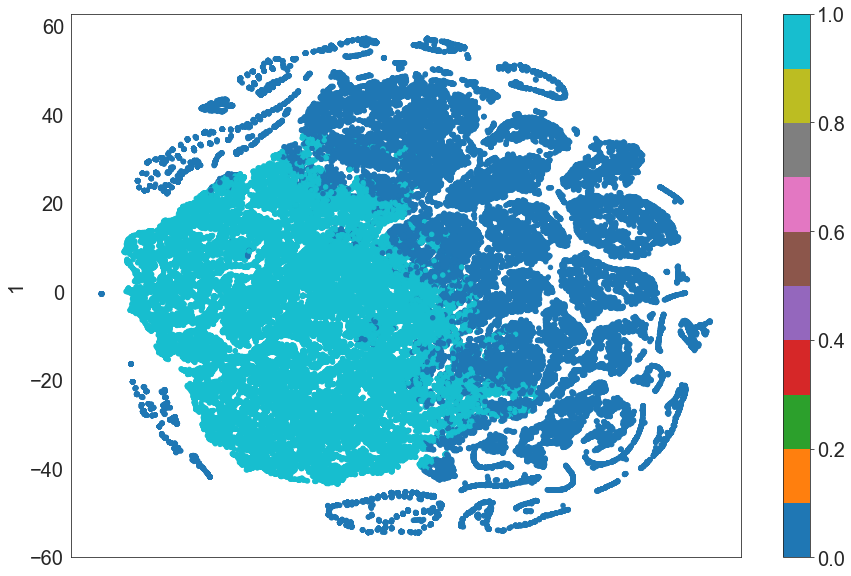

In [120]:
#Plotting a T-SNE visualization, in order to see the distribution of our observations according to our clusters
two_dim = TSNE(random_state=42).fit_transform(donors.loc[index_personal, new_personal])
sns.set_style("white")
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=donors.loc[index_personal, "Labels_KMeans_Personal"], colormap='tab10', figsize=(15,10))
plt.show()

<b> Adding the perspective outliers back, with the proper prediction </b>

In [121]:
#We will use the same strategy as in the neighborhood perspective in order to predict the observations considered as outliers in this perspective

X_train, X_test, y_train, y_test = train_test_split(donors.loc[index_personal, new_personal], donors.loc[index_personal, "Labels_KMeans_Personal"], test_size=0.3, random_state=42)

decision_tree= DecisionTreeClassifier(random_state=42, max_depth=3)
decision_tree.fit(X_train, y_train)
print("On average, we will allocate our donors to the correct clusters", round(decision_tree.score(X_test, y_test)*100, 3), "% of the times.")

pred=pd.Series(decision_tree.predict(donors.loc[dbscan_outliers_personal, new_personal]), index=dbscan_outliers_personal)
donors.loc[dbscan_outliers_personal,"Labels_KMeans_Personal"]=pred

ss=silhouette_score(donors.loc[index_personal+dbscan_outliers_personal,new_personal],donors.loc[index_personal+dbscan_outliers_personal,"Labels_KMeans_Personal"])

sst = get_ss(donors.loc[index_personal+dbscan_outliers_personal, new_personal])
ssw_labels = donors.loc[index_personal+dbscan_outliers_personal, new_personal + ["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").apply(get_ss)
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst

print("\nAfter adding the outliers from this perspective, the R2 is now", round(r2,3), "and the Silhouette score is", round(ss,3))

#Checking the difference in means for each variable between each cluster, now that we have joined our perspective's outliers
donors.loc[index_personal+dbscan_outliers_personal, new_personal+["Labels_KMeans_Personal"]].groupby("Labels_KMeans_Personal").mean()

On average, we will allocate our donors to the correct clusters 94.557 % of the times.

After adding the outliers from this perspective, the R2 is now 0.292 and the Silhouette score is 0.281


MONTHS_SINCE_MAXGIFT  RAMNTALL  \
Labels_KMeans_Personal                                   
0.0                                -0.405050 -0.539738   
1.0                                 0.447411  0.596185   

                        MONTHS_SINCE_FIRSTGIFT  MONTHS_SINCE_MINGIFT  \
Labels_KMeans_Personal                                                 
0.0                                  -0.801104             -0.654158   
1.0                                   0.884885              0.722571   

                             AGE  NGIFTALL   AVGGIFT  LASTGIFT  MINRAMNT  
Labels_KMeans_Personal                                                    
0.0                    -0.313914 -0.655831  0.309246  0.159379  0.451362  
1.0                     0.346744  0.724419 -0.341588 -0.176047 -0.498566

<b> 7) Clustering:Merged Perspectives

In [122]:
#Getting our dataframe with the merged perspectives
donors_merged=pd.concat([pcas_neigh_new.loc[index_neighborhood+dbscan_outliers_neigh], donors[new_personal+["Labels_KMeans_Personal"]]], axis=1, sort=False)

#Seeing how many observations each new cluster has
donors_merged.groupby(["Labels_KMeans_Neigh", "Labels_KMeans_Personal"]).size().to_frame().reset_index().pivot("Labels_KMeans_Personal", "Labels_KMeans_Neigh",0)

Labels_KMeans_Neigh       0.0    1.0
Labels_KMeans_Personal              
0.0                     26146  20717
1.0                     25942  16484

In [123]:
#Cehcking the differences in mean for each variable, between each cluster solution
donors_merged.groupby(["Labels_KMeans_Neigh","Labels_KMeans_Personal"]).mean()

PCA 1 Neighborhood  \
Labels_KMeans_Neigh Labels_KMeans_Personal                       
0.0                 0.0                              -2.744778   
                    1.0                              -2.800756   
1.0                 0.0                               4.069630   
                    1.0                               3.905739   

                                            PCA 2 Neighborhood  \
Labels_KMeans_Neigh Labels_KMeans_Personal                       
0.0                 0.0                               0.187945   
                    1.0                              -0.077392   
1.0                 0.0                               0.376154   
                    1.0                               0.186262   

                                            PCA 3 Neighborhood  \
Labels_KMeans_Neigh Labels_KMeans_Personal                       
0.0                 0.0                               0.103231   
                    1.0                               0.326117   
1.0                 0.0                              -0.042520   
                    1.0                               0.076431   

                                            PCA 4 Neighborhood  \
Labels_KMeans_Neigh Labels_KMeans_Personal                       
0.0                 0.0                              -0.058546   
                    1.0                               0.142611   
1.0                 0.0                              -0.022821   
                    1.0                               0.133553   

                                            PCA 5 Neighborhood  \
Labels_KMeans_Neigh Labels_KMeans_Personal                       
0.0                 0.0                              -0.054074   
                    1.0                               0.040628   
1.0                 0.0                               0.022808   
                    1.0                              -0.010868   

                                            PCA 6 Neighborhood  \
Labels_KMeans_Neigh Labels_KMeans_Personal                       
0.0                 0.0                               0.027041   
                    1.0                              -0.044941   
1.0                 0.0                               0.151694   
                    1.0                               0.026535   

                                            MONTHS_SINCE_MAXGIFT  RAMNTALL  \
Labels_KMeans_Neigh Labels_KMeans_Personal                                   
0.0                 0.0                                -0.412438 -0.556940   
                    1.0                                 0.450382  0.554284   
1.0                 0.0                                -0.395727 -0.518028   
                    1.0                                 0.442735  0.662127   

                                            MONTHS_SINCE_FIRSTGIFT  \
Labels_KMeans_Neigh Labels_KMeans_Personal                           
0.0                 0.0                                  -0.809483   
                    1.0                                   0.910034   
1.0                 0.0                                  -0.790528   
                    1.0                                   0.845305   

                                            MONTHS_SINCE_MINGIFT       AGE  \
Labels_KMeans_Neigh Labels_KMeans_Personal                                   
0.0                 0.0                                -0.663077 -0.287405   
                    1.0                                 0.726383  0.374587   
1.0                 0.0                                -0.642903 -0.347370   
                    1.0                                 0.716572  0.302925   

                                            NGIFTALL   AVGGIFT  LASTGIFT  \
Labels_KMeans_Neigh Labels_KMeans_Personal                                 
0.0                 0.0                    -0.649137  0.239440  0.103892   
                    1.0                     0.764349 -0.406605 -0.231318   

In [124]:
#Joining the clsuters labels: if a observation had an 1 for Labels_KMeans_Neigh and a 0 for Labels_KMeans_Personal, now it has a 10 for Final_Laebls
donors_merged[["Labels_KMeans_Neigh", "Labels_KMeans_Personal"]]=donors_merged[["Labels_KMeans_Neigh", "Labels_KMeans_Personal"]].astype(int).astype(str)
donors_merged["Labels_KMeans_Neigh"]+donors_merged[ "Labels_KMeans_Personal"]
donors_merged["Final_Labels"]=donors_merged["Labels_KMeans_Neigh"]+donors_merged[ "Labels_KMeans_Personal"]

#Dropping the original labels, as they are no longer needed
donors_merged.drop(["Labels_KMeans_Personal", "Labels_KMeans_Neigh"], axis=1, inplace=True)

#Computing the silhouette score for our final cluster solutions, after we have merged our labels from the 2 perspectives
ss=silhouette_score(donors_merged.loc[:,[col for col in donors_merged.columns if "Label" not in col]],donors_merged.loc[:,"Final_Labels"])

#Computing the R2 for our final cluster solution, with the 4 clusters obtained
sst = get_ss(donors_merged.loc[:,[col for col in donors_merged.columns if col not in ["Final_Labels"]]])
ssw_labels = donors_merged.groupby("Final_Labels").apply(get_ss) 
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst

print("Our final cluster solution has a Silhouette score of", round(ss,3), "and a R2 of", round(r2,3))

Our final cluster solution has a Silhouette score of 0.088 and a R2 of 0.334


For n_clusters = 4, the average silhouette_score is : 0.08818126834655121


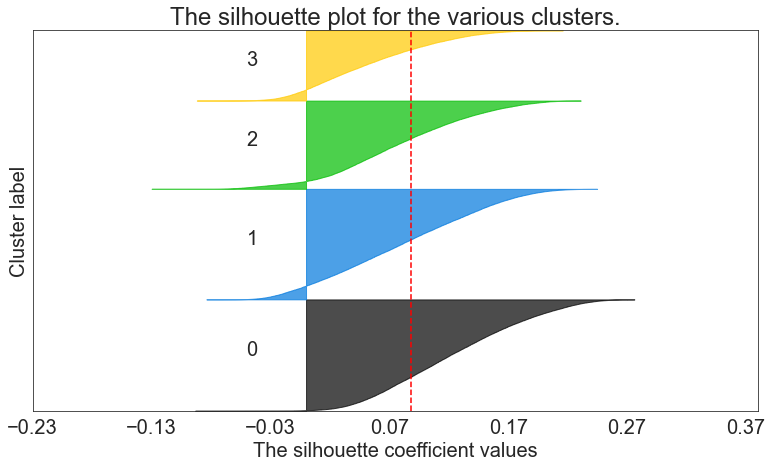

In [125]:
#Adapted from the K-Means Lab

range_clusters=[4]
avg_silhouette = []

for nclus in range_clusters:
    
    if nclus == 1:
        continue
    
    fig = plt.figure(figsize=(13, 7))
    
    silhouette_avg = silhouette_score(donors_merged.loc[:,[col for col in donors_merged.columns if "Label" not in col]], donors_merged["Final_Labels"])
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(donors_merged.loc[:,[col for col in donors_merged.columns if "Label" not in col]], donors_merged["Final_Labels"])
    
    #We have to convert our cluster labels to numbers, in order to plot them, as before they were strings
    new_labels=donors_merged["Final_Labels"].apply(lambda x: 0 if x=="00" else 1 if x=="01" else 2 if x=="10" else 3 if x=="11" else x)
    
    y_lower = 10
    for i in range(nclus):
        
        ith_cluster_silhouette_values = sample_silhouette_values[new_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(donors_merged.loc[:,[col for col in donors_merged.columns if "Label" not in col]]) + (nclus + 1) * 10])

    plt.yticks([])
    plt.xticks(np.arange(xmin, xmax, 0.1))
    
plt.show()

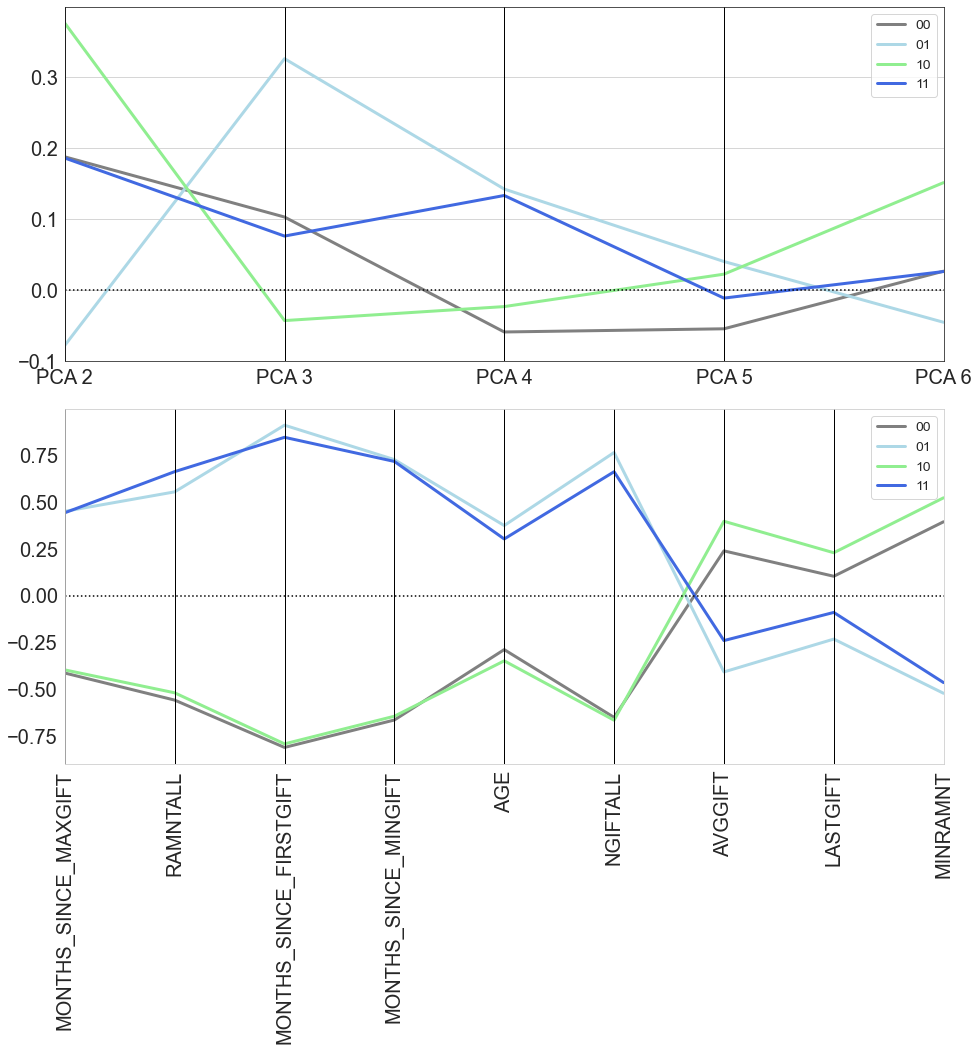

In [126]:
#checking the differences within each variable between each cluster
plt.figure(figsize=(14,15))

#Plotting the differences in mean for the different PCA's (except the first one, for the reasons previously explained), between each cluster
plt.subplot(2, 1, 1)
sns.set_style("whitegrid")
centroids=donors_merged.loc[:, [col for col in donors_merged.columns if ("PCA" in col and "PCA 1" not in col)]+["Final_Labels"]].groupby(by="Final_Labels", as_index=False).mean()
centroids.columns=["Final_Labels","PCA 2", "PCA 3", "PCA 4", "PCA 5", "PCA 6"]
pd.plotting.parallel_coordinates(centroids, "Final_Labels", color=["grey","lightblue", "lightgreen", "royalblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.legend(loc="upper right", fontsize="x-small")

#Plotting the differences in mean for each variable from the Personal perspective, between each cluster
plt.subplot(2, 1, 2)
sns.set_style("whitegrid")
centroids2=donors_merged.loc[:, new_personal+["Final_Labels"]].groupby(by="Final_Labels", as_index=False).mean()
pd.plotting.parallel_coordinates(centroids2, "Final_Labels", color=["grey","lightblue", "lightgreen", "royalblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.xticks(rotation=90)
plt.legend(loc="upper right", fontsize="x-small")

plt.tight_layout()
plt.show()

#deleting these variables, as they are no longer needed
del centroids, centroids2

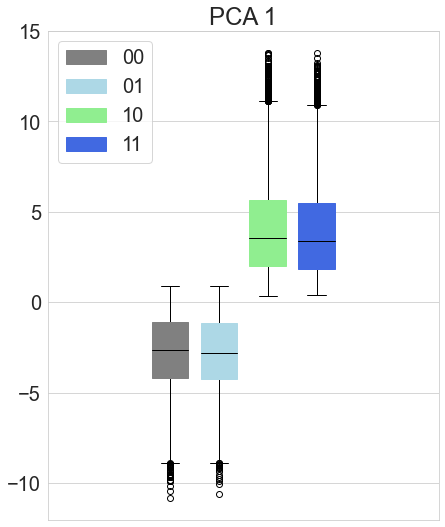

In [127]:
#Plotting the boxplot for the variable PCA 1, in order to see the differences in distribution between each cluster
plt.figure(figsize=(7,9))
plt.title("PCA 1")
plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="00"]["PCA 1 Neighborhood"], positions=np.arange(1), patch_artist=True,boxprops=dict(facecolor="grey", color="grey"), medianprops=dict(color="black"))
plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="01"]["PCA 1 Neighborhood"], positions=np.arange(1)+0.2, patch_artist=True,boxprops=dict(facecolor="lightblue", color="lightblue"), medianprops=dict(color="black"))
plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="10"]["PCA 1 Neighborhood"], positions=np.arange(1)+0.4, patch_artist=True,boxprops=dict(facecolor="lightgreen", color="lightgreen"), medianprops=dict(color="black"))
plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="11"]["PCA 1 Neighborhood"], positions=np.arange(1)+0.6, patch_artist=True,boxprops=dict(facecolor="royalblue", color="royalblue"), medianprops=dict(color="black"))
grey_patch = mpatches.Patch(color='grey', label='00')
lblue_patch = mpatches.Patch(color='lightblue', label='01')    
lgreen_patch = mpatches.Patch(color='lightgreen', label='10')
blue_patch = mpatches.Patch(color='royalblue', label='11')
plt.legend(handles=[grey_patch,lblue_patch, lgreen_patch, blue_patch], loc="upper left")
plt.xticks([])
plt.show()

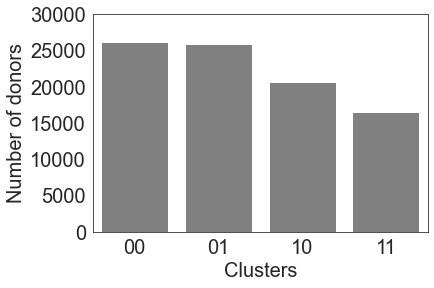

In [128]:
#Plotting the distribution of observations per each cluster
sns.set_style("white")
countplot=sns.countplot(x="Final_Labels", data=donors_merged, palette=["grey", "grey", "grey", "grey"])
countplot.set(xlabel="Clusters", ylabel = "Number of donors")
plt.yticks(np.arange(0, 35000, 5000))
plt.show()
del countplot

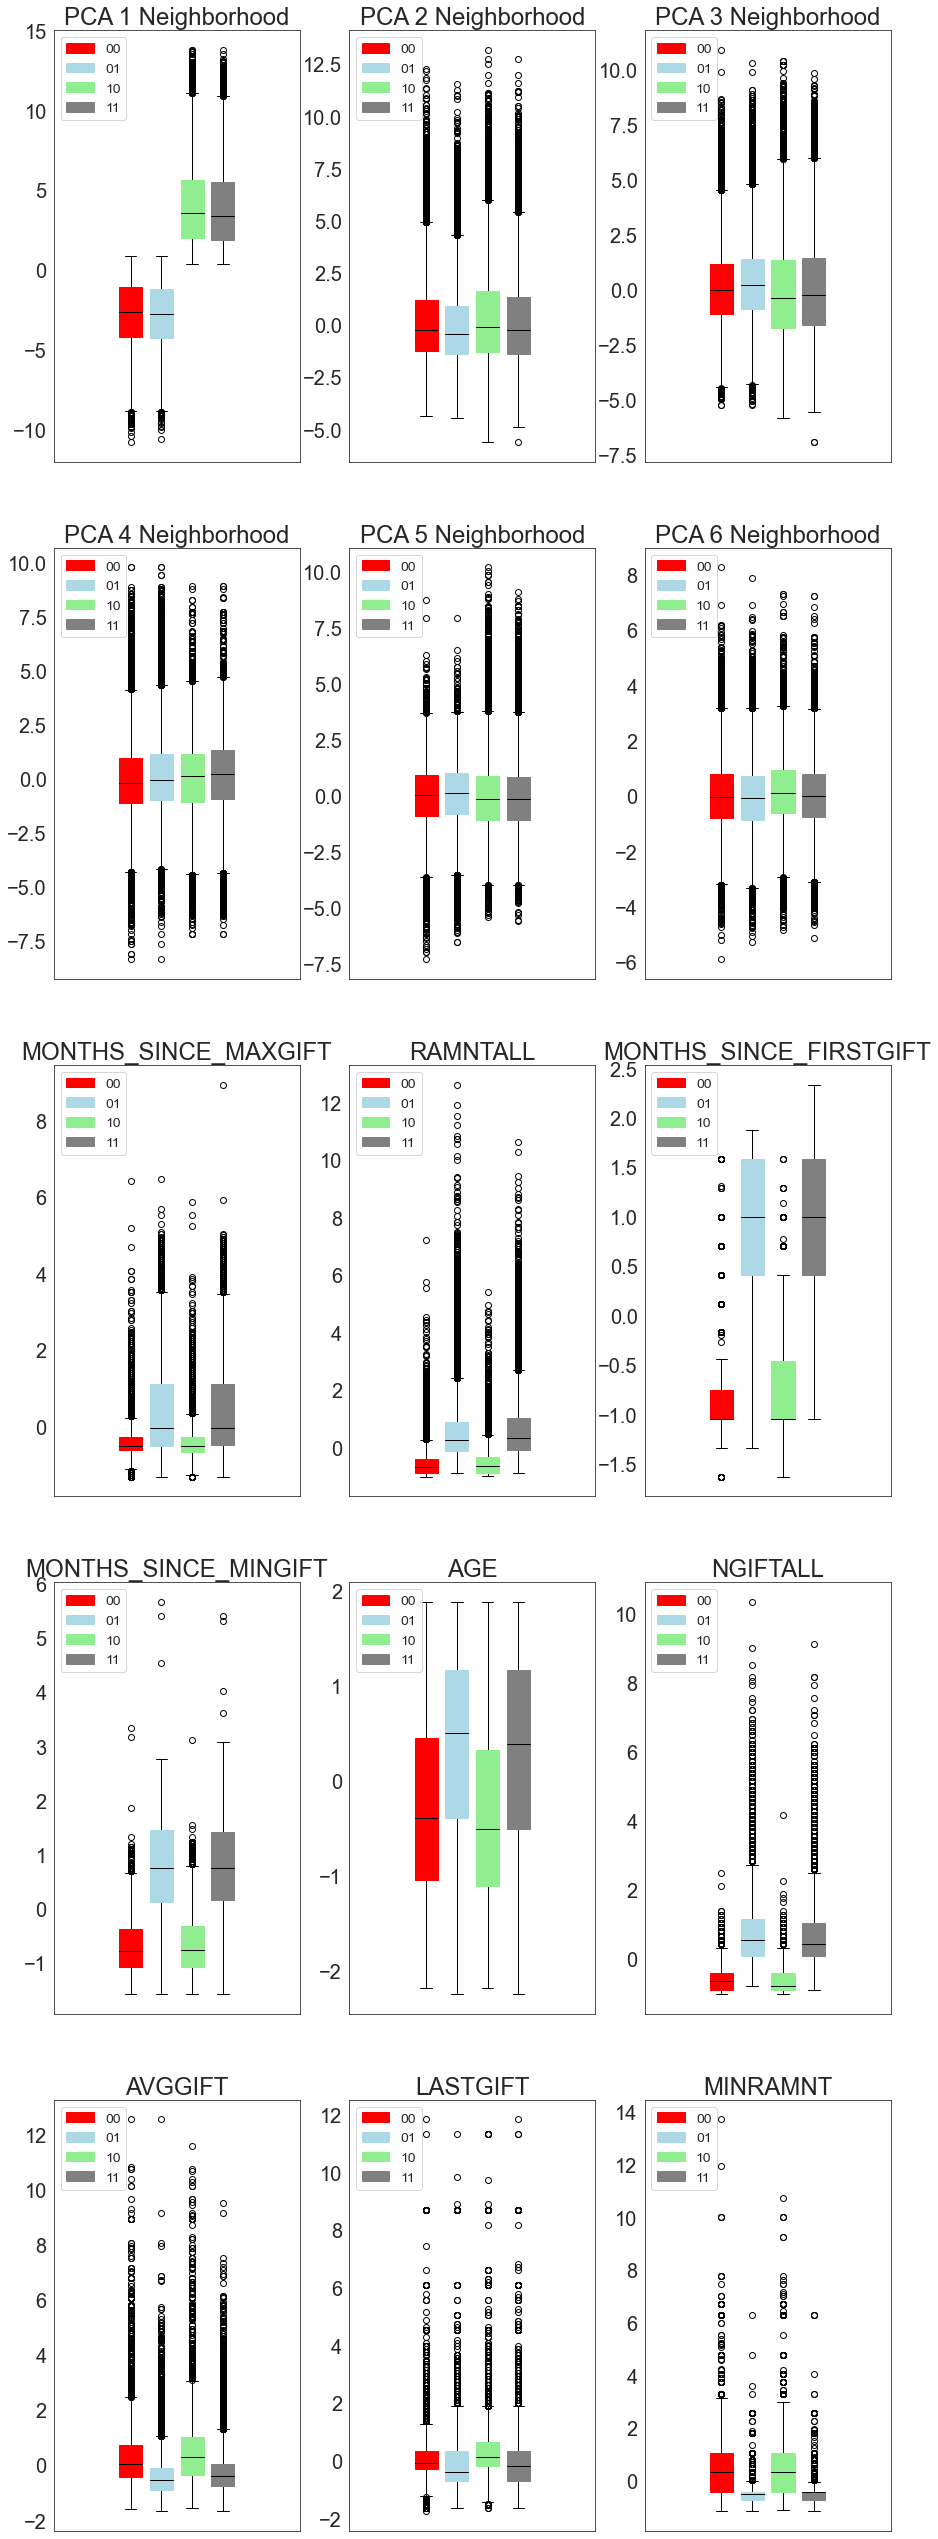

In [129]:
#Plotting a boxplot for each variable in study at this point, in order to compare the distributions for each one between each cluster
plt.figure(figsize=(15,46))

sns.set_style("white")

#defining the number of rows needed
nr_rows=(len(donors_merged.columns))//3

#auxiliar variable to identify the "figure" we are in
i=1

#plotting each variable
for variable in [var for var in donors_merged.columns.values if "Label" not in var]:
    plt.subplot(nr_rows,3,i)
    i+=1
    plt.title(variable)
    plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="00"][variable], positions=np.arange(1), patch_artist=True,boxprops=dict(facecolor="red", color="red"), medianprops=dict(color="black"))
    plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="01"][variable], positions=np.arange(1)+0.2, patch_artist=True,boxprops=dict(facecolor="lightblue", color="lightblue"), medianprops=dict(color="black"))
    plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="10"][variable], positions=np.arange(1)+0.4, patch_artist=True,boxprops=dict(facecolor="lightgreen", color="lightgreen"), medianprops=dict(color="black"))
    plt.boxplot(donors_merged[donors_merged["Final_Labels"]=="11"][variable], positions=np.arange(1)+0.6, patch_artist=True,boxprops=dict(facecolor="grey", color="grey"), medianprops=dict(color="black"))
    red_patch = mpatches.Patch(color='red', label='00')
    blue_patch = mpatches.Patch(color='lightblue', label='01')
    green_patch = mpatches.Patch(color='lightgreen', label='10')
    grey_patch = mpatches.Patch(color='grey', label='11')
    plt.legend(handles=[red_patch, blue_patch,green_patch, grey_patch], loc="upper left", fontsize="x-small")
    plt.xticks([])

plt.show()

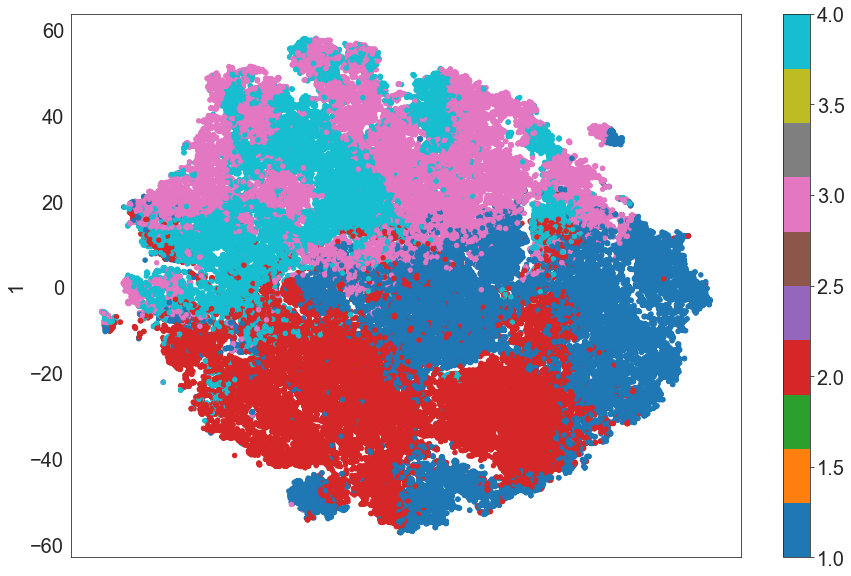

In [130]:
#Plotting a T-SNE visualization to analyse the distributin of the observations according to the cluster label
two_dim = TSNE(random_state=42).fit_transform(donors_merged.loc[:, [col for col in donors_merged.columns.values if "Label" not in col]])
sns.set_style("white")
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=donors_merged.loc[:, "Final_Labels"].apply(lambda x: 1 if x=="00" else 2 if x=="01" else 3 if x=="10" else 4 if x=="11" else x), colormap='tab10', figsize=(15,10))
plt.show()

<b> Analysing Categorical Variables

In [131]:
#concatenating the our donors_merged dataframe with the categorical variables, in order to analyse some of them
final=pd.concat([donors_merged,donors[nominal_variables_encoded]], axis=1, sort=False)

In [132]:
#seeing the differences in means and propotions for all the variables
final.groupby("Final_Labels").mean()

PCA 1 Neighborhood  PCA 2 Neighborhood  PCA 3 Neighborhood  \
Final_Labels                                                               
00                     -2.744778            0.187945            0.103231   
01                     -2.800756           -0.077392            0.326117   
10                      4.069630            0.376154           -0.042520   
11                      3.905739            0.186262            0.076431   

              PCA 4 Neighborhood  PCA 5 Neighborhood  PCA 6 Neighborhood  \
Final_Labels                                                               
00                     -0.058546           -0.054074            0.027041   
01                      0.142611            0.040628           -0.044941   
10                     -0.022821            0.022808            0.151694   
11                      0.133553           -0.010868            0.026535   

              MONTHS_SINCE_MAXGIFT  RAMNTALL  MONTHS_SINCE_FIRSTGIFT  \
Final_Labels                                                           
00                       -0.412438 -0.556940               -0.809483   
01                        0.450382  0.554284                0.910034   
10                       -0.395727 -0.518028               -0.790528   
11                        0.442735  0.662127                0.845305   

              MONTHS_SINCE_MINGIFT  ...  RFA_24_Amount_C  RFA_24_Amount_D  \
Final_Labels                        ...                                     
00                       -0.663077  ...         0.053660         0.289987   
01                        0.726383  ...         0.032611         0.288914   
10                       -0.642903  ...         0.042043         0.251243   
11                        0.716572  ...         0.019959         0.241871   

              RFA_24_Amount_E  RFA_24_Amount_F  RFA_24_Amount_G  \
Final_Labels                                                      
00                   0.261570         0.273197         0.104184   
01                   0.364852         0.235256         0.073819   
10                   0.257228         0.298644         0.138051   
11                   0.355496         0.269837         0.109925   

              TIMELAG_0-4_1  TIMELAG_5-9_1  TIMELAG_10-14_1  TIMELAG_15-19_1  \
Final_Labels                                                                   
00                 0.274650       0.279278         0.168056         0.046240   
01                 0.330584       0.375337         0.174659         0.055354   
10                 0.253801       0.275812         0.168316         0.052759   
11                 0.319340       0.367993         0.180053         0.062970   

              TIMELAG_20-30_1  
Final_Labels                   
00                   0.032166  
01                   0.054313  
10                   0.038519  
11                   0.058178  

[4 rows x 187 columns]

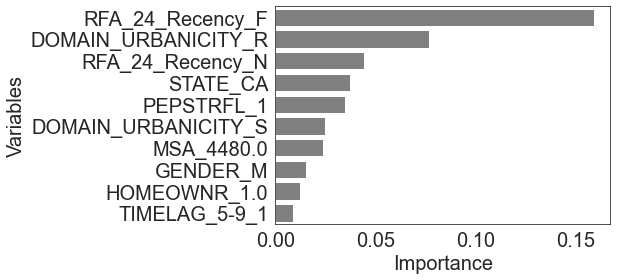

In [133]:
#Using, as before, a decison tree classifier in order to find out whcih are the most important, in terms of entropy, categorical variables to achieve our final cluster solution 
dt=DecisionTreeClassifier(random_state=42)
dt.fit(X=final.loc[:,nominal_variables_encoded], y=final["Final_Labels"])

#Plotting the top 10 most important categorical variables
impo=pd.DataFrame(dt.feature_importances_, columns=["Importance"])
impo["Variables"]=nominal_variables_encoded
impo.sort_values(by="Importance",ascending = False, inplace = True)
sns.barplot(y='Variables', x='Importance', data=impo[:10], color = "grey")
plt.show()

In [134]:
#Defining lists with the categorical variables we considered to be more interesting to study
#First, we have the variables concerning the OSOURCE variable
source = [i for i in final.columns if "OSOURCE" in i]
#Then, the ones regarding the STATE variable
state = [i for i in final.columns if "STATE" in i]
#And finally, the variable which concern the interests of the donors
interests=["CDPLAY_1", "COLLECT1_1", "VETERANS_1", "BIBLE_1", "PCOWNERS_1", "CATLG_1", "PETS_1", "STEREO_1", "PHOTO_1", "CRAFTS_1", "FISHER_1", "GARDENIN_1", "WALKER_1"]

In [135]:
#checking the differences in proportion for the variables related with STATE between each cluster
final.groupby("Final_Labels").mean()[state]*100

STATE_AZ   STATE_CA  STATE_FL  STATE_GA  STATE_IL  STATE_IN  \
Final_Labels                                                                
00            2.340702   7.863536  8.926796  4.528417  5.117418  4.314235   
01            2.305142   6.703415  9.232133  3.211009  6.298666  4.263357   
10            2.717575  32.128204  8.109282  3.629869  8.051359  1.708742   
11            2.814851  30.939092  8.499151  2.960446  8.766076  1.886678   

              STATE_MI  STATE_MO  STATE_NC  STATE_TN  STATE_TX  STATE_WA  \
Final_Labels                                                               
00            6.417808  3.304521  6.127132  3.939417  8.578750  3.273923   
01            6.938555  3.912574  5.647213  3.176316  7.447383  3.226428   
10            5.391707  1.824589  2.785152  1.544625  7.940339  4.518029   
11            5.253579  2.202135  2.475127  1.443824  7.382917  4.719728   

              STATE_WI  
Final_Labels            
00            3.308345  
01            4.525480  
10            1.660472  
11            1.959476

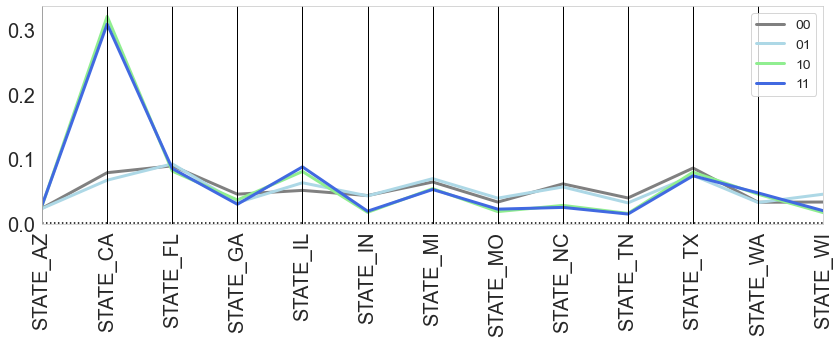

In [136]:
#Plotting those same differences
plt.figure(figsize=(14,4))
sns.set_style("whitegrid")
centroids=final.loc[:, state+["Final_Labels"]].groupby(by="Final_Labels", as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, "Final_Labels", color=["grey","lightblue", "lightgreen", "royalblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.legend(loc="upper right", fontsize="x-small")
plt.xticks(rotation=90)
plt.show()

In [137]:
#Repeting the process for the variables regarding the OSOURCE variable
100*final.groupby("Final_Labels").mean()[source]

OSOURCE_AML  OSOURCE_ARG  OSOURCE_BHG  OSOURCE_IMP  OSOURCE_MBC  \
Final_Labels                                                                    
00               1.269793     3.878222     0.401591     0.673143     5.935898   
01               4.976486     0.053967     6.418164     4.671961     7.297047   
10               2.138340     5.826133     0.463388     1.066757     4.069122   
11               6.679204     0.133463     7.643776     7.449648     5.010920   

              OSOURCE_SYN  
Final_Labels               
00               5.320125  
01               2.185645  
10               5.020032  
11               2.353798

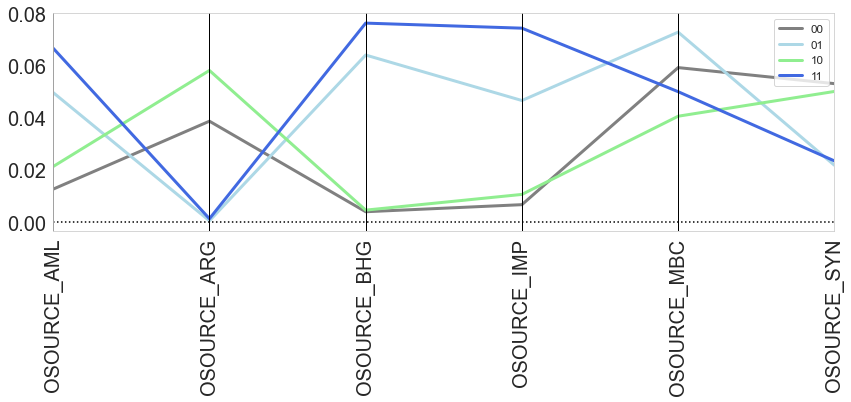

In [138]:
#Plotting the differences
plt.figure(figsize=(14,4))
sns.set_style("whitegrid")
centroids=final.loc[:, source+["Final_Labels"]].groupby(by="Final_Labels", as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, "Final_Labels", color=["grey","lightblue", "lightgreen", "royalblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.legend(loc="upper right", fontsize="xx-small")
plt.xticks(rotation=90)
plt.show()

In [139]:
#Repeting again, now for the variables concerning the donors' interests
100*final.groupby("Final_Labels").mean()[interests]

CDPLAY_1  COLLECT1_1  VETERANS_1    BIBLE_1  PCOWNERS_1  \
Final_Labels                                                             
00            12.541115    6.417808   10.934751  10.923277    9.917387   
01             9.340066    5.069000   11.822527  10.488783    7.058053   
10            17.410822    5.666844   10.059372   7.916204   16.411643   
11            13.916525    4.974521   11.853919   7.740840   12.672895   

               CATLG_1     PETS_1   STEREO_1   PHOTO_1  CRAFTS_1  FISHER_1  \
Final_Labels                                                                 
00            8.307198  16.492006  13.745888  4.956781  9.580815  9.741452   
01            7.832858  13.880965  11.379231  4.271066  8.854367  7.775037   
10            9.127769  16.310277  15.871024  5.975769  8.360284  6.395714   
11            8.396020  14.559573  14.140985  5.520505  7.977433  5.866295   

              GARDENIN_1   WALKER_1  
Final_Labels                         
00             14.587317  10.437543  
01             14.116105  10.666101  
10             14.196071  11.801902  
11             14.371512  12.345305

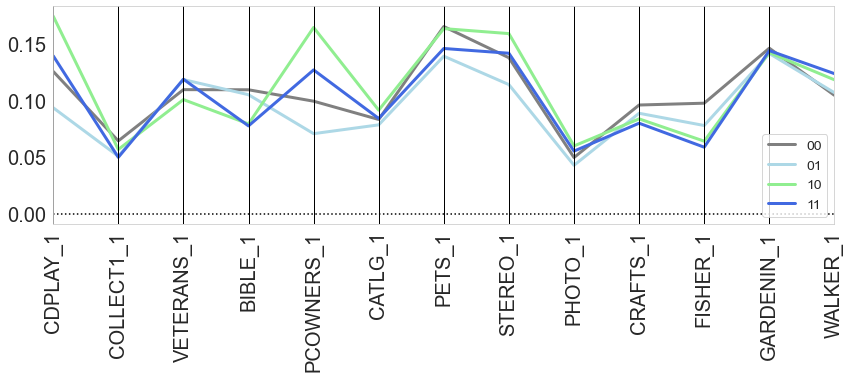

In [140]:
#Plotting, once more
plt.figure(figsize=(14,4))
sns.set_style("whitegrid")
centroids=final.loc[:, interests+["Final_Labels"]].groupby(by="Final_Labels", as_index=False).mean()
pd.plotting.parallel_coordinates(centroids, "Final_Labels", color=["grey","lightblue", "lightgreen", "royalblue"], lw=3)
plt.axhline(y=0, color='black', linestyle='dotted')
plt.legend(loc="lower right", fontsize="x-small")
plt.xticks(rotation=90)
plt.show()

<b> Prediction of the geral outliers

In [141]:
#Finally, we will predict to which cluster each geral outlier will belong to.

#First, we will concat the geral outliers from the neighborhood perspective (as those are transformed by PCA) with the ones stored in df_outliers, belonging to the personal perspective
final_outliers=pd.concat([pcas_neigh_new.loc[df_outliers.index, "PCA 1 Neighborhood":"PCA 6 Neighborhood"], df_outliers[new_personal]], axis=1,sort=False)

#As before, we will split our X (our variables) and our y (our cluster labels)
X_train, X_test, y_train, y_test = train_test_split(donors_merged.iloc[:,:-1], donors_merged["Final_Labels"], test_size=0.3, random_state=42)
#We will fit a DecisionTreeClassifier to our X_train and y_train
decision_tree= DecisionTreeClassifier(random_state=42, max_depth=3)
decision_tree.fit(X_train, y_train)

print("On average, we will allocate our donors to the correct clusters", round(decision_tree.score(X_test, y_test)*100, 3), "% of the times.")

#We will predict to which cluster each outlier will belong to
preditions=pd.Series(decision_tree.predict(final_outliers), index=final_outliers.index)

#Inserting our predictions in the df_outliers dataframe
df_outliers["Final_Labels"]=preditions

#deleting the final_outliers, as it is no longer needed
del final_outliers

#Going to our donors dataframe and inserting the labels from our non-geral outliers observations
donors.loc[donors_merged.index,"Final_Labels"]=pd.Series(donors_merged["Final_Labels"], index=donors_merged.index)

#Finally, we concat our donors dataframe with our df_outliers, in order to have all the observations in just one place
donors=pd.concat([donors,df_outliers]).drop(["Labels_KMeans_Neigh","Labels_KMeans_Personal"], axis=1)

#Dropping an unecessary label
donors.drop(["Labels_DBSCAN_Personal"], inplace=True, axis=1)


#Checking that everything is alright
donors

On average, we will allocate our donors to the correct clusters 92.429 % of the times.


OSOURCE_AML  OSOURCE_ARG  OSOURCE_BHG  OSOURCE_IMP  OSOURCE_MBC  \
CONTROLN                                                                    
95515             0.0          0.0          0.0          0.0          0.0   
15078             0.0          0.0          0.0          0.0          0.0   
172556            0.0          0.0          0.0          0.0          0.0   
47784             0.0          0.0          0.0          0.0          0.0   
62117             0.0          0.0          0.0          0.0          0.0   
...               ...          ...          ...          ...          ...   
191755            0.0          0.0          0.0          0.0          0.0   
191758            0.0          0.0          0.0          0.0          0.0   
191759            0.0          0.0          0.0          0.0          0.0   
191763            0.0          0.0          0.0          0.0          0.0   
191768            0.0          0.0          0.0          0.0          0.0   

          OSOURCE_SYN  STATE_AZ  STATE_CA  STATE_FL  STATE_GA  ...  \
CONTROLN                                                       ...   
95515             0.0       0.0       0.0       0.0       0.0  ...   
15078             0.0       0.0       0.0       0.0       0.0  ...   
172556            0.0       0.0       1.0       0.0       0.0  ...   
47784             0.0       0.0       0.0       0.0       0.0  ...   
62117             0.0       0.0       0.0       0.0       0.0  ...   
...               ...       ...       ...       ...       ...  ...   
191755            0.0       0.0       0.0       0.0       0.0  ...   
191758            0.0       0.0       0.0       0.0       0.0  ...   
191759            0.0       0.0       1.0       0.0       0.0  ...   
191763            0.0       0.0       1.0       0.0       0.0  ...   
191768            0.0       0.0       0.0       0.0       0.0  ...   

          MONTHS_SINCE_MAXGIFT  LASTGIFT  MONTHS_SINCE_LASTGIFT   AVGGIFT  \
CONTROLN                                                                    
95515                 0.455169 -0.712796              -0.296046 -0.745378   
15078                 1.391746 -1.235881              -0.296046 -0.782897   
172556                0.011527 -0.712796              -0.296046 -0.879266   
47784                -0.037766 -0.189710               1.716516 -0.023956   
62117                 0.060821 -0.608179               2.387370 -0.759651   
...                        ...       ...                    ...       ...   
191755               -0.284234  0.124141               2.051943 -0.008521   
191758                1.095985 -0.189710              -0.296046 -0.145090   
191759                1.983268 -0.712796              -0.966900 -0.840251   
191763               -0.234940  0.856461               2.387370  0.341320   
191768               -0.284234  0.856461               1.381089  0.420205   

             ANCEU  DOMAIN_SOCIAL_ECONOMIC  INCOME  MHUC1  MHUC2  Final_Labels  
CONTROLN                                                                        
95515     0.611528                     2.0     5.0    6.0    2.0            01  
15078    -0.005423                     2.0     3.0    9.0    2.0            01  
172556   -0.710510                     2.0     1.0   16.0    2.0            01  
47784     0.170849                     2.0     5.0    9.0    3.0            00  
62117    -0.093559                     2.0     4.0    5.0    2.0            01  
...            ...                     ...     ...    ...    ...           ...  
191755   -0.181695                     2.0     4.0    7.0    3.0            11  
191758    0.875936                     2.0     6.0    5.0    2.0            01  
191759   -0.534238                     3.0     2.0   15.0    3.0            01  
191763    1.228480                     2.0     5.0    6.0    2.0            00  
191768   -0.446103                     2.0     2.0    7.0    2.0            01  

[93610 rows x 320 columns]